In [150]:
import yfinance as yf

ModuleNotFoundError: No module named 'yfinance'

In [ ]:
import requests
import pandas as pd
import yfinance as yf
from bs4 import BeautifulSoup
from datetime import datetime

# Step 1: Scrape the Current S&P 500 Component Stocks Table
def get_current_sp500_tickers():
    # Wikipedia URL for S&P 500 components
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    # Find the table with S&P 500 current components
    table = soup.find("table", {"id": "constituents"})

    # Extract the data into a DataFrame
    tickers = []
    rows = table.find_all("tr")[1:]  # Skip header row
    for row in rows:
        cols = row.find_all("td")
        ticker = cols[0].text.strip()
        ticker = ticker.replace(".", "-")  # Yahoo Finance uses '-' instead of '.' for tickers like BRK.B
        company = cols[1].text.strip()
        gics_sector = cols[3].text.strip()
        date_added = cols[5].text.strip()
        tickers.append({
            "Ticker": ticker,
            "Company": company,
            "GICS Sector": gics_sector,
            "Date Added": date_added,
        })

    df_tickers = pd.DataFrame(tickers)
    return df_tickers

# # Step 2: Download Historical Data for Tickers in the Formation Period
# def fetch_historical_data(tickers, start_date, end_date, column='Close'):
#     price_data = {}
#     for ticker in tickers:
#         try:
#             stock = yf.Ticker(ticker)
#             hist = stock.history(start=start_date, end=end_date)
#             if not hist.empty:
#                 price_data[ticker] = hist[column]
#         except Exception as e:
#             print(f"Error processing {ticker}: {e}")

#     price_df = pd.DataFrame(price_data)

#     #missing
#     minimum_required_data_points = 0.8 * len(price_df)  # 80% availability required
#     valid_price_df = price_df.dropna(axis=1, thresh=minimum_required_data_points)
#     print(f"Step 3: Price data ready for pairs trading with {valid_price_df.shape[1]} tickers.")

#     # Interpolate missing values
#     price_df = price_df.interpolate(method='linear', limit_direction='forward')


#     return price_df

# # Step 3: Main Function to Prepare Data for Pairs Trading
# def prepare_pairs_trading_data(start_date, end_date):
#     print("Step 1: Scraping current S&P 500 components from Wikipedia...")
#     current_tickers_df = get_current_sp500_tickers()

#     print(f"Step 2: Fetching historical price data for {len(current_tickers_df)} tickers...")
#     valid_tickers = current_tickers_df['Ticker'].tolist()

#     # Fetch price data for the valid tickers
#     price_df = fetch_historical_data(valid_tickers, start_date, end_date, column='Open')

#     return price_df


# # Set the parameters for the period of interest
# start_date = '2000-01-01'
# end_date = datetime.today().strftime('%Y-%m-%d')

# # Prepare the data for pairs trading formation period
# #price_data_for_pairs_trading = prepare_pairs_trading_data(start_date, end_date)

# # Save data to CSV for analysis
# #price_data_for_pairs_trading.to_csv("pairs_trading_open_data.csv")
# print("Price data saved to 'pairs_trading_price_data.csv'")


Price data saved to 'pairs_trading_price_data.csv'


In [ ]:
import pandas as pd

df = pd.read_csv('pairs_trading_price_data.csv', index_col='Date', parse_dates=True)
print("shape:", df.shape)
print(df.head())
# df.reindex()

# explore missing values
missing_values = df.isnull().sum() / df.shape[0]
missing_columns = missing_values[missing_values > 0]

print(missing_columns) #the nan values are from before the stock became tradeable

shape: (6273, 503)
                                 MMM       AOS       ABT  ABBV  ACN  \
Date                                                                  
2000-01-03 00:00:00-05:00  19.709019  2.311836  8.288182   NaN  NaN   
2000-01-04 00:00:00-05:00  18.925879  2.278525  8.051374   NaN  NaN   
2000-01-05 00:00:00-05:00  19.474072  2.271862  8.036574   NaN  NaN   
2000-01-06 00:00:00-05:00  21.040354  2.238551  8.317780   NaN  NaN   
2000-01-07 00:00:00-05:00  21.458023  2.331824  8.406582   NaN  NaN   

                                ADBE     AMD        AES       AFL          A  \
Date                                                                           
2000-01-03 00:00:00-05:00  16.274670  15.500  24.847677  6.814992  43.463047   
2000-01-04 00:00:00-05:00  14.909397  14.625  23.862333  6.634150  40.142933   
2000-01-05 00:00:00-05:00  15.204174  15.000  24.119383  6.596074  37.652863   
2000-01-06 00:00:00-05:00  15.328291  16.000  24.312166  6.729326  36.219193   
200

In [ ]:
import pandas as pd
import numpy as np

def calculate_returns(price_df, return_type="simple"):
    """
    Calculate returns DataFrame (simple or log returns) from a price DataFrame.

    Parameters:
        price_df (pd.DataFrame): DataFrame with stock prices (columns as assets).
        return_type (str): Type of returns to calculate ("simple" or "log").

    Returns:
        pd.DataFrame: DataFrame containing the calculated returns.
    """
    if return_type == "simple":
        # Calculate simple returns
        returns_df = price_df.pct_change()
    elif return_type == "log":
        # Calculate log returns
        returns_df = np.log(price_df / price_df.shift(1))
    else:
        raise ValueError("Invalid return_type. Choose 'simple' or 'log'.")

    return returns_df
log_returns = calculate_returns(df, return_type="log")
log_prices = np.log(df)

Clustering Sectors

In [ ]:
current_tickers_df = get_current_sp500_tickers()

# Step 1: Group tickers by GICS sector
grouped = current_tickers_df.groupby('GICS Sector')['Ticker'].apply(list)

# Step 2: Find the maximum number of tickers in any sector
max_tickers = max(len(tickers) for tickers in grouped)

# Step 3: Create a DataFrame with GICS sectors as columns and tickers underneath
sector_df = pd.DataFrame({
    sector: tickers + [None] * (max_tickers - len(tickers))  # Pad shorter lists with None
    for sector, tickers in grouped.items()
})


In [ ]:
def calculate_sector_returns(sector_df, log_returns, start_date, num_days=252):
    """
    Calculate mean returns for each sector over a given time period.

    Parameters:
        sector_df (pd.DataFrame): DataFrame with GICS sectors as columns and tickers underneath.
        log_returns (pd.DataFrame): DataFrame with log returns (columns: tickers, index: dates).
        start_date (str): The start date for the calculation period (YYYY-MM-DD format).
        num_days (int): The number of days for the calculation period (default is 252).

    Returns:
        pd.DataFrame: Sector mean returns DataFrame with sectors as columns and mean returns as rows.
    """
    # Convert start_date to a pandas datetime
    start_date = pd.to_datetime(start_date, utc=True)
    end_date = start_date + pd.Timedelta(days=num_days - 1)

    # Filter log returns for the specified date range
    filtered_returns = log_returns.loc[start_date:end_date]

    # Initialize dictionary to store sector mean returns
    sector_mean_returns = {}

    # Loop through each sector
    for sector in sector_df.columns:
        # Extract tickers for the sector
        tickers = sector_df[sector].dropna().tolist()

        # Check if tickers exist in log_returns
        valid_tickers = [
            ticker for ticker in tickers 
            if ticker in filtered_returns.columns and not filtered_returns[ticker].isnull().any()
        ]
        
        # Aggregate mean returns for the sector
        if valid_tickers:
            sector_mean_returns[sector] = filtered_returns[valid_tickers].mean(axis=1)
    
    # Convert the results to a DataFrame
    sector_returns_df = pd.DataFrame(sector_mean_returns)

    return sector_returns_df

In [ ]:
sector_returns_df_2000 = calculate_sector_returns(sector_df, log_returns, "2000-01-04")

NameError: name 'calculate_sector_returns' is not defined

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

def make_cluster(start_date, n_clusters=5, num_days=252):
    """
    Perform K-Means clustering on GICS sectors based on their return profiles.

    Parameters:
        start_date (str): Start date for clustering (YYYY-MM-DD format).
        n_clusters (int): Number of clusters to form (default is 5).
        num_days (int): Number of days from start_date to consider (default is 252).

    Returns:
        pd.DataFrame: DataFrame mapping GICS sectors to their clusters.
    """
    # Filter data for the specified date range
    start_date = pd.to_datetime(start_date, utc=True)
    end_date = start_date + pd.Timedelta(days=num_days - 1)
    sec_returns_df = calculate_sector_returns(sector_df, log_returns, start_date, num_days=num_days)
    filtered_data = sec_returns_df.loc[start_date:end_date]

    # Step 1: Transpose the DataFrame
    sector_transposed = filtered_data.T

    # Step 2: Scale the Data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(sector_transposed)

    # Step 3: Apply K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)

    # Step 4: Add Cluster Labels to Sectors
    sector_transposed['Cluster'] = clusters

    # Create a DataFrame mapping GICS sectors to clusters
    sector_cluster_mapping = pd.DataFrame({
        'GICS Sector': filtered_data.columns,
        'Cluster': clusters
    })
    return sector_cluster_mapping

sector_cluster_mapping_2000 = make_cluster('2000-01-04')
# Step 5: Print Clusters
print("Clusters and their GICS Sectors:")
for cluster_id, sectors in sector_cluster_mapping_2000.groupby('Cluster'):
    print(f"Cluster {cluster_id}:")
    print(sectors['GICS Sector'].tolist())
    print()

Clusters and their GICS Sectors:
Cluster 0:
['Footwear']

Cluster 1:
['Advertising', 'Construction & Engineering', 'Gold', 'Integrated Oil & Gas', 'Oil & Gas Equipment & Services', 'Oil & Gas Exploration & Production', 'Oil & Gas Refining & Marketing', 'Oil & Gas Storage & Transportation']

Cluster 2:
['Application Software', 'Biotechnology', 'Broadline Retail', 'Cable & Satellite', 'Communications Equipment', 'Computer & Electronics Retail', 'Diversified Support Services', 'Electronic Components', 'Electronic Equipment & Instruments', 'Electronic Manufacturing Services', 'IT Consulting & Other Services', 'Interactive Home Entertainment', 'Interactive Media & Services', 'Internet Services & Infrastructure', 'Investment Banking & Brokerage', 'Life Sciences Tools & Services', 'Semiconductor Materials & Equipment', 'Semiconductors', 'Systems Software', 'Technology Hardware, Storage & Peripherals', 'Telecom Tower REITs', 'Transaction & Payment Processing Services']

Cluster 3:
['Aerospace 

In [ ]:
from statsmodels.tsa.stattools import coint, adfuller
def filter_nonstationary(data, start_date, num_days=252, significance_level=0.05):
    """
    Filter stocks to ensure theyre nonstationary using the ADF test.

    Parameters:
        data (pd.DataFrame): DataFrame of stock prices.
        start_date: start date of the formation period
        num_days = how long formation period is
        significance_level (float): The threshold p-value for stationarity (default=0.05).

    Returns:
        pd.DataFrame: DataFrame of nonstationary stocks
    """
    
    nonstationary = []
    start_date = pd.to_datetime(start_date, utc=True)
    end_date = start_date + pd.Timedelta(days=num_days - 1)
    filtered_data = data.loc[start_date:end_date]
    filtered_data = filtered_data.loc[:, ~filtered_data.isna().any()]

    for col in filtered_data.columns:
        adf_result = adfuller(filtered_data[col])
        adf_stat = adf_result[0]  # Test statistic
        p_value = adf_result[1]   # p-value

        # drop if the spread is stationary
        if p_value > significance_level:
            nonstationary.append({
                "Tick": col,
                "P-Value": p_value
            })

    return nonstationary

nonstat_stocks = filter_nonstationary(log_prices, "2000-01-03")

Forming Pairs by Cointegration and Correlation

In [ ]:
from statsmodels.tsa.stattools import coint
import pandas as pd
from itertools import combinations

def cointegration_analysis(data, ticks, start_date, num_days=252, significance_level=0.05, correlation_min=0.8):
    """
    Perform cointegration analysis on all possible pairs from ticks.

    Parameters:
        data (pd.DataFrame): Historical asset prices.
        ticks (list): List of tickers from `filter_nonstationary`.
        start_date (str): Start date for analysis.
        num_days (int): Number of days to analyze (default=365).
        significance_level (float): P-value significance threshold (default=0.05).
        correlation_min: minimum threshold for pairs to be considered for cointegration

    Returns:
        pd.DataFrame, pd.DataFrame: Top cointegrated pairs, top volatile pairs. (didn't end up using volatile pairs)
    """
    start_date = pd.to_datetime(start_date, utc=True)
    end_date = start_date + pd.Timedelta(days=num_days - 1)
    filtered_data = data.loc[start_date:end_date]
    cointegration_results = []

    # Generate all possible pairs from the ticks list
    for asset1, asset2 in combinations(ticks, 2):
        # Drop rows with NaNs for both assets
        valid_data = filtered_data[[asset1, asset2]].dropna()

        correlation = np.corrcoef(valid_data[asset1], valid_data[asset2])[0, 1]
        if abs(correlation) < correlation_min:
            continue  # Skip pairs with low correlation
        
        if valid_data.empty:
            continue

        try:
            # Perform cointegration test
            score, p_value, _ = coint(valid_data[asset1], valid_data[asset2])

            if p_value < significance_level:  # Check for significance
                spread = valid_data[asset1] - valid_data[asset2]
                cointegration_results.append({
                    'Asset 1': asset1,
                    'Asset 2': asset2,
                    'T Statistic': score,
                    'P-Value': p_value,
                    'Volatility': spread.std()
                })

        except Exception as e:
            print(f"Error testing pair ({asset1}, {asset2}): {e}")

    # Convert results to DataFrame
    coint_df = pd.DataFrame(cointegration_results)

    if coint_df.empty:
        print("No cointegrated pairs found.")
        return pd.DataFrame(), pd.DataFrame()

    # Sort by T-statistic and Volatility
    top_coint_pairs = coint_df.nsmallest(20, 'T Statistic')
    top_volatile_pairs = coint_df.nlargest(20, 'Volatility')

    return top_coint_pairs, top_volatile_pairs

Saving Cointegrated Pairs (1 Yr Formation Period Every 6 Months)

In [ ]:
import pandas as pd
from datetime import timedelta

def run_cointegration_rolling_no_cluster(log_prices, start_date, num_days=252, window_size=126, significance_level=0.05):
    """
    Get top 20 pairs from cointegration(not using cluster) every half trading year using 1 year formation period

    Parameters:
        log_prices (pd.DataFrame): Historical log prices.
        start_date (str): Start date for the first window.
        window_size (int): Number of trading days in each window (default=126).
        significance_level (float): P-value threshold for cointegration (default=0.05).

    Returns:
        None: Saves CSV files with top 20 pairs for each half trading year window.
    """
    start_date = pd.to_datetime(start_date, utc=True)

    while True:
        # Define end date for the current window
        end_date = start_date + pd.Timedelta(days=num_days - 1)

        # Ensure date range is within data bounds
        if end_date > log_prices.index.max():
            print("Reached the end of the available data.")
            break

        # Run cointegration analysis for the current window
        print(f"Processing window: {start_date.date()} to {end_date.date()}")
        ticks_list = [item['Tick'] for item in filter_nonstationary(log_prices, start_date)]
        results, _ = cointegration_analysis(log_prices, ticks_list, start_date,  num_days=num_days, correlation_min=0.95)

        
        # Extract top 20 pairs by T-statistic
        top_20_pairs = results

        # Save to CSV
        file_name = f"noclusterpairs_{start_date.date()}_{end_date.date()}.csv"
        top_20_pairs.to_csv(file_name, index=False)
        print(f"Saved top 20 pairs to {file_name}")


        # Move the window forward by half the window size (~half trading year)
        start_date = start_date + pd.Timedelta(days=window_size - 1) + timedelta(days=1)


In [ ]:
#this is how we save the pairs for each formation period
#run_cointegration_rolling_no_cluster(log_prices, "2020-05-12") 

Saving Cointegrated Pairs with Clustering (1 Yr Formation Period Every 6 Months)

In [ ]:
from itertools import combinations
from statsmodels.tsa.stattools import coint
import pandas as pd

def run_cointegration_by_cluster(log_prices, cluster_mapping, start_date, num_days=252, significance_level=0.05):
    """
    Run cointegration analysis for each cluster and get top 20 pairs every formation period.

    Parameters:
        log_prices (pd.DataFrame): Historical log prices of tickers.
        cluster_mapping (pd.DataFrame): DataFrame mapping GICS sectors to clusters.
        start_date (str): Start date for analysis.
        num_days (int): Number of days to analyze (default=365).
        significance_level (float): P-value significance threshold (default=0.05).

    Returns:
        dict: Dictionary of results for each cluster, containing top cointegrated pairs.
    """
    start_date = pd.to_datetime(start_date, utc=True)
    end_date = start_date + pd.Timedelta(days=num_days - 1)
    
    # Filter non-stationary stocks
    nonstat = filter_nonstationary(log_prices, start_date=start_date)
    tickers = [d['Tick'] for d in nonstat]
    # Prepare dictionary to store results for each cluster
    cluster_results = {}

    # Group tickers by cluster
    for cluster_id, cluster_data in cluster_mapping.groupby('Cluster'):
        print(f"Processing Cluster {cluster_id}...")
        cluster_tickers = []

        for sector in cluster_data['GICS Sector']:
            for tick in sector_df[sector].dropna():
                if tick in tickers: 
                    cluster_tickers.append(tick)
        print(cluster_tickers)
        cluster_log_prices = log_prices.loc[start_date:end_date, cluster_tickers].dropna(axis=1, how='any')
        
        # Run cointegration analysis on the cluster-specific log prices
        top_coint_pairs, top_volatile_pairs = cointegration_analysis(
            cluster_log_prices, cluster_tickers, start_date, num_days=num_days, significance_level=significance_level, correlation_min=0.95
        )

        # Store the results in the dictionary
        cluster_results[cluster_id] = {
            'Top Cointegrated Pairs': top_coint_pairs,
        }

    return cluster_results

# Example Usage
cluster_results = run_cointegration_by_cluster(log_prices, sector_cluster_mapping_2000, start_date='2000-01-03', num_days=252)

# Print results for each cluster
for cluster_id, results in cluster_results.items():
    print(f"\nCluster {cluster_id}:")
    print("Top Cointegrated Pairs:")
    print(results['Top Cointegrated Pairs'])


Processing Cluster 0...
['DECK']
No cointegrated pairs found.
Processing Cluster 1...
['IPG', 'J', 'PWR', 'NEM', 'CVX', 'HES', 'BKR', 'HAL', 'SLB', 'APA', 'COP', 'CTRA', 'DVN', 'EOG', 'EQT', 'OXY', 'VLO', 'OKE']
Processing Cluster 2...
['ADBE', 'ANSS', 'ADSK', 'CDNS', 'FICO', 'INTU', 'ORCL', 'PTC', 'SNPS', 'TYL', 'AMGN', 'BIIB', 'GILD', 'INCY', 'REGN', 'VRTX', 'AMZN', 'EBAY', 'CMCSA', 'FFIV', 'JNPR', 'MSI', 'BBY', 'CTAS', 'CPRT', 'APH', 'GLW', 'ROP', 'TDY', 'TRMB', 'ZBRA', 'JBL', 'CTSH', 'IT', 'IBM', 'EA', 'TTWO', 'AKAM', 'VRSN', 'SCHW', 'GS', 'MS', 'RJF', 'A', 'TECH', 'DHR', 'MTD', 'TMO', 'WAT', 'AMAT', 'KLAC', 'LRCX', 'TER', 'AMD', 'ADI', 'INTC', 'MCHP', 'MU', 'NVDA', 'QCOM', 'SWKS', 'TXN', 'GEN', 'MSFT', 'AAPL', 'HPQ', 'NTAP', 'WDC', 'AMT', 'CCI', 'FI', 'JKHY']
No cointegrated pairs found.
Processing Cluster 3...
['BA', 'GE', 'GD', 'LMT', 'NOC', 'RTX', 'DE', 'ADM', 'CHRW', 'EXPD', 'FDX', 'UPS', 'ROST', 'NKE', 'RL', 'BLK', 'BK', 'BEN', 'IVZ', 'NTRS', 'STT', 'TROW', 'F', 'BWA', 'KMX',

In [ ]:
import pandas as pd
from datetime import timedelta

def run_cointegration_rolling(log_prices, start_date, num_days=252, window_size=126, significance_level=0.05):
    """
    Perform cointegration analysis every half trading year and save results.

    Parameters:
        log_prices (pd.DataFrame): Historical log prices.
        cluster_mapping (pd.DataFrame): DataFrame mapping GICS sectors to clusters.
        start_date (str): Start date for the first window.
        window_size (int): Number of trading days in each window (default=126).
        significance_level (float): P-value threshold for cointegration (default=0.05).

    Returns:
        None: Saves CSV files with top 20 pairs for each half trading year window.
    """
    start_date = pd.to_datetime(start_date, utc=True)

    while True:
        # Define end date for the current window
        end_date = start_date + pd.Timedelta(days=num_days - 1)
        cluster_mapping = make_cluster(start_date, num_days=num_days)

        # Ensure date range is within data bounds
        if end_date > log_prices.index.max():
            print("Reached the end of the available data.")
            break

        # Run cointegration analysis for the current window
        print(f"Processing window: {start_date.date()} to {end_date.date()}")
        cluster_results = run_cointegration_by_cluster(
            log_prices, cluster_mapping, start_date=start_date, num_days=num_days, significance_level=significance_level
        )

        # Combine results into a DataFrame
        all_results = pd.concat(
            [results['Top Cointegrated Pairs'].assign(Cluster=cluster_id)
             for cluster_id, results in cluster_results.items()
             if not results['Top Cointegrated Pairs'].empty],
            ignore_index=True
        )

        if not all_results.empty:
            # Extract top 20 pairs by T-statistic
            top_20_pairs = all_results.nsmallest(20, 'T Statistic')

            # Save to CSV
            file_name = f"pairs_{start_date.date()}_{end_date.date()}.csv"
            top_20_pairs.to_csv(file_name, index=False)
            print(f"Saved top 20 pairs to {file_name}")
        else:
            print(f"No cointegrated pairs found for window: {start_date.date()} to {end_date.date()}")

        # Move the window forward by half the window size (~half trading year)
        start_date = start_date + pd.Timedelta(days=window_size - 1) + timedelta(days=1)


In [ ]:
#this is how we save results
#run_cointegration_rolling(log_prices, "2013-06-18") 

Plotting spread of pairs

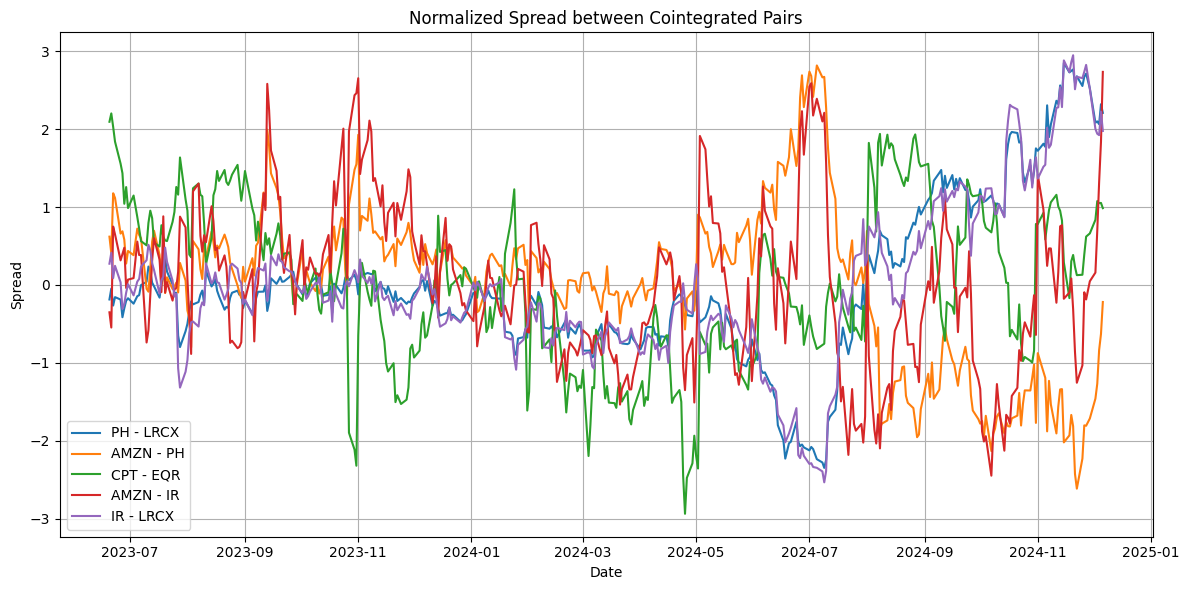

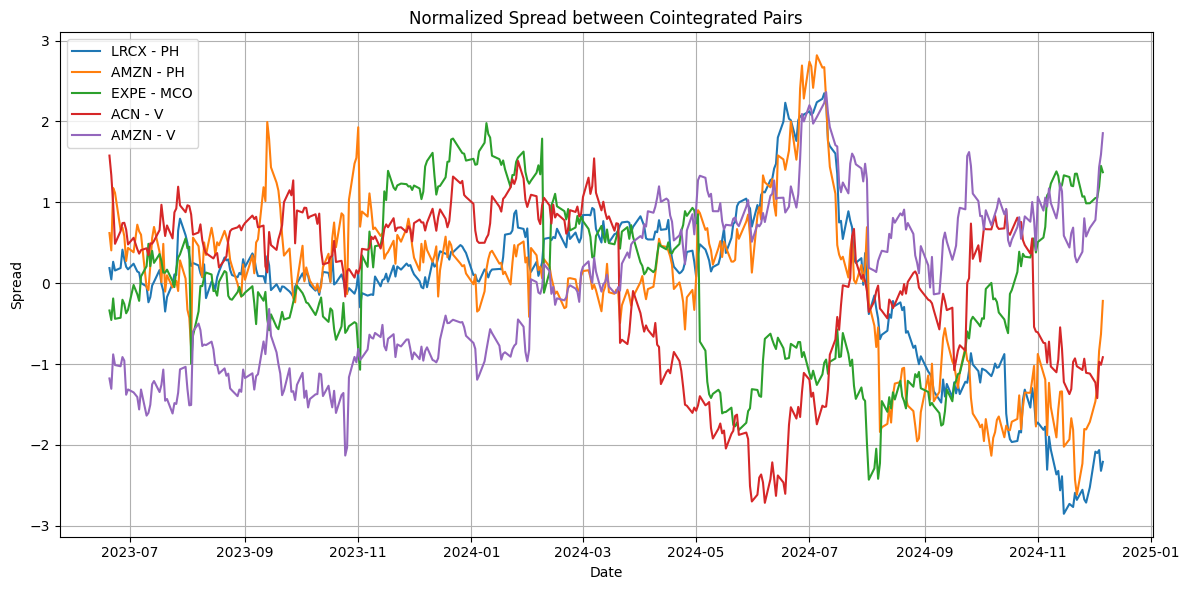

In [ ]:
import matplotlib.pyplot as plt
# Unused code that did both top cointegrated and top volatile pairs
#decided against using top volatile because it was taking too long to process

# def cointegration_analysis(data, top_pairs, start_date, num_days=365):
#     start_date = pd.to_datetime(start_date, utc=True)
#     end_date = start_date + pd.Timedelta(days=num_days - 1)
#     filtered_data = data.loc[start_date:end_date]
#     cointegration_results = []

#     for _, row in top_pairs.iterrows():
#         asset1, asset2 = row['Variable 1'], row['Variable 2']

#         # Find first valid index where both assets are non-NaN
#         valid_data = filtered_data
#         # Perform cointegration test
#         result = coint(valid_data[asset1], valid_data[asset2])
#         p_value = result[1]
#         score = result[0]
#         crit = result[2]
#         spread = valid_data[asset1] - valid_data[asset2]

#         if p_value < 0.05:  # Check for p-value significance
#           cointegration_results.append({
#               'Asset 1': asset1,
#               'Asset 2': asset2,
#               'T Statistic': score,
#               'P-Value': p_value,
#               'Volatility': spread.std()
#         })

#     # Convert to DataFrame
#     coint_df = pd.DataFrame(cointegration_results)

#     # Sort by trace statistic and keep the top 20 pairs
#     coint_df.sort_values(by='T Statistic', ascending=True, inplace=True)
#     top_coint_pairs = coint_df.head(20)

#     coint_df.sort_values(by='Volatility', ascending=False, inplace=True)
#     top_volatile_pairs = coint_df.head(20)
#     return top_coint_pairs, top_volatile_pairs

# plot spread
def plot_coint_spreads(data, cointegrated_pairs, start_date, num_days=365*2):
    start_date = pd.to_datetime(start_date, utc=True)
    end_date = start_date + pd.Timedelta(days=num_days - 1)
    filtered_data = data.loc[start_date:end_date]

    plt.figure(figsize=(12, 6))
    for _, row in cointegrated_pairs.iterrows():
        asset1, asset2 = row['Asset 1'], row['Asset 2']
        # Calculate the spread
        spread = filtered_data[asset1] - filtered_data[asset2]
        normalized_spread = (spread - spread.mean()) / spread.std()
        plt.plot(filtered_data.index, normalized_spread, label=f"{asset1} - {asset2}")

    plt.title('Normalized Spread between Cointegrated Pairs')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

pairs = pd.read_csv('pairs_2000-01-04_2000-09-11.csv')
pairs_nc = pd.read_csv('noclusterpairs_2000-01-04_2000-09-11.csv')

pairs2 = pd.read_csv('pairs_2023-06-20_2024-02-26.csv')
pairs2_nc = pd.read_csv('noclusterpairs_2023-06-20_2024-02-26.csv')
plot_coint_spreads(log_prices, pairs2[:5], start_date="2023-06-20")
plot_coint_spreads(log_prices, pairs2_nc[:5], start_date="2023-06-20")


Execute Trading Strategy: Distance Method

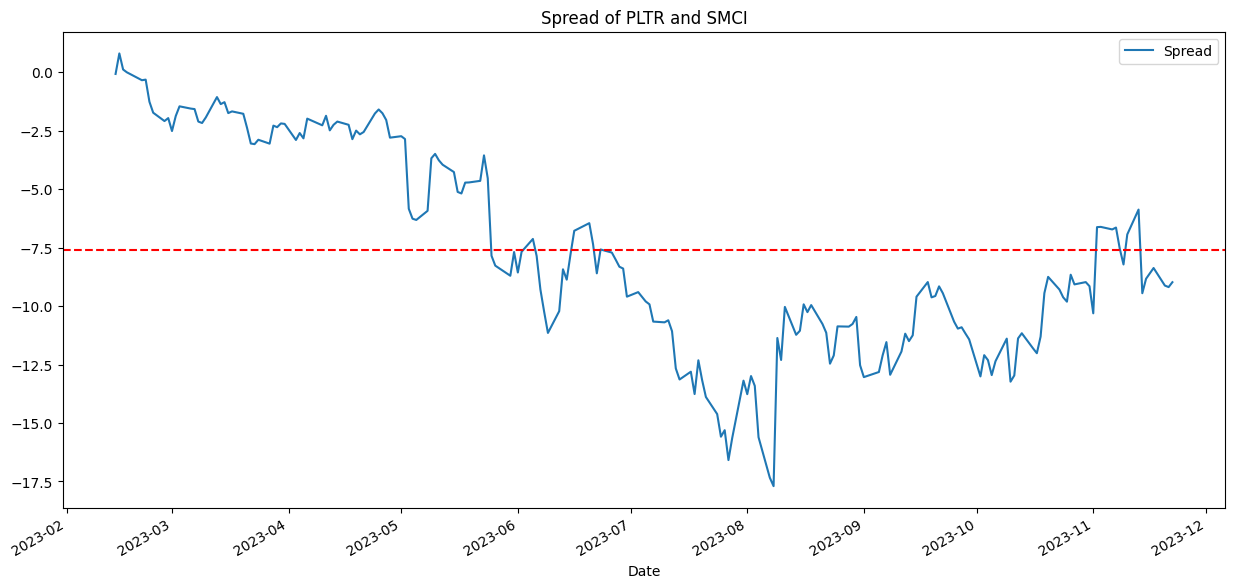

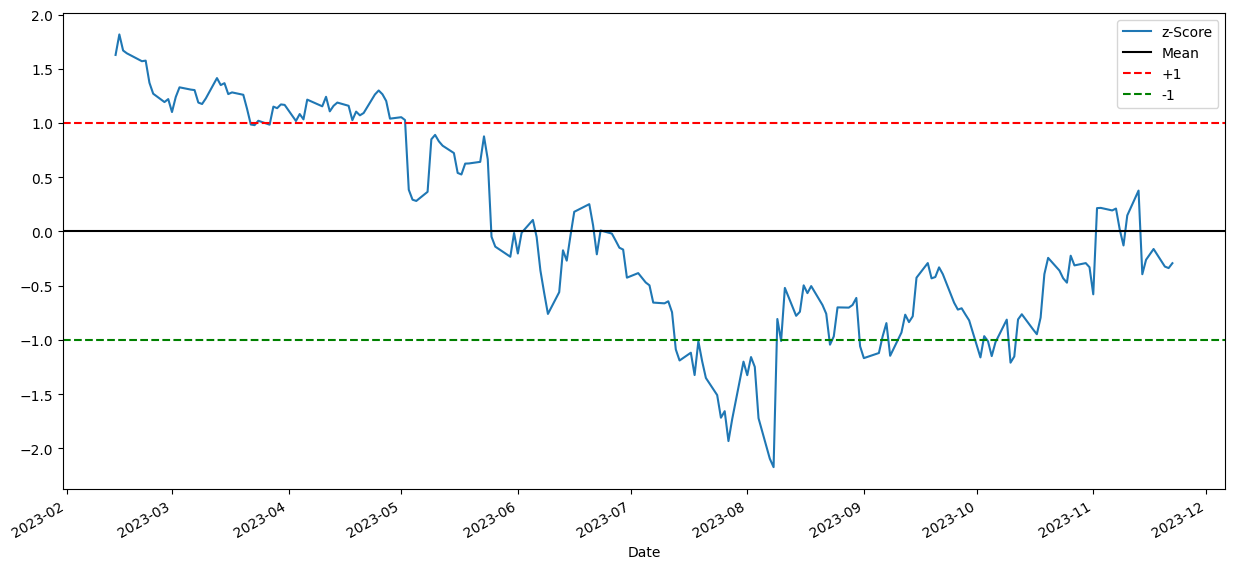

profit (raw price):  225.56905171733283


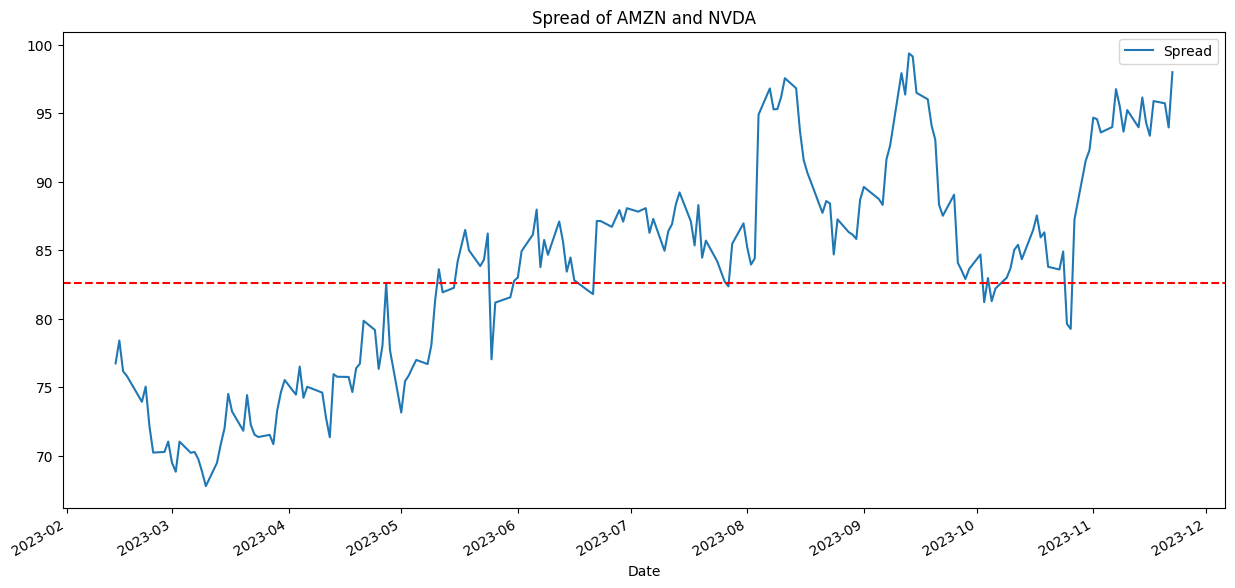

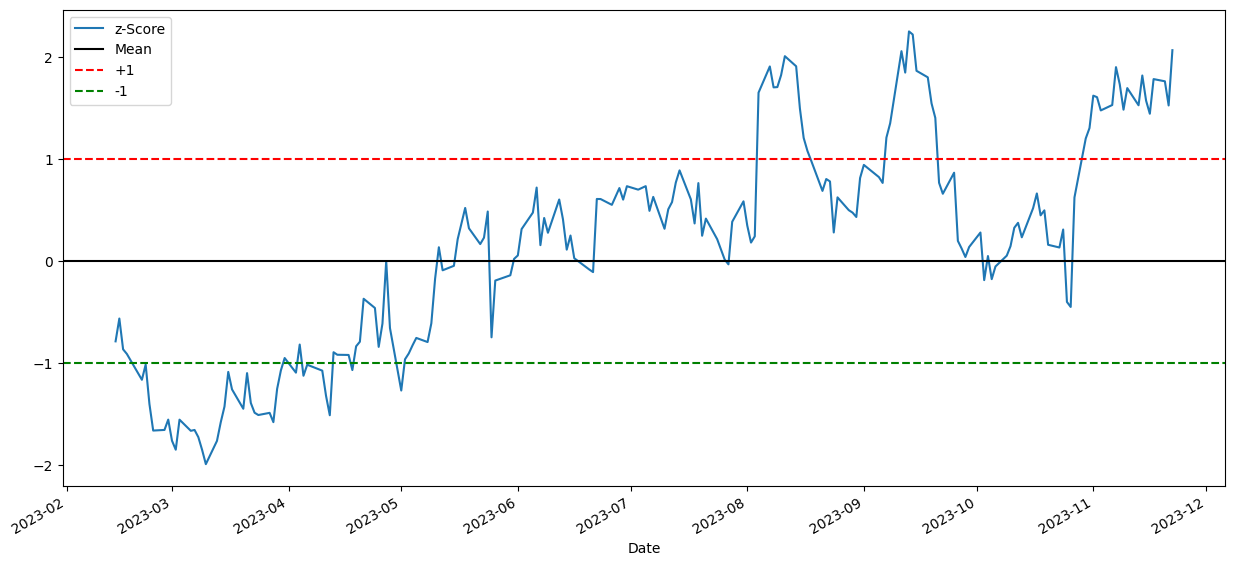

profit (raw price):  298.8052225012192


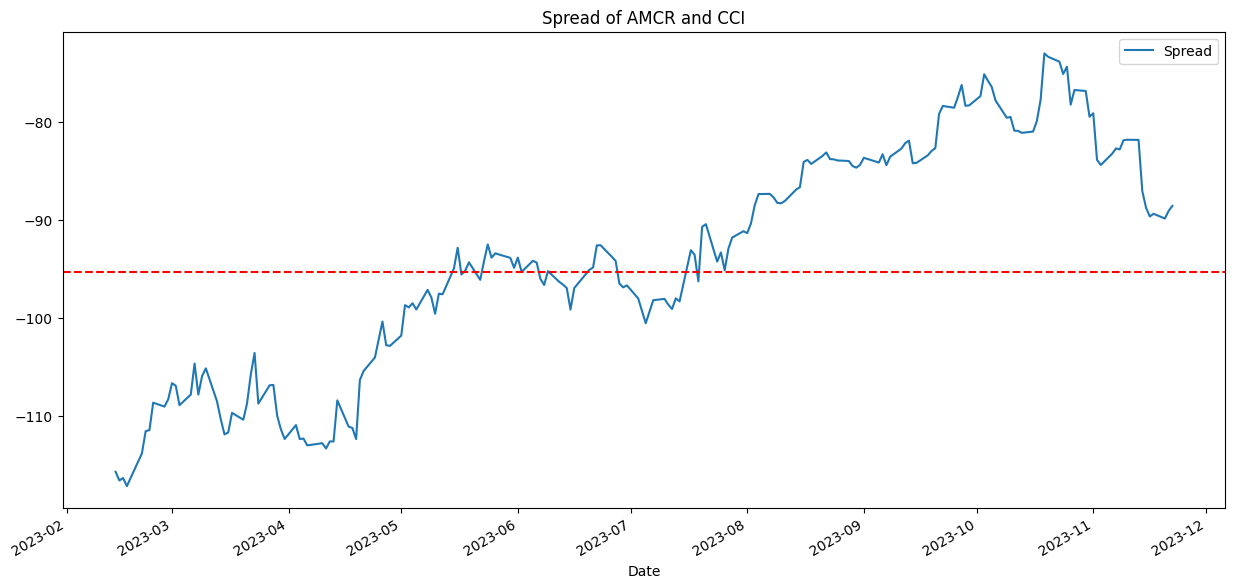

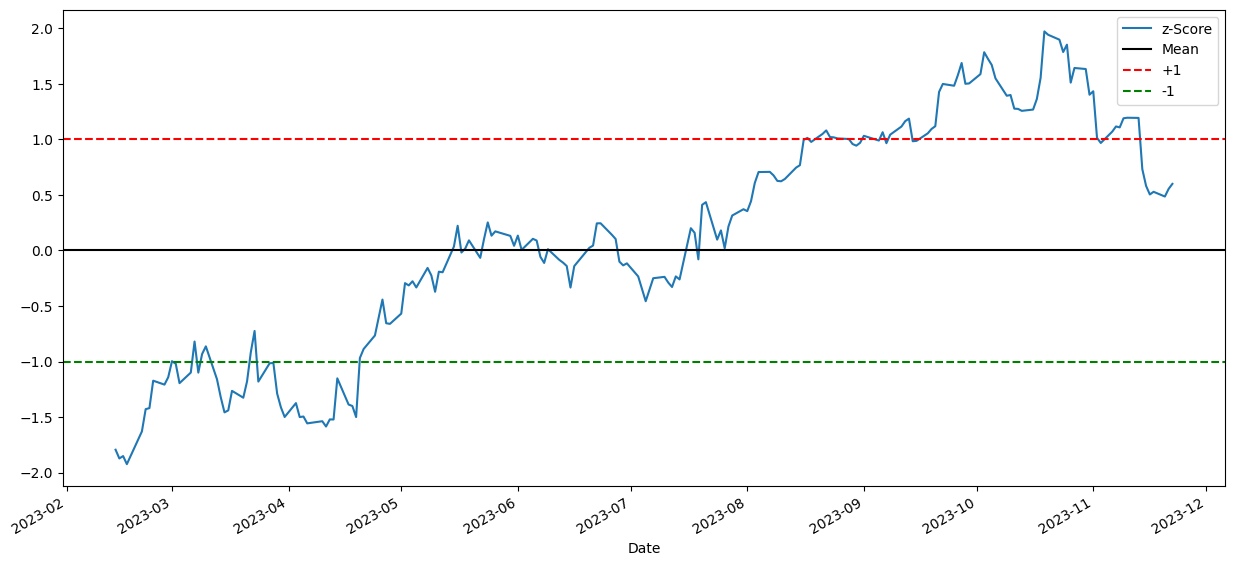

profit (raw price):  57.03894370740534


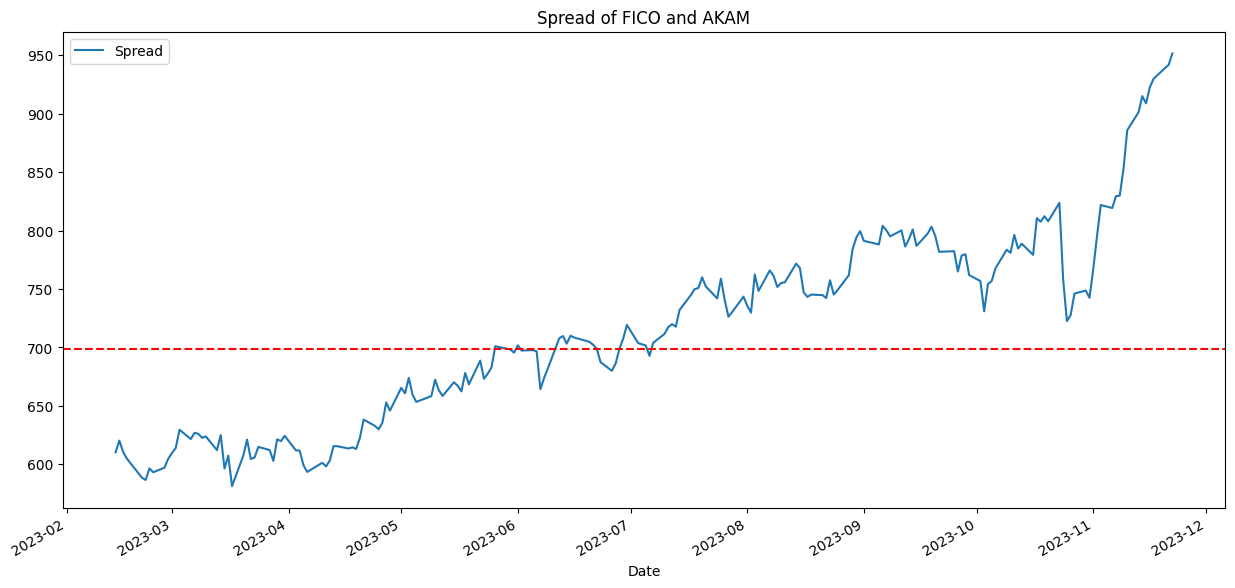

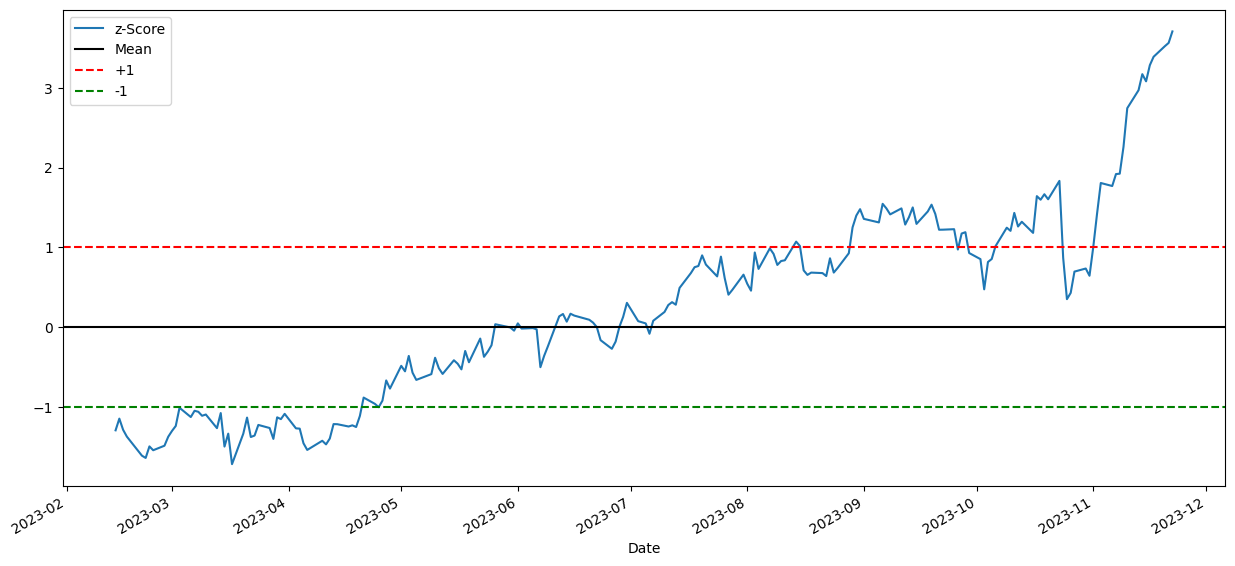

profit (raw price):  3013.136162521534


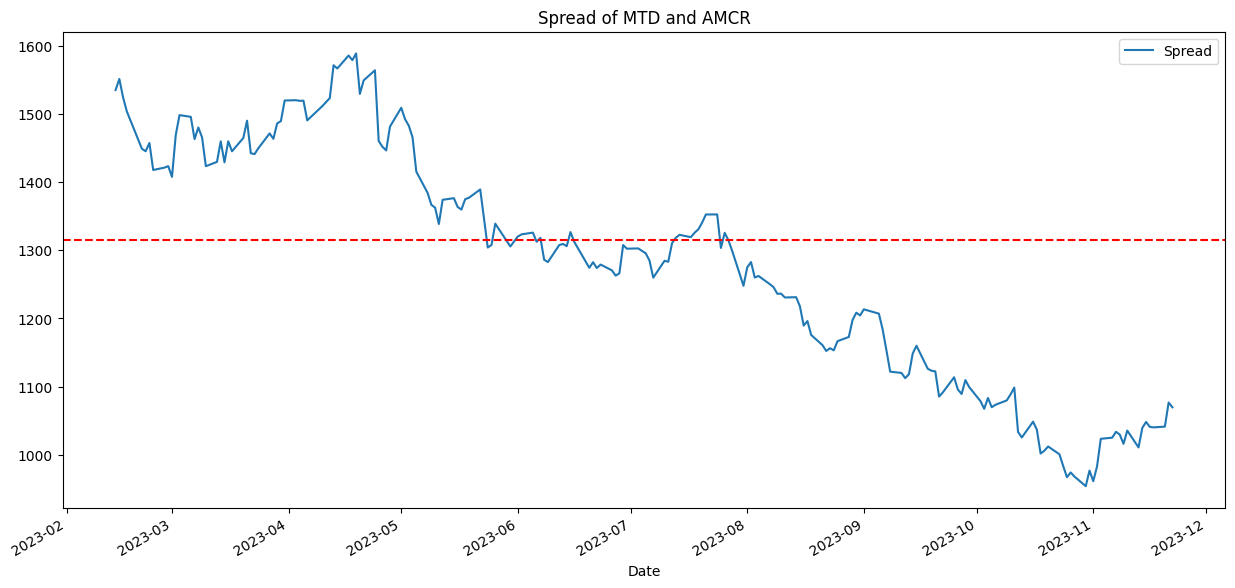

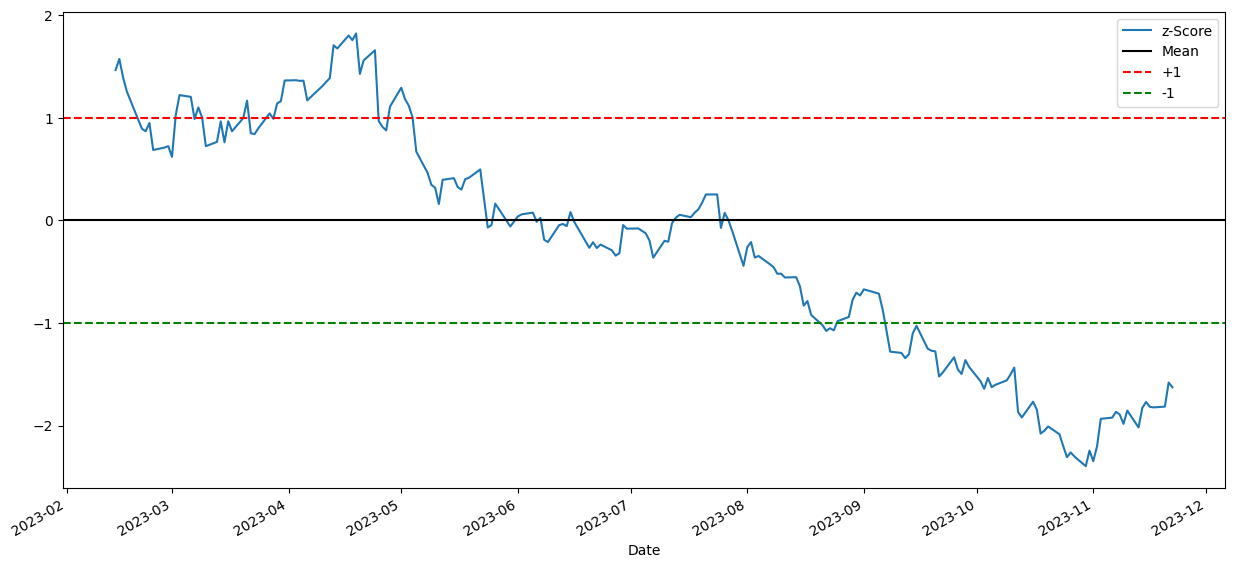

profit (raw price):  1677.9733266301837


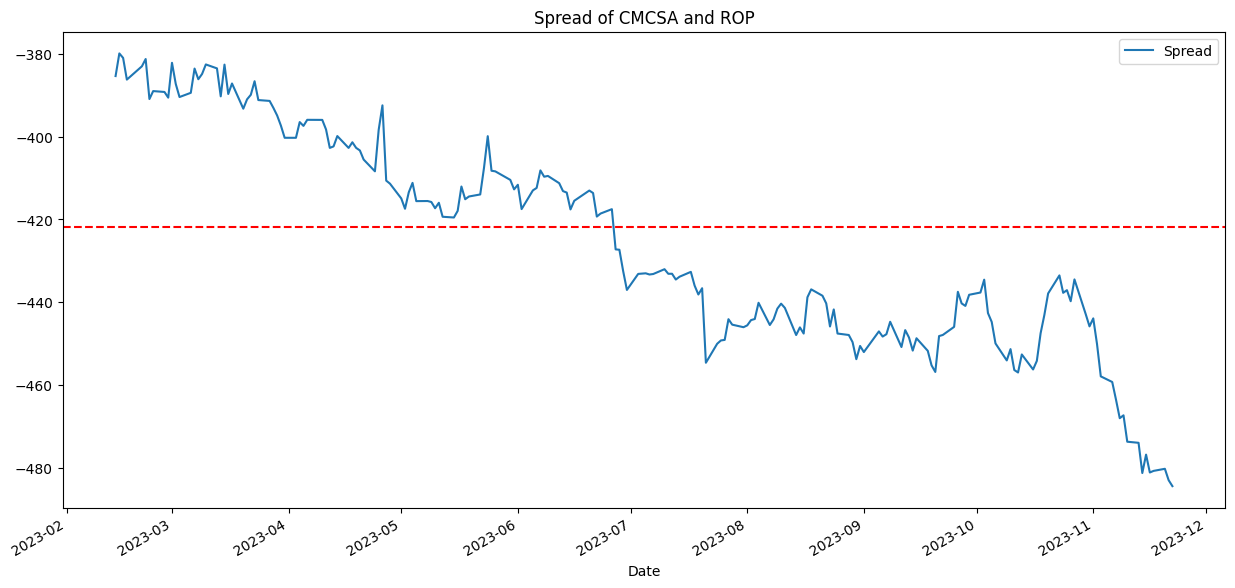

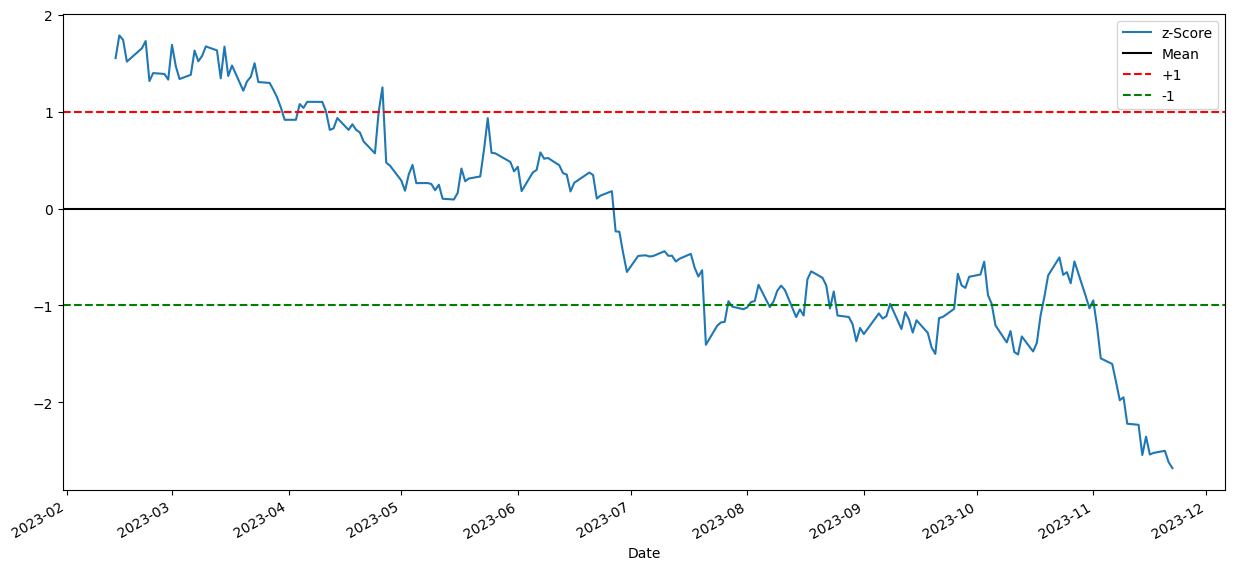

profit (raw price):  -47.82632619039373


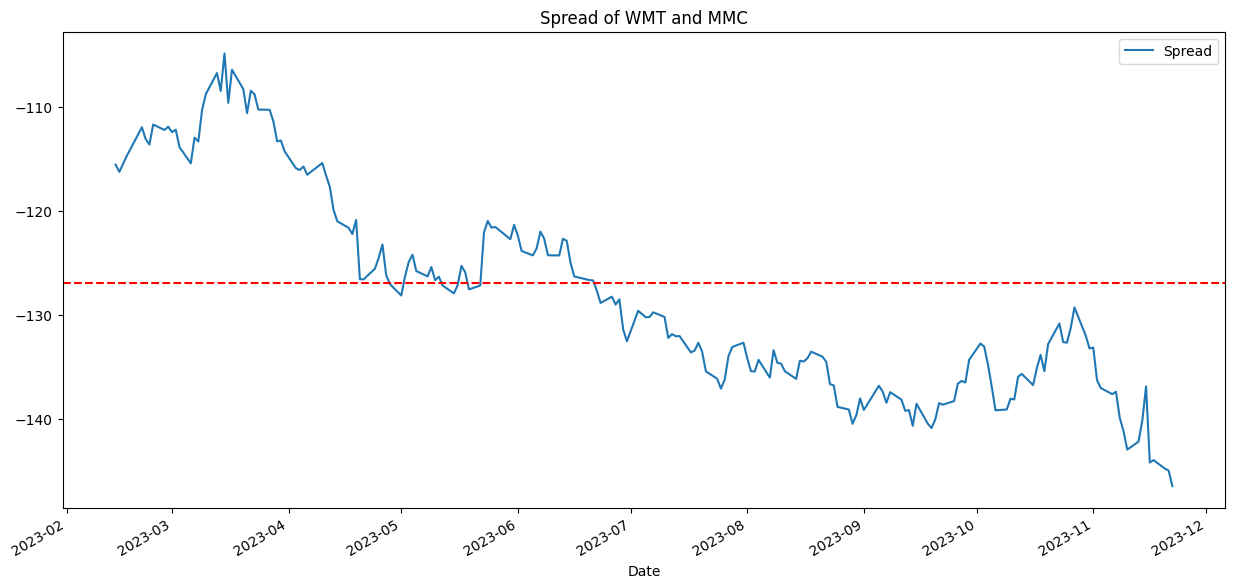

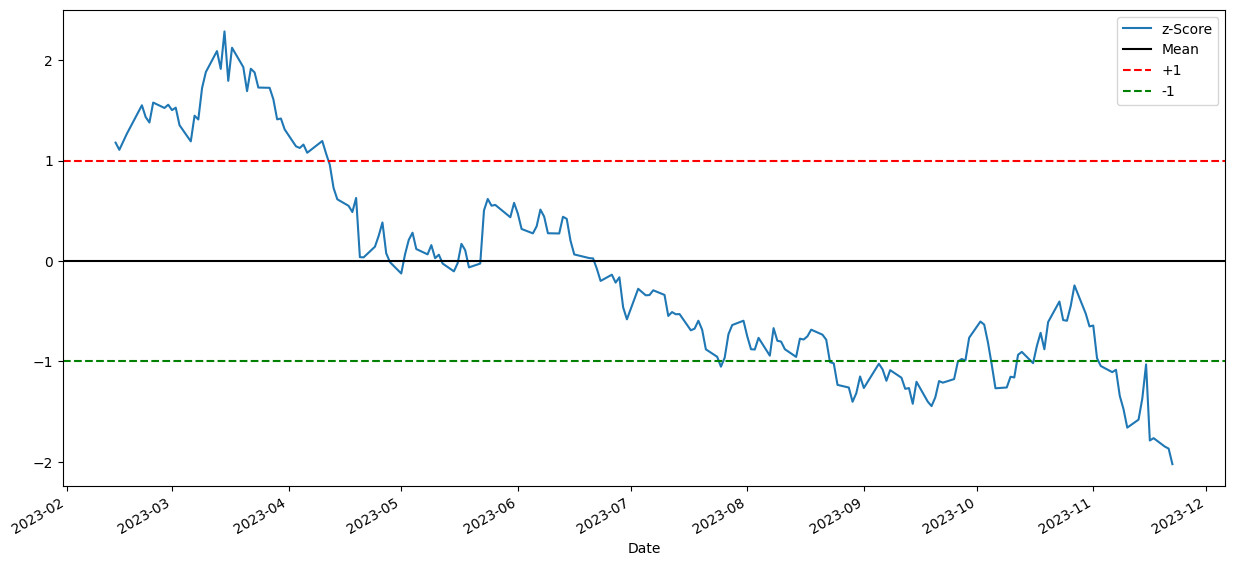

profit (raw price):  113.80606401449128


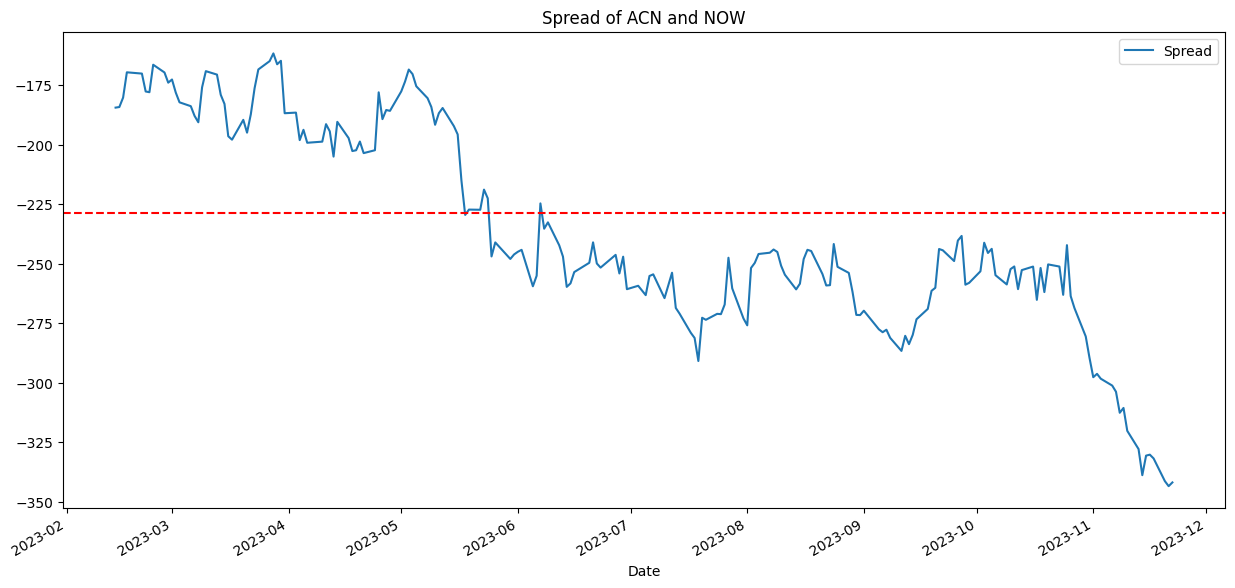

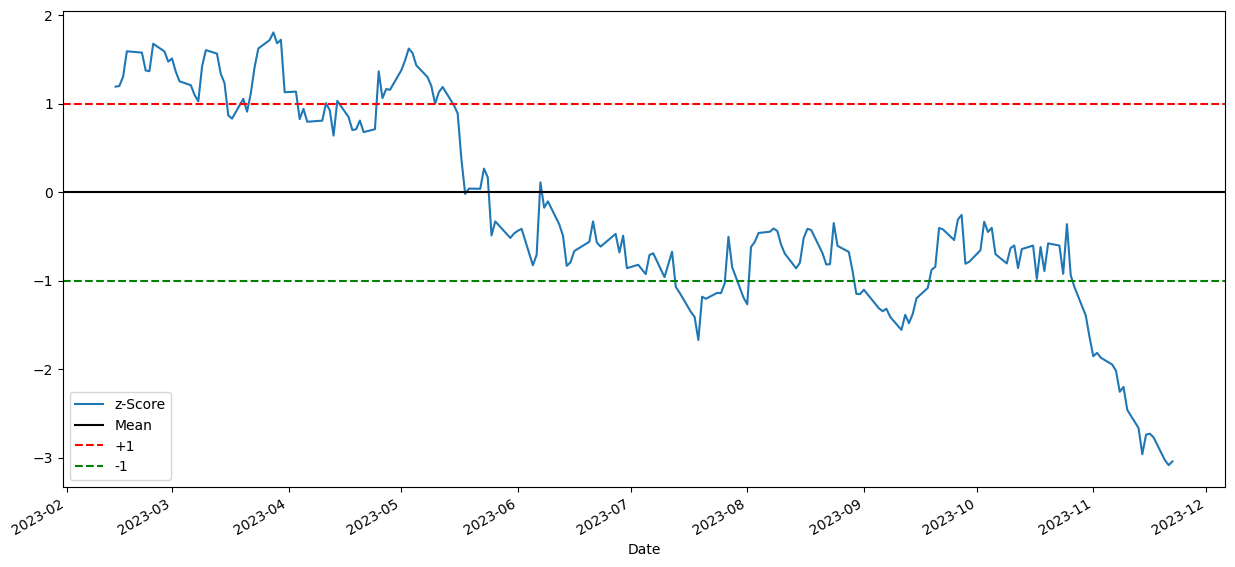

profit (raw price):  1063.1604875452124


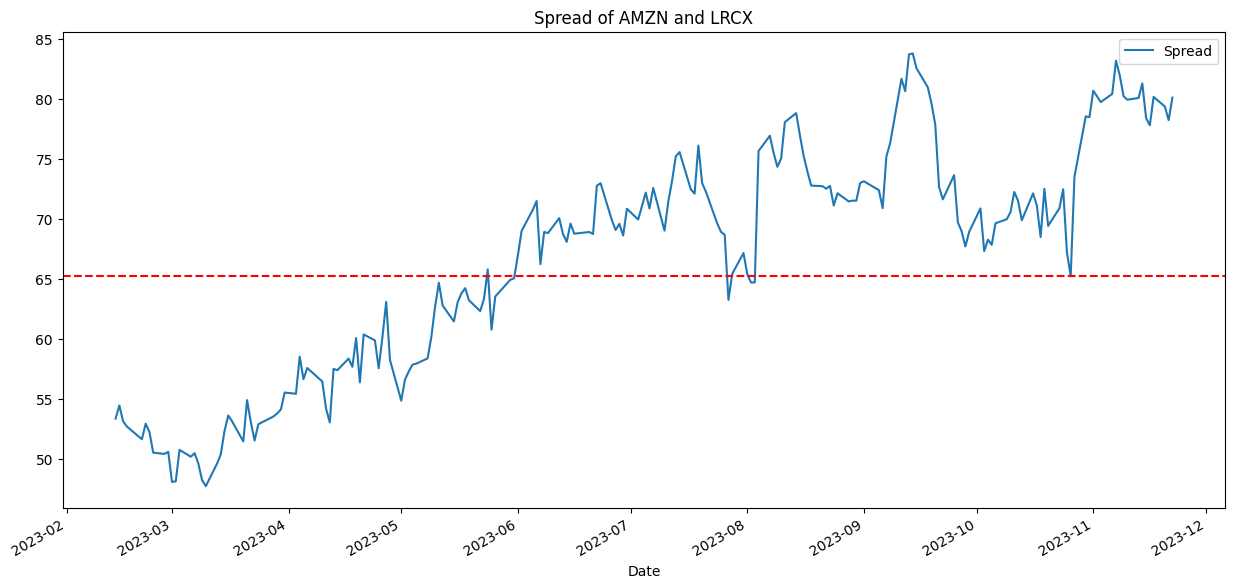

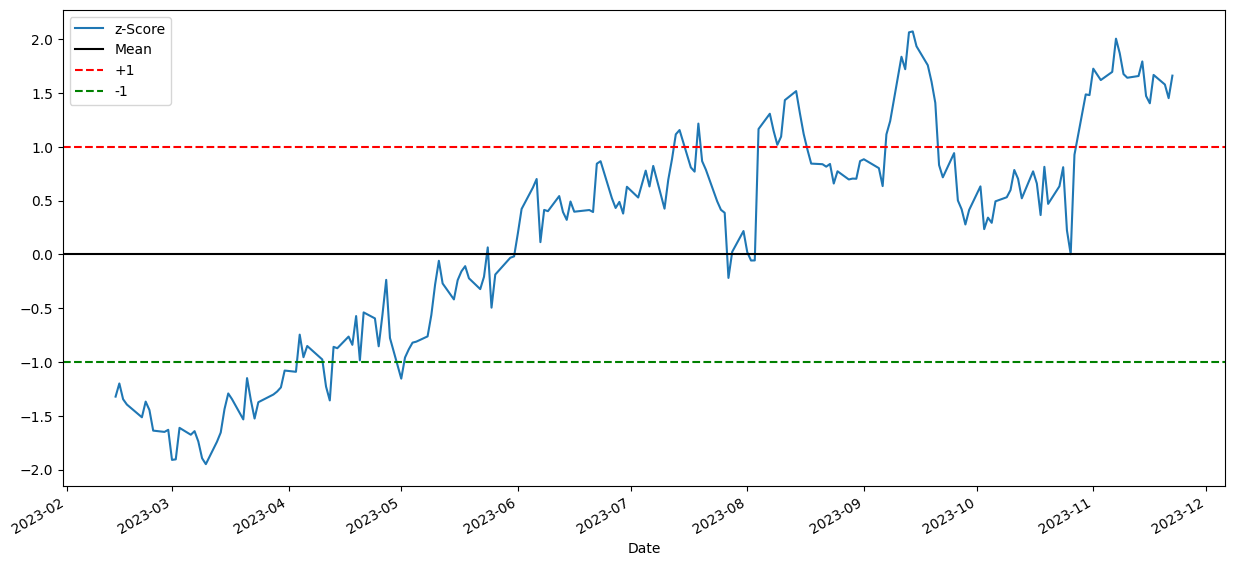

profit (raw price):  420.1978597361699


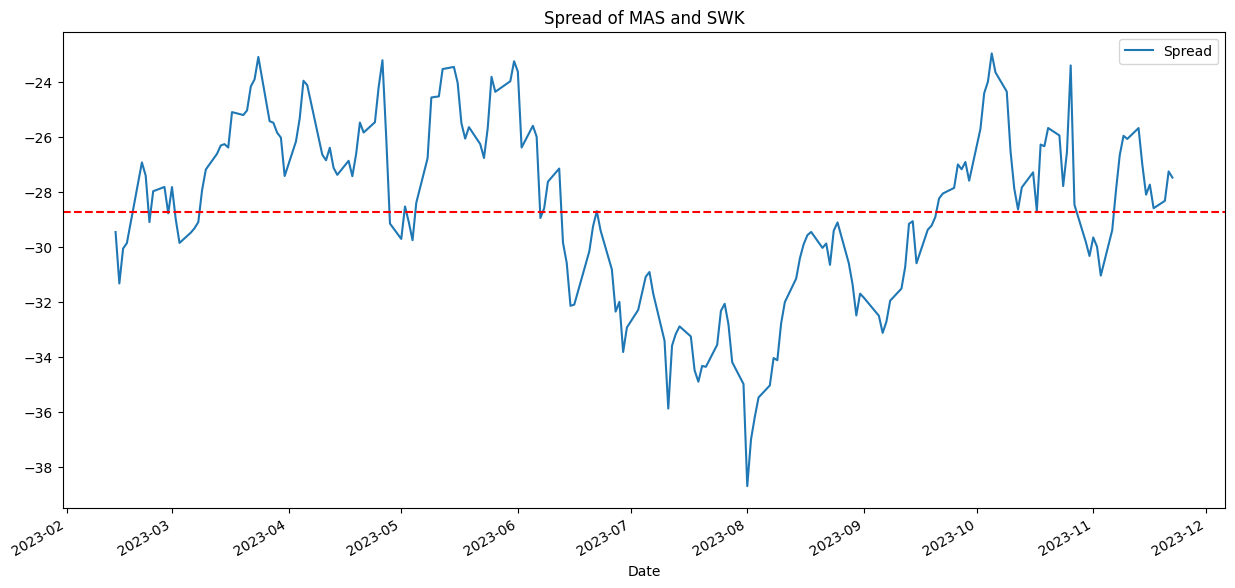

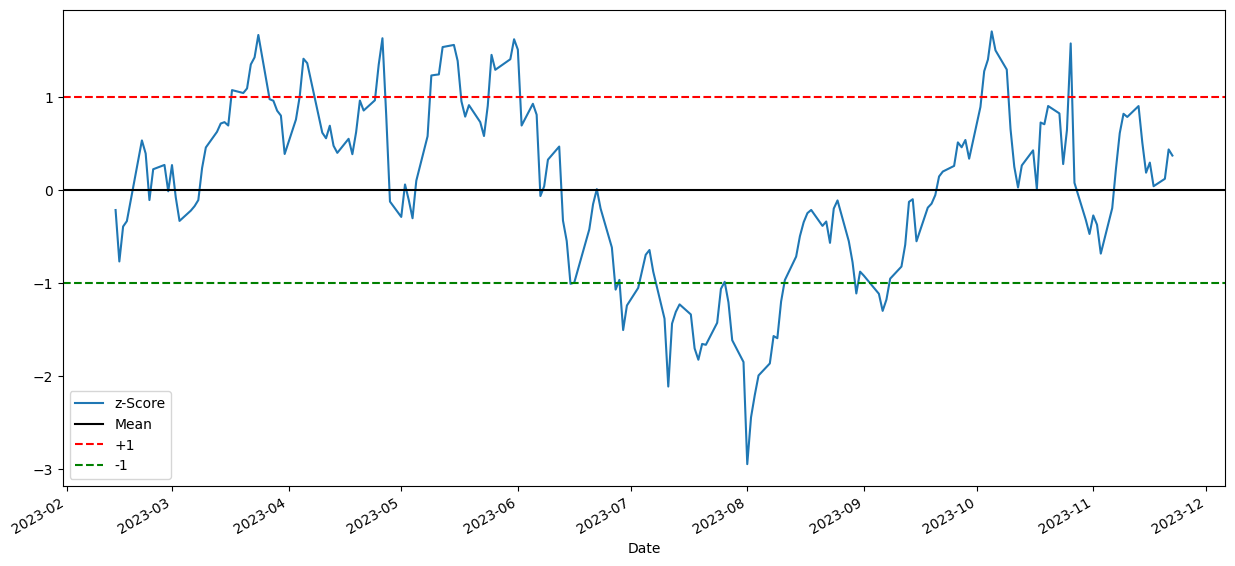

profit (raw price):  128.8614527471587


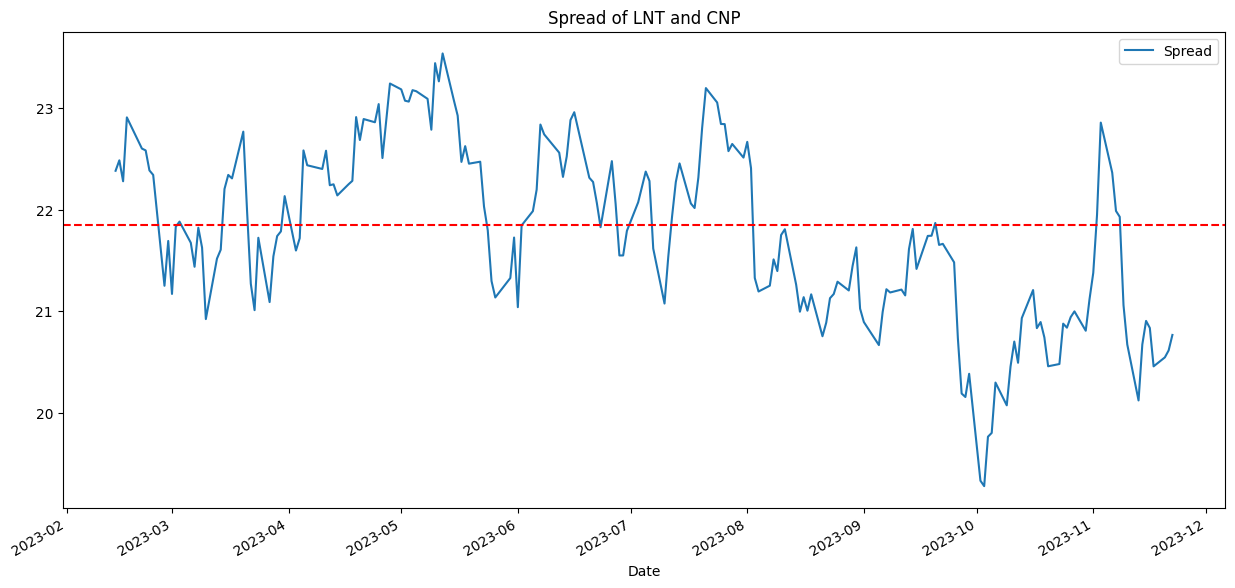

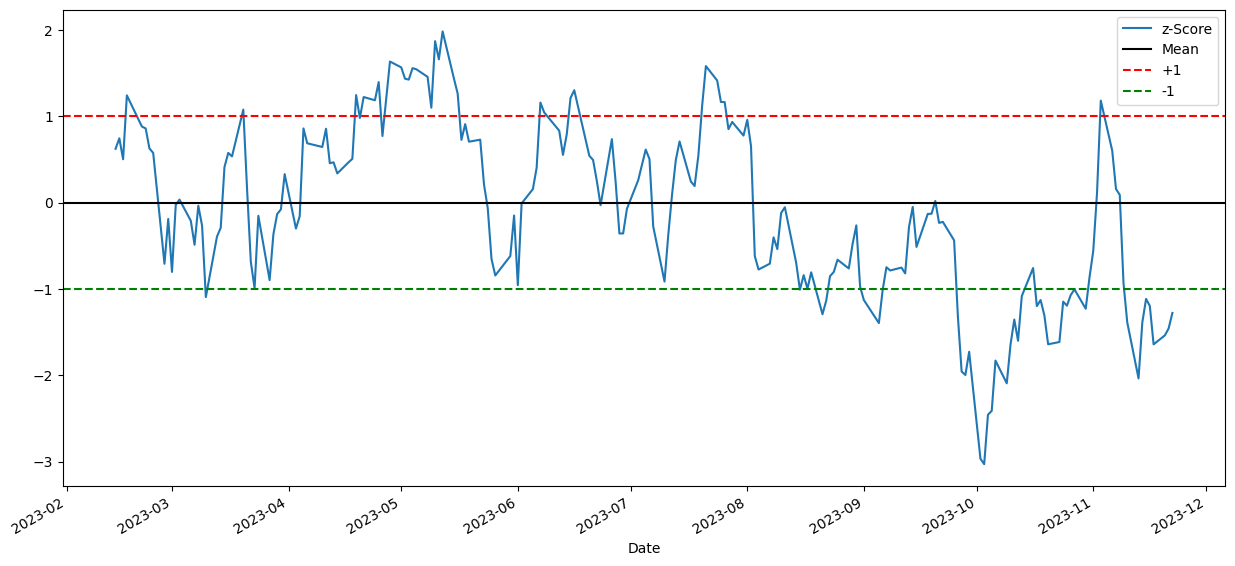

profit (raw price):  37.486260329593925


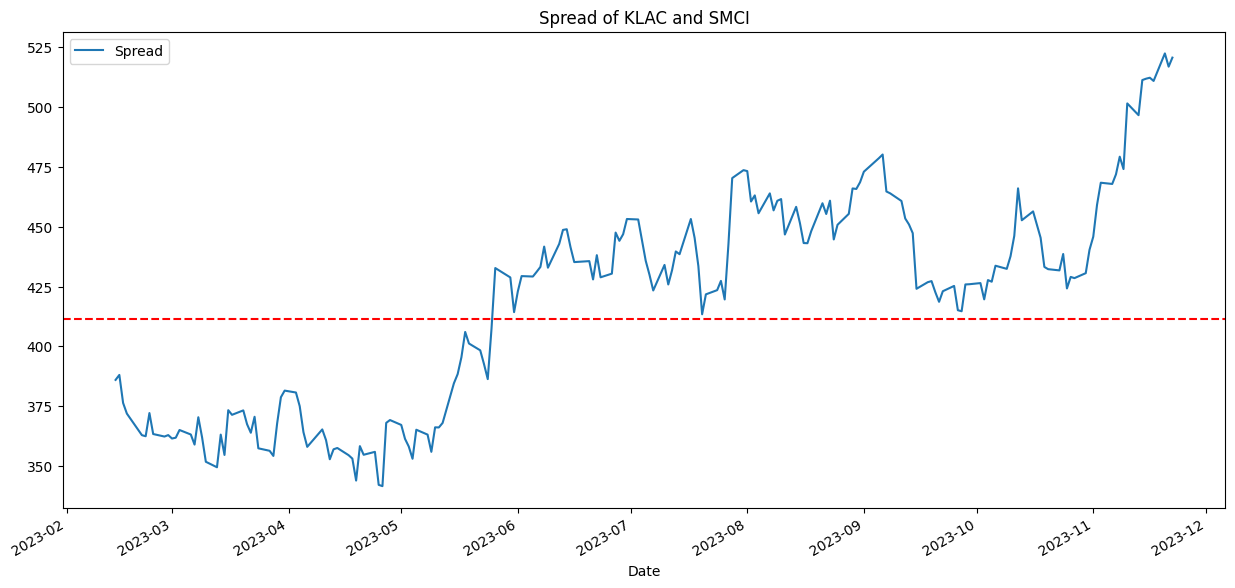

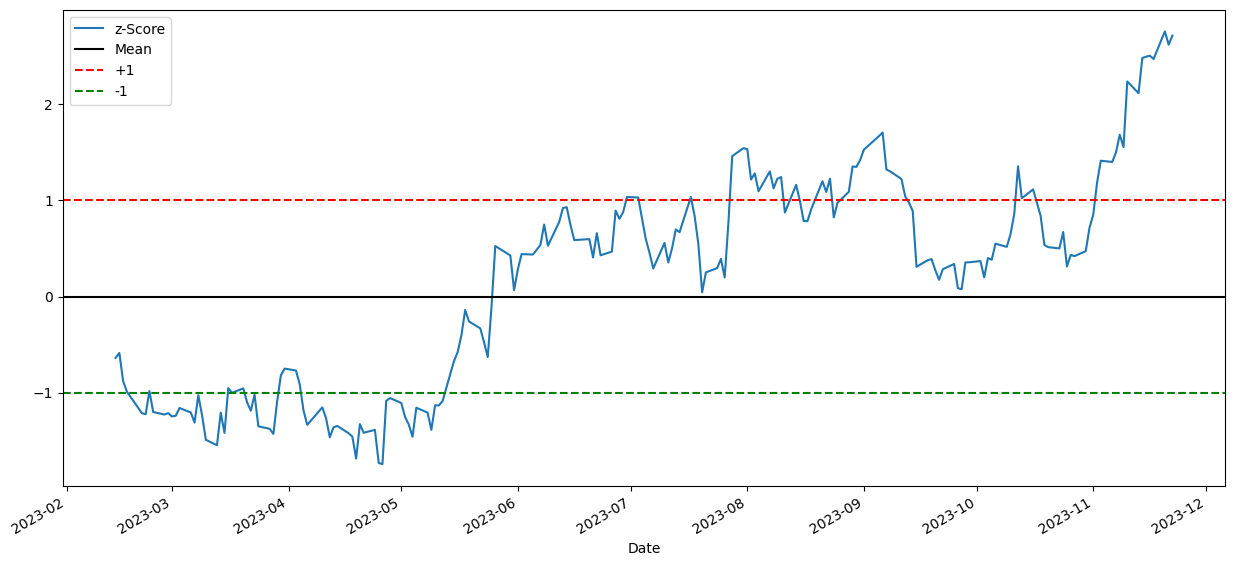

profit (raw price):  -7150.934916281985


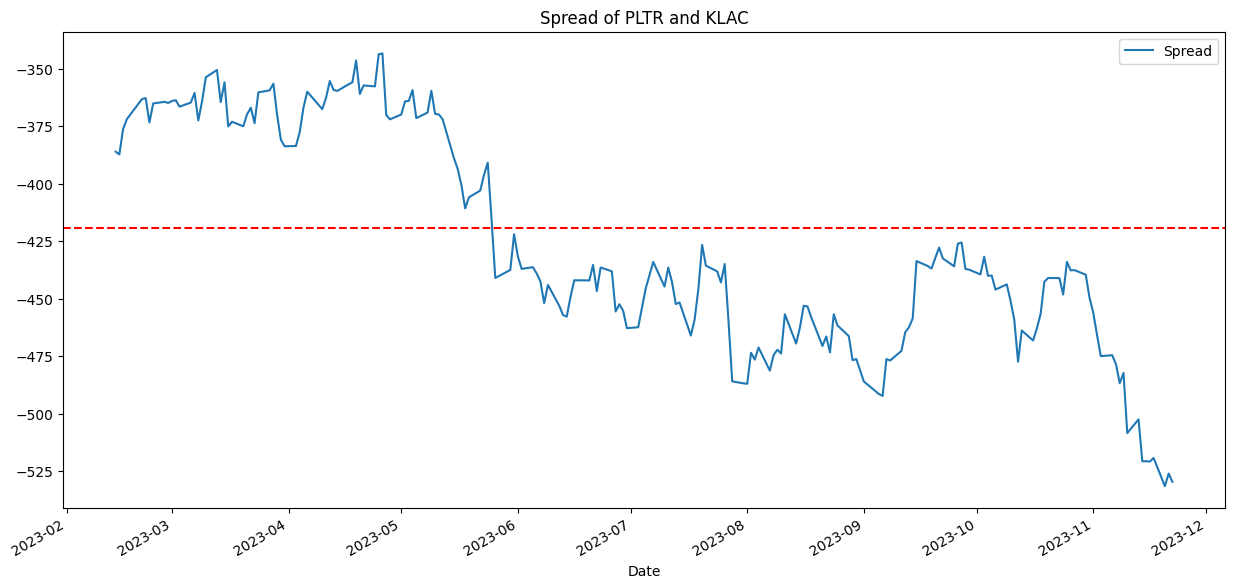

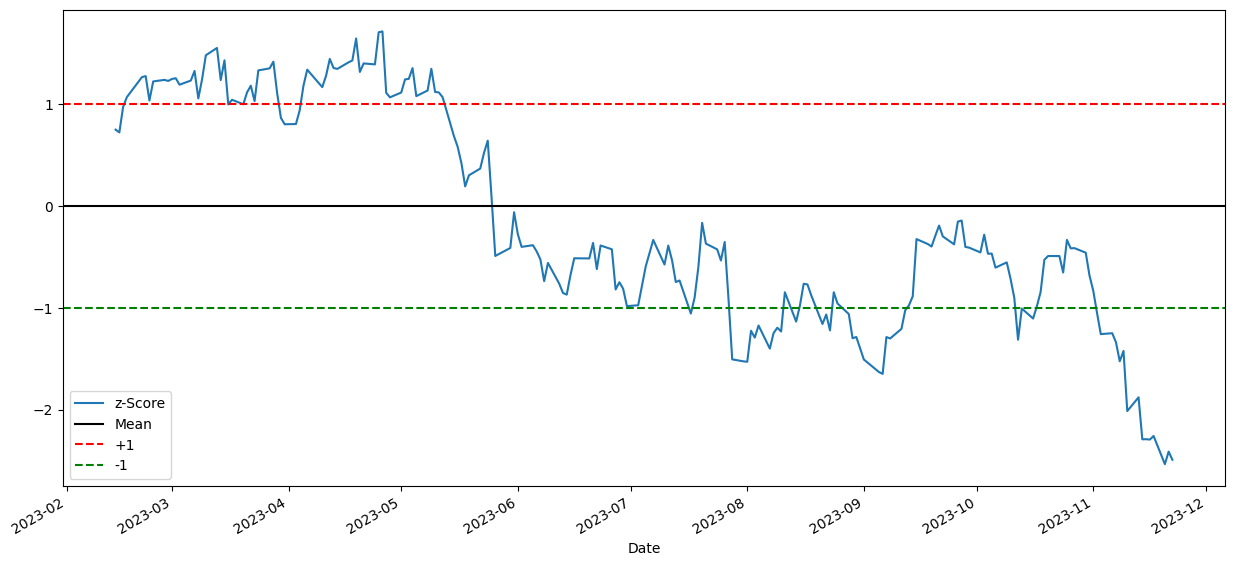

profit (raw price):  -49.207180567852454


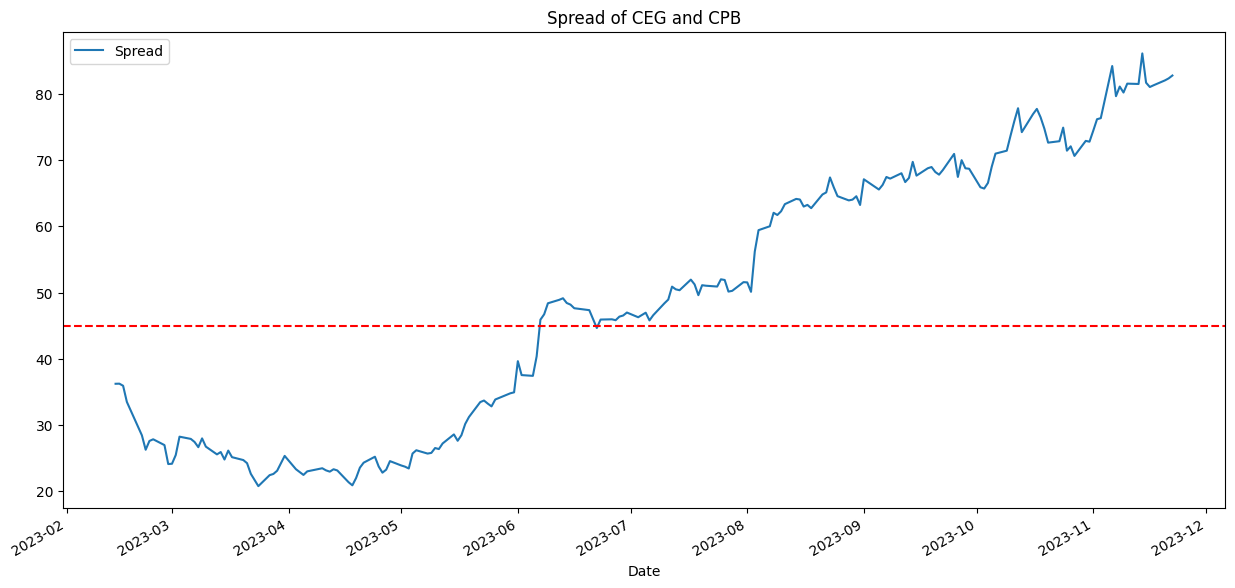

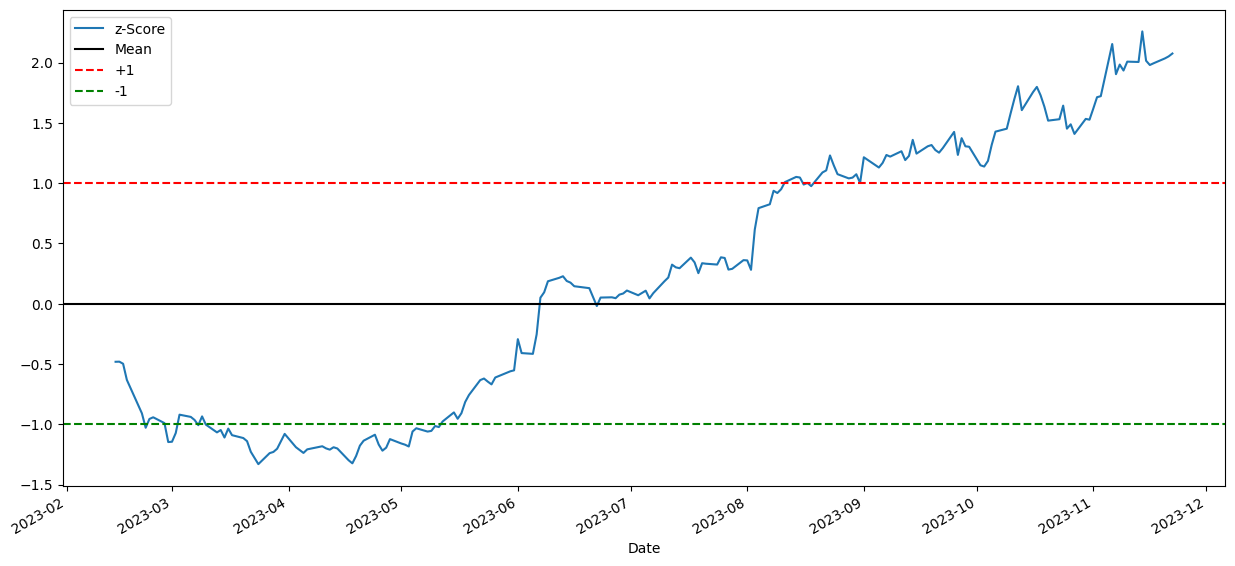

profit (raw price):  837.6587805728191


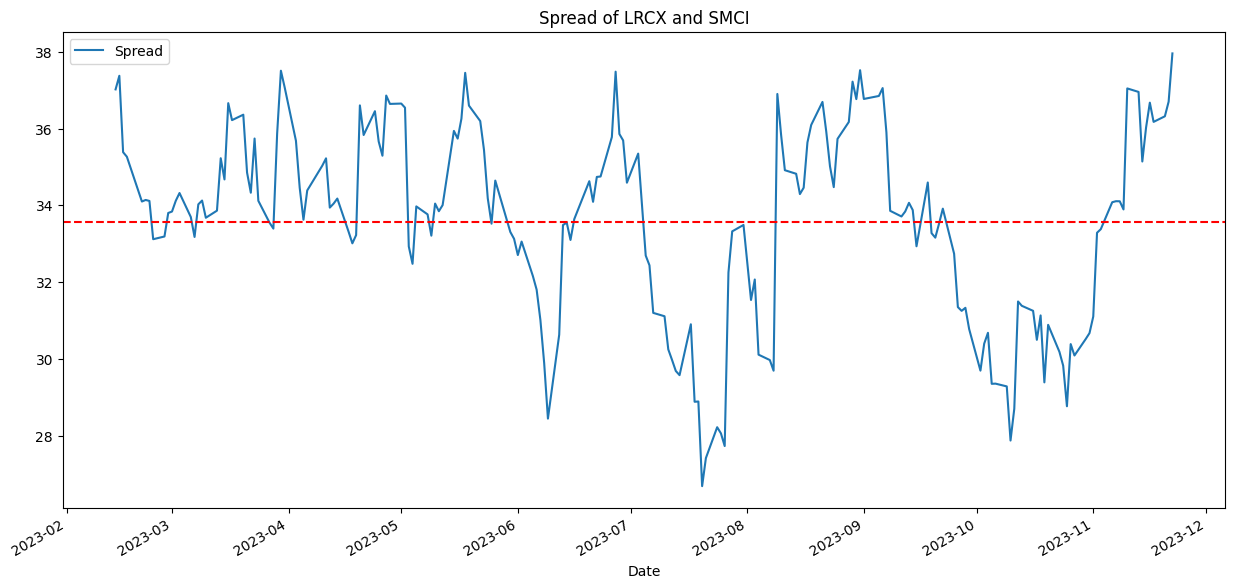

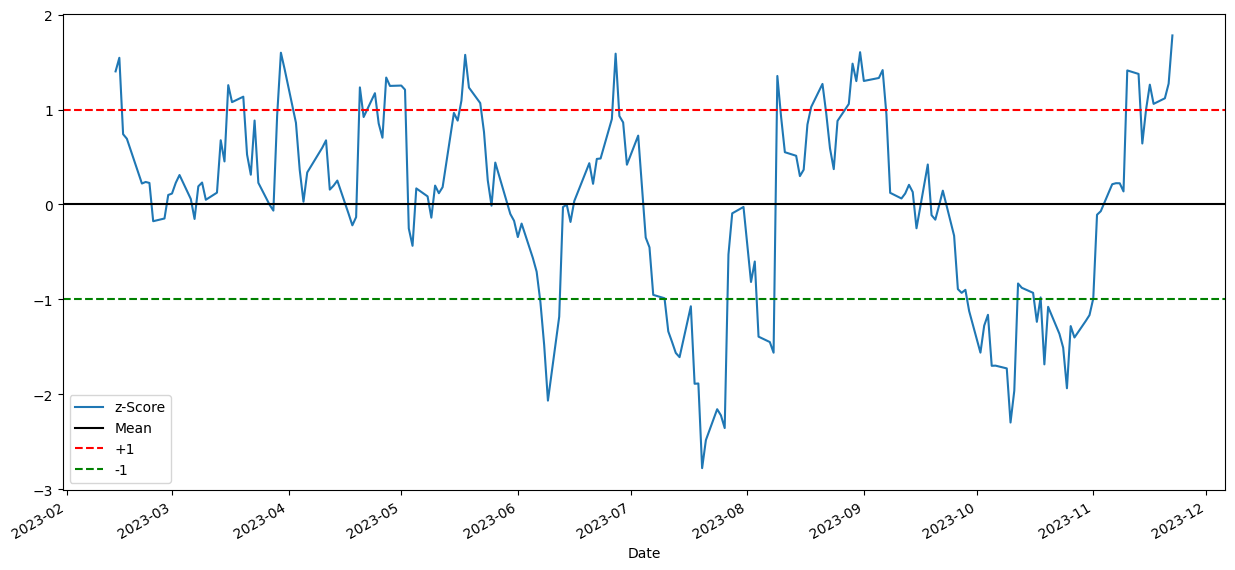

profit (raw price):  364.1543480710735


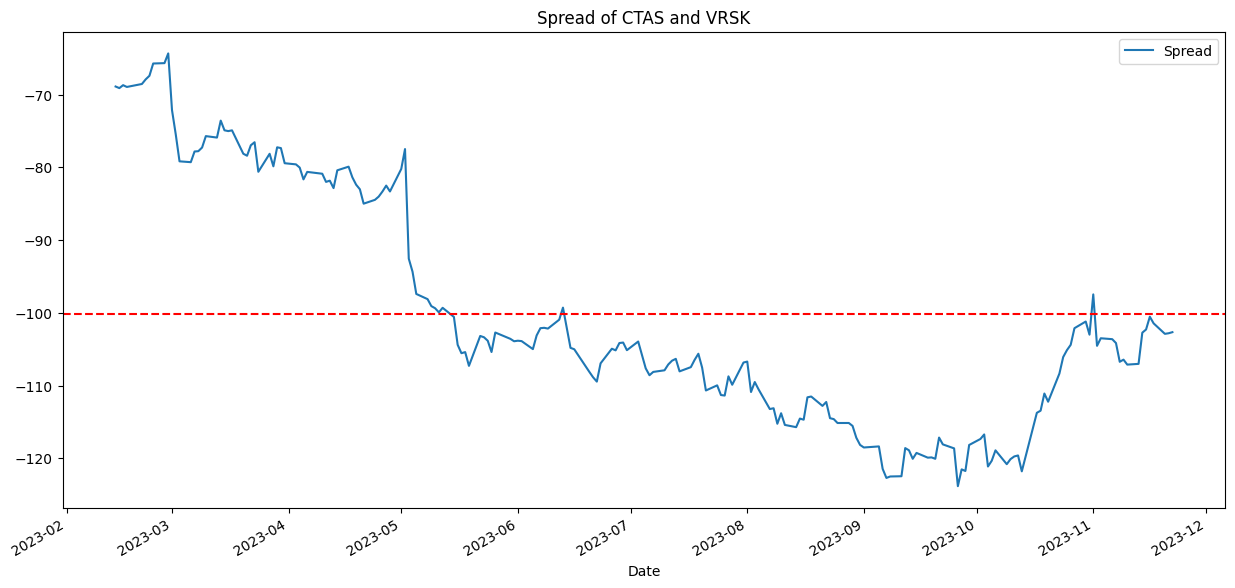

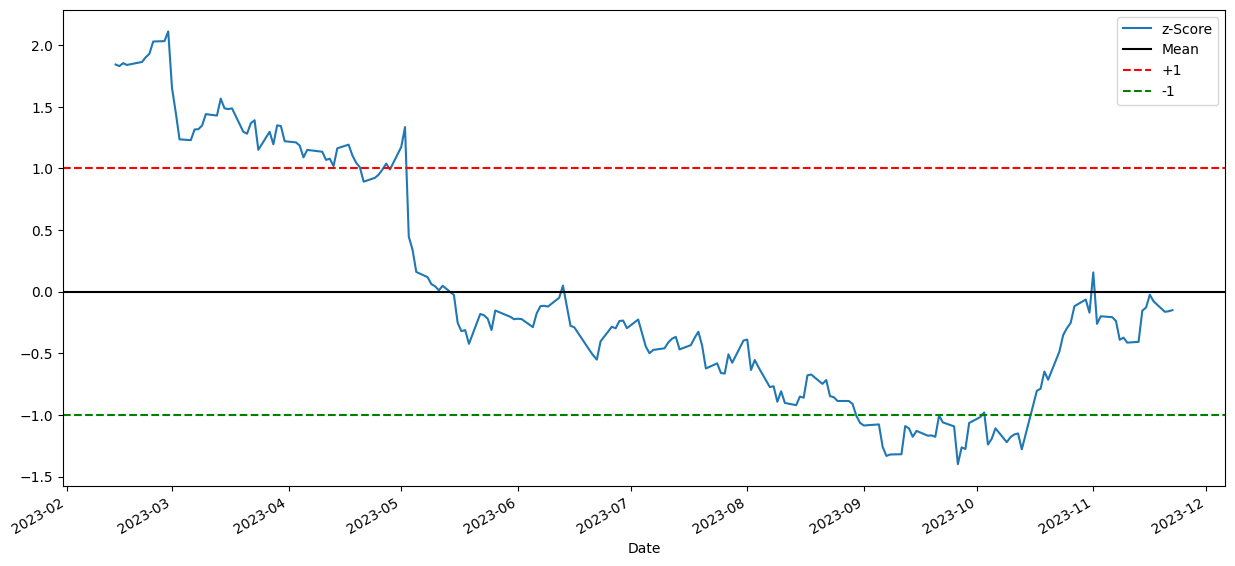

profit (raw price):  577.3177903286728


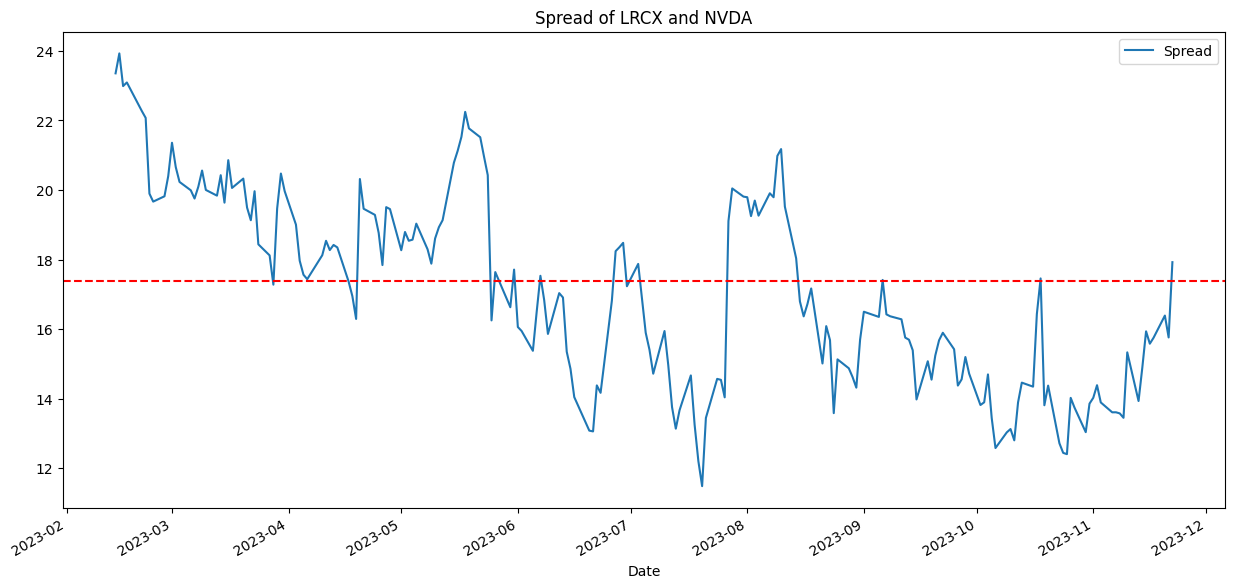

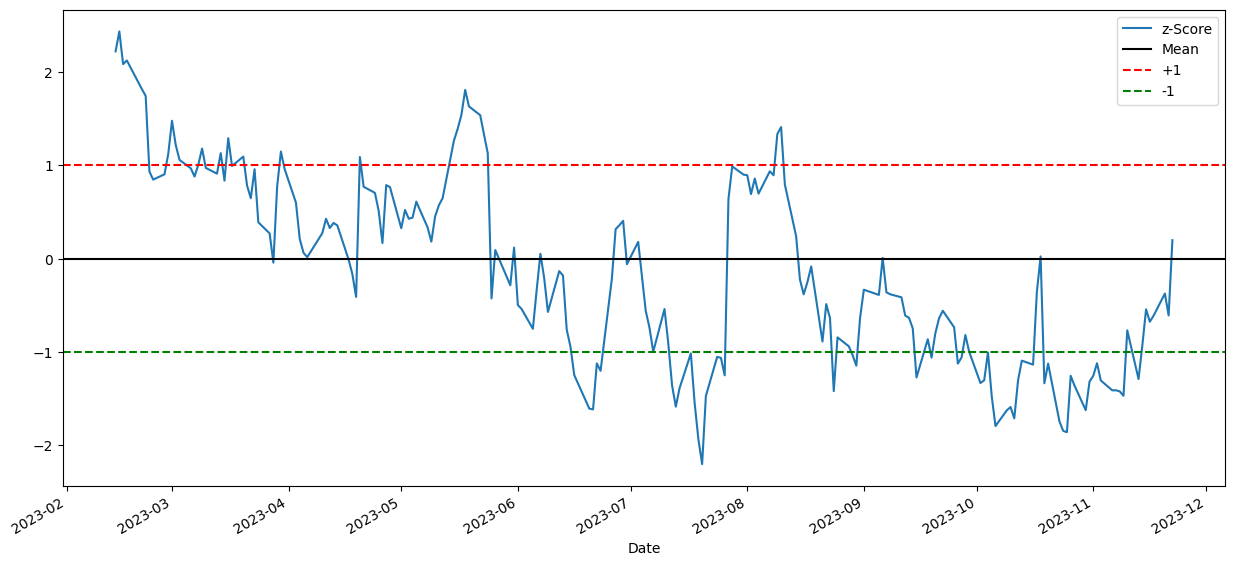

profit (raw price):  328.27747706612786


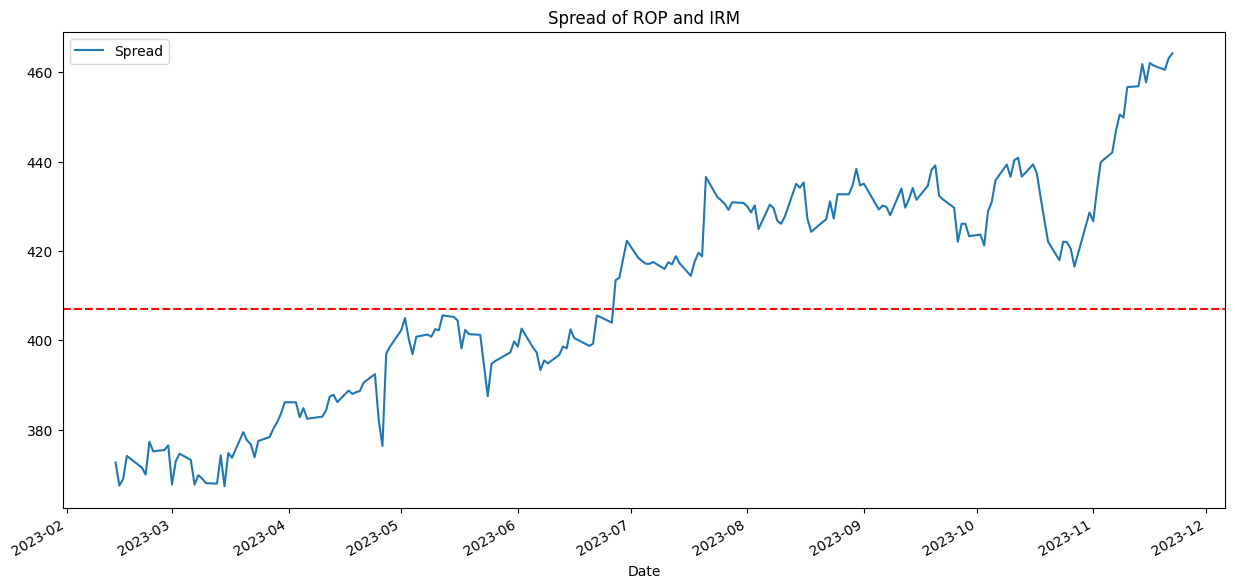

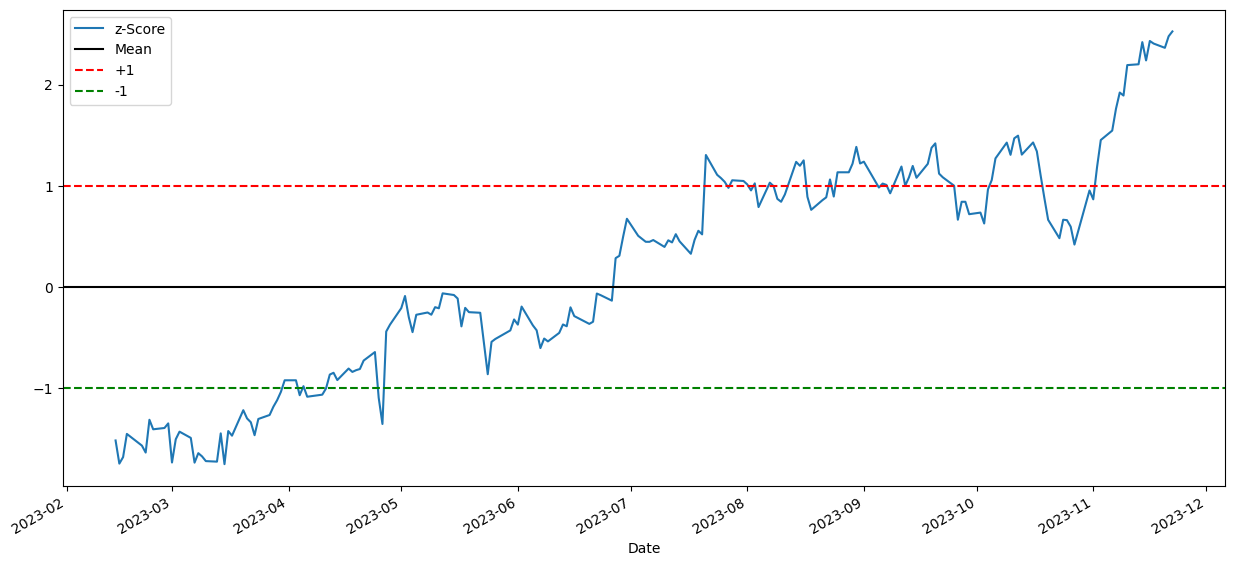

profit (raw price):  14.939869954523601


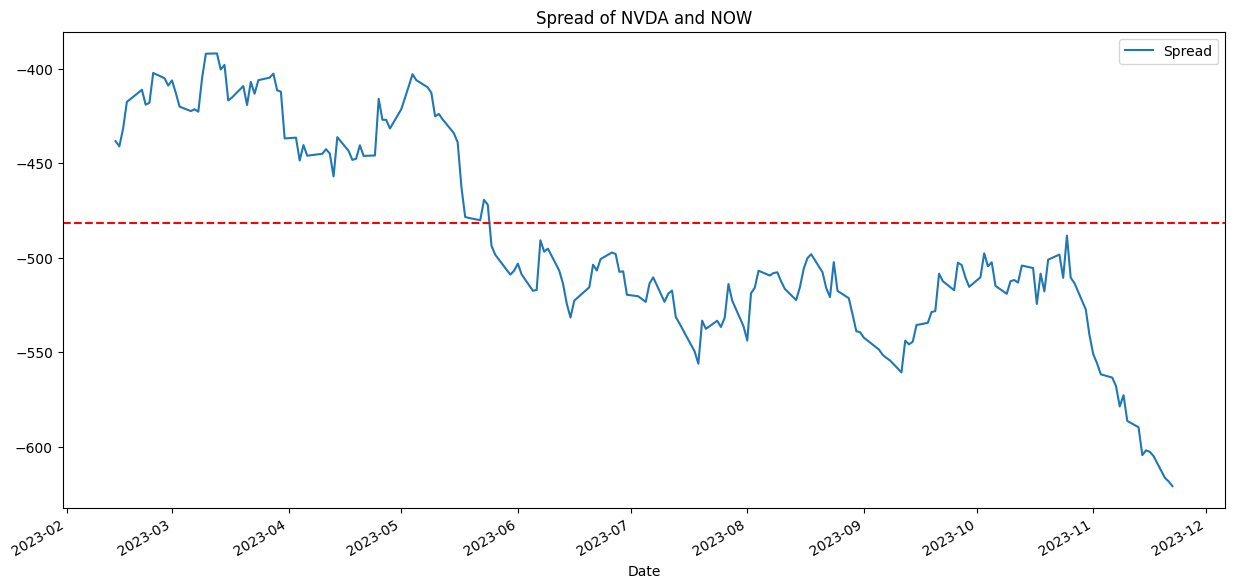

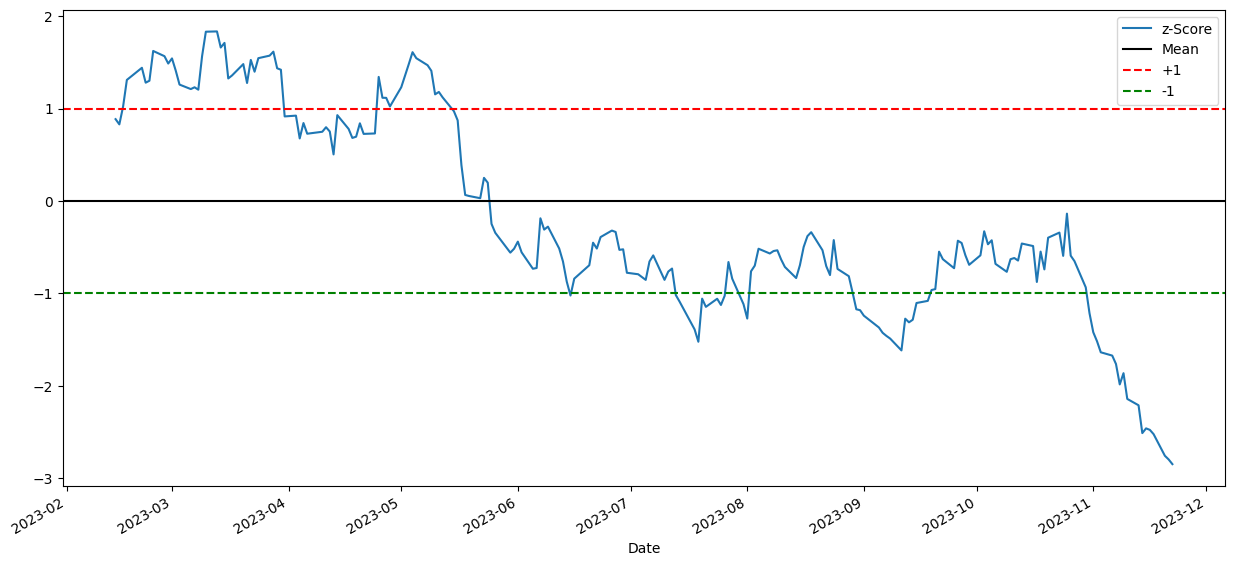

profit (raw price):  -72.39195336697108


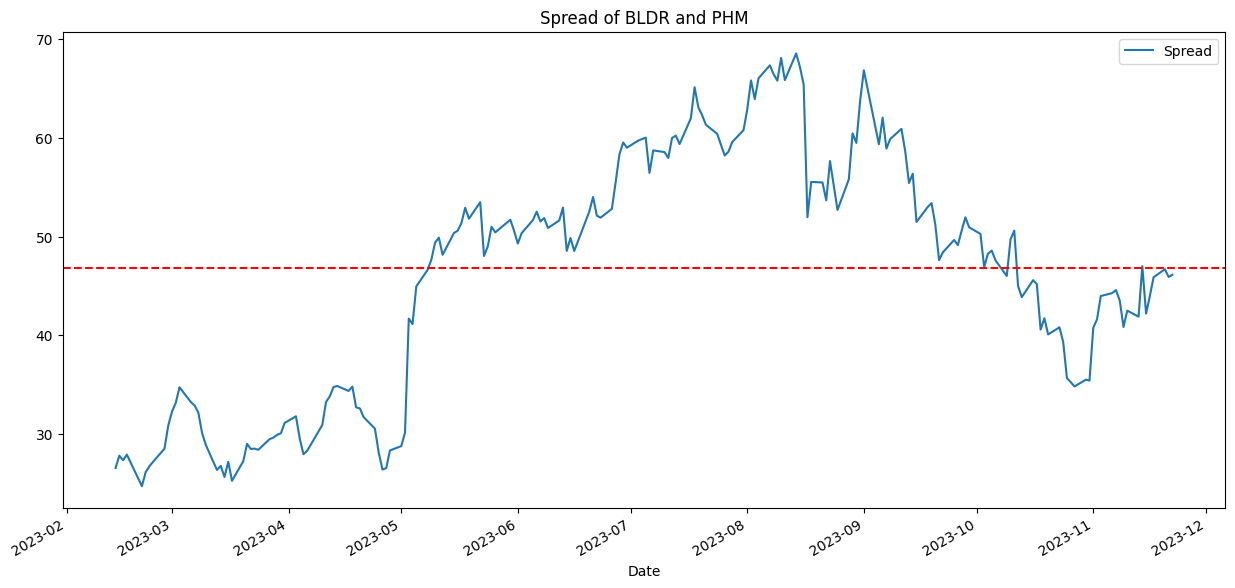

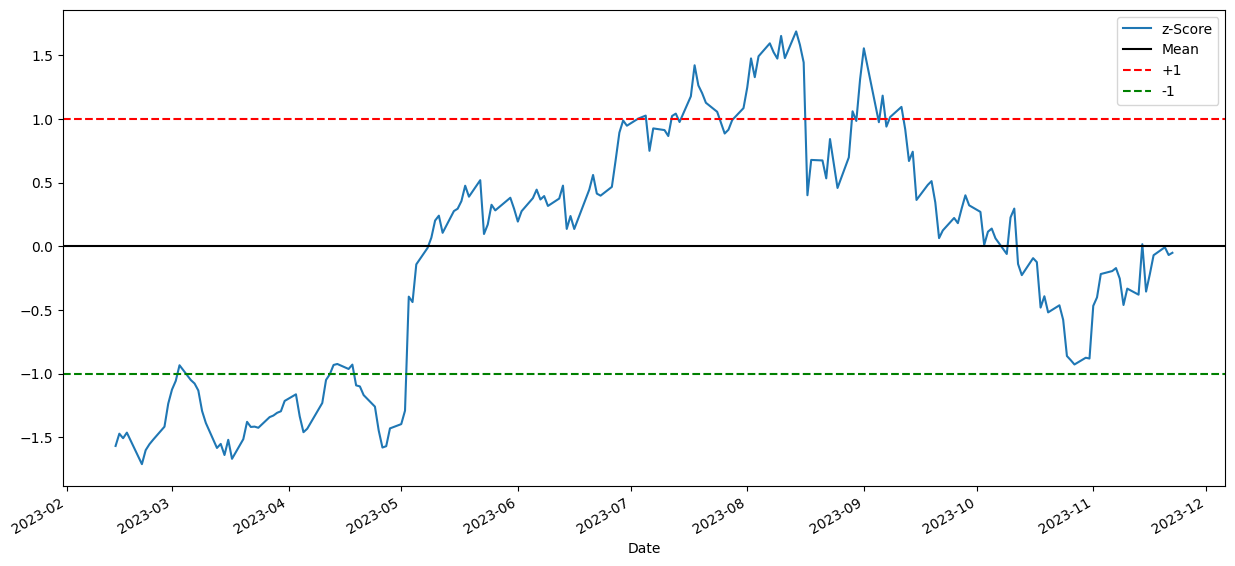

profit (raw price):  642.897748573864


In [ ]:
def extract_date(filename):
        """
        Extracts the formation end date from the pairs_file name and determines the start date for trading.
        """
        formation_start = filename.split("_")[1]
        formation_end = filename.split("_")[2]  # Assuming "pairs_STARTDATE_ENDDATE.csv"
        formation_end_date = datetime.strptime(formation_end.split(".csv")[0], "%Y-%m-%d")
        formation_end_date = pd.to_datetime(formation_end_date, utc=True)
        formation_start_date = pd.to_datetime(formation_start, utc=True)
        return formation_start_date, formation_end_date


def trade_pairs_distance(filename, trading_horizon_days=180, plot='off'):
        """
        Executes the distance method trading strategy for top 5 pairs in the pairs file within a defined trading period.
        """
        start_formation, end_formation = extract_date(filename)
        start_date = end_formation + timedelta(days=1)
        trading_horizon = timedelta(days=trading_horizon_days)
        money_list = []
        end_date = start_date + trading_horizon
        end_date = pd.to_datetime(end_date, utc=True)
        pairs = pd.read_csv(filename)
        pairs.iloc[:5]
        for _, row in pairs.iterrows():
            asset1_name, asset2_name = row["Asset 1"], row["Asset 2"]
            asset1 = df[asset1_name].loc[start_formation:end_date]
            asset2 = df[asset2_name].loc[start_formation:end_date]
            ratio = asset1/asset2
            spread = asset1 - asset2
            static_mean = spread.loc[start_formation:end_formation].mean()
            static_std = spread.loc[start_formation:end_formation].std()
            zscore1 = (spread - static_mean)/static_std

            ##plot
            if plot == 'on':
                spread.plot(figsize=(15,7))
                plt.axhline(y=static_mean, color='red', linestyle='--', label='Mean')
                plt.legend(['Spread'])
                plt.title(f'Spread of {asset1_name} and {asset2_name}')
                plt.show()
                
                plt.figure(figsize=(15,7))
                zscore1.plot()
                plt.axhline(0, color='black')
                plt.axhline(1.0, color='red', linestyle='--')
                plt.axhline(-1.0, color='green', linestyle='--')
                plt.legend(['z-Score', 'Mean', '+1', '-1'])
                plt.show()
            ##trade
            money = 0
            countS1 = 0
            countS2 = 0
            for i in spread.index:
                # Sell short if the z-score is > 1
                if zscore1[i] > 1:
                        money += asset1[i] - asset2[i]*ratio[i]
                        countS1 -= 1
                        countS2 += ratio[i]
                # Buy long if the z-score is < 1
                elif zscore1[i] < -1:
                        money -= asset1[i] - asset2[i]*ratio[i]
                        countS1 += 1
                        countS2 -= ratio[i]
                # Clear positions if the z-score between -.5 and .5
                elif abs(zscore1[i]) < 0.5:
                        money += countS1*asset1[i] + asset2[i] * countS2
                        countS1 = 0
                        countS2 = 0
                #print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
            if plot =='on': print("profit (raw price): ", money)
            money_list.append(money)
        return money_list
#money_data = plot_pairs('pairs_2004-06-29_2005-03-07.csv', trading_horizon_days=30)     

money_data = trade_pairs_distance('pairs_2023-02-14_2023-10-23.csv', trading_horizon_days=30, plot='on')


In [ ]:
from scipy.stats import ttest_1samp

def test_mean_greater_than_zero(data, alpha=0.05):
    """
    Tests if the mean of the given data is greater than 0.

    Parameters:
    - data: list or array-like, the sample data.
    - alpha: float, the significance level (default is 0.05).

    Returns:
    - t_stat: float, the t-statistic.
    - p_value: float, the p-value (one-tailed).
    - result: str, the test conclusion.
    """
    # Perform a one-sample t-test
    t_stat, p_value_two_tailed = ttest_1samp(data, popmean=0)
    
    # Convert to one-tailed p-value
    p_value_one_tailed = p_value_two_tailed / 2 if t_stat > 0 else 1.0

    # Conclusion
    if p_value_one_tailed < alpha:
        result = "Reject the null hypothesis: The mean is greater than 0."
    else:
        result = ""

    return t_stat, p_value_one_tailed, result

from scipy.stats import ttest_ind

def test_mean_greater_than(data1, data2, alpha=0.05):
    """
    Tests whether the mean of data1 is greater than the mean of data2.

    Parameters:
    - data1: list or array-like, the first sample.
    - data2: list or array-like, the second sample.
    - alpha: float, significance level (default is 0.05).

    Returns:
    - t_stat: float, the t-statistic.
    - p_value: float, the one-tailed p-value.
    - result: str, the conclusion of the test.
    """
    # Perform a two-sample t-test
    t_stat, p_value_two_tailed = ttest_ind(data1, data2, equal_var=False)
    
    # Convert to one-tailed p-value
    p_value_one_tailed = p_value_two_tailed / 2 if t_stat > 0 else 1.0

    # Test result
    if p_value_one_tailed < alpha:
        result = "REJECT the null: Clustering achieves better returns."
    else:
        result = ""
    
    return t_stat, p_value_one_tailed, result

# Example Usage
data1 = [2.1, 3.5, 4.0, 5.2]  # Sample 1
data2 = [1.0, 1.5, 2.3, 3.0]  # Sample 2

t_stat, p_value, result = test_mean_greater_than(data1, data2)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(result)



T-statistic: -0.1541
P-value: 1.0000

T-statistic: 2.2483
P-value: 0.0356
REJECT the null: Clustering achieves better returns.


With clustering, avg results is 259.3627030035653
Without, avg results is -41.29164939415536
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 200.03593437981664
Without, avg results is 117.12876742034818
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 129.8483907828933
Without, avg results is 149.15873814473647
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 41.955860432298195
Without, avg results is 45.21177279485187
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 82.74133630228599
Without, avg results is 107.17868753055954
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 68.60626066196838
Without, avg results is 80.19833389239163
__


With clustering, avg results is 32.15125939447496
Without, avg results is 15.219217100248077
__
Reject the null hypothesis: The mean is g

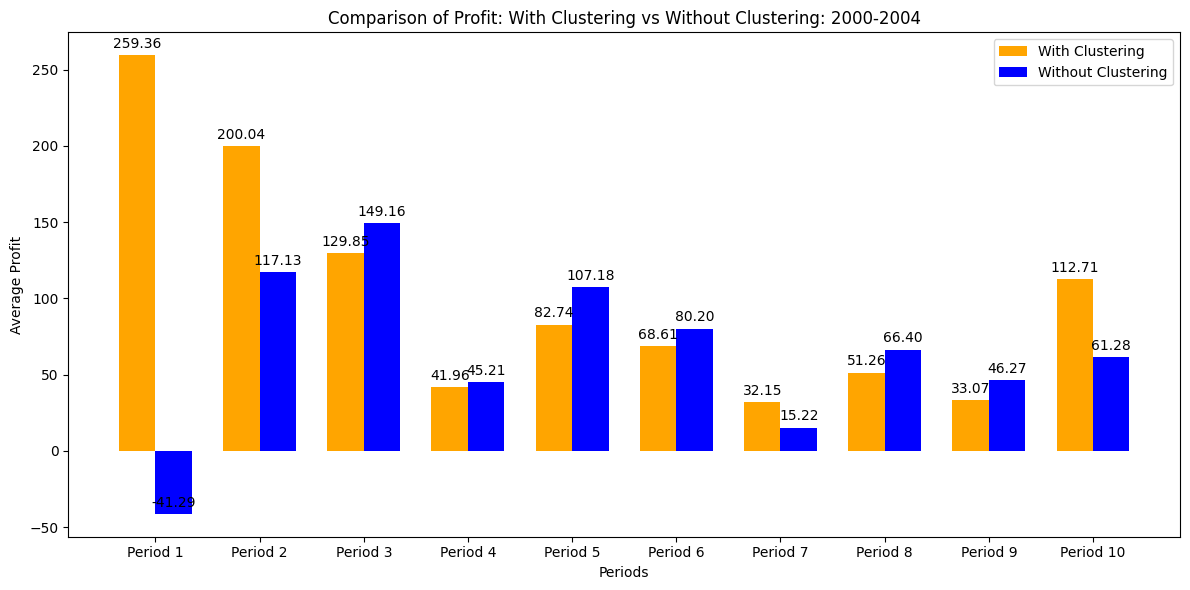

################# recent:
With clustering, avg results is 247.10702174015418
Without, avg results is 286.79088557519856
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 456.6498701828491
Without, avg results is 233.01812934250475
__
Reject the null hypothesis: The mean is greater than 0.
REJECT the null: Clustering achieves better returns.
With clustering, avg results is 915.5661951089076
Without, avg results is 414.68581244218274
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 425.4359167948058
Without, avg results is 249.70617148742403
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 289.5067945555381
Without, avg results is 634.0274346974851
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 492.9757457598201
Without, avg results is 637.0668325442641
__
Reject the null hypothesis: The mean is greater than 0.

With 

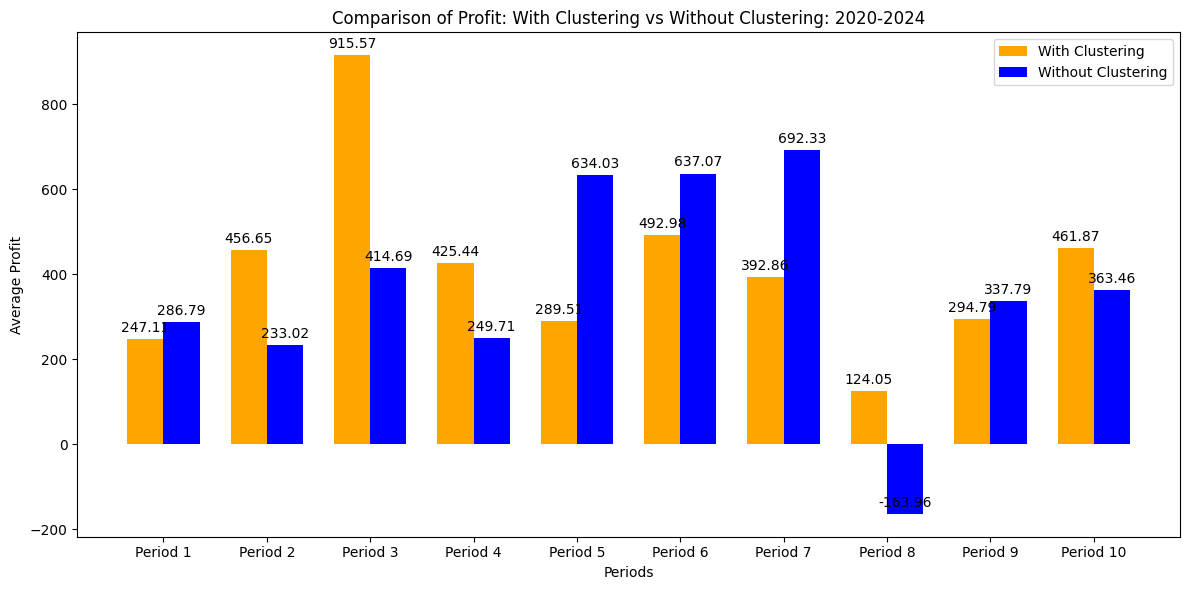

In [ ]:
filenames = [
    'pairs_2000-05-09_2001-01-15.csv',
    'pairs_2000-09-12_2001-05-21.csv',
    'pairs_2001-05-22_2002-01-28.csv',
    'pairs_2001-09-25_2002-06-03.csv',
    'pairs_2002-01-29_2002-10-07.csv',
    'pairs_2002-06-04_2003-02-10.csv',
    'pairs_2002-10-08_2003-06-16.csv',
    'pairs_2003-02-11_2003-10-20.csv',
    'pairs_2003-06-17_2004-02-23.csv',
    'pairs_2003-10-21_2004-06-28.csv',
]
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store average returns for plotting
avg_returns_with_cluster = []
avg_returns_without_cluster = []

# Iterate through filenames and compute returns
for f in filenames:
    f2 = 'nocluster' + f
    money_list = trade_pairs_distance(f, trading_horizon_days=30) #change to trade_pairs_rolling to get the results for that strategy
    money_list2 = trade_pairs_distance(f2, trading_horizon_days=30)

    # Compute averages
    avg_with_cluster = np.mean(money_list)
    avg_without_cluster = np.mean(money_list2)
    avg_returns_with_cluster.append(avg_with_cluster)
    avg_returns_without_cluster.append(avg_without_cluster)

    # Print results
    print(f"With clustering, avg results is {avg_with_cluster}")
    print(f"Without, avg results is {avg_without_cluster}")
    _, _, result_0 = test_mean_greater_than_zero(money_list)
    _, _, result = test_mean_greater_than(money_list, money_list2)
    print("__")
    if avg_with_cluster > 0:
        print(result_0)
    print(result)

# Plot the comparison of returns
x_labels = [f"Period {i+1}" for i in range(len(filenames))]
x = np.arange(len(x_labels))  # Label locations
width = 0.35  # Width of the bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, avg_returns_with_cluster, width, label='With Clustering', color='orange')
bars2 = ax.bar(x + width/2, avg_returns_without_cluster, width, label='Without Clustering', color='blue')

# Adding labels, title, and legend
ax.set_xlabel("Periods")
ax.set_ylabel("Average Profit")
ax.set_title("Comparison of Profit: With Clustering vs Without Clustering: 2000-2004")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

# Adding values above the bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()


print("################# recent:")    
later_filenames = [
    'pairs_2020-09-15_2021-05-24.csv',
    'pairs_2021-01-19_2021-09-27.csv',
    'pairs_2021-05-25_2022-01-31.csv',
    'pairs_2021-09-28_2022-06-06.csv',
    'pairs_2022-02-01_2022-10-10.csv',
    'pairs_2022-06-07_2023-02-13.csv',
    'pairs_2022-10-11_2023-06-19.csv',
    'pairs_2023-02-14_2023-10-23.csv',
    'pairs_2023-06-20_2024-02-26.csv',
    'pairs_2024-02-27_2024-11-04.csv'
]
avg_returns_with_cluster = []
avg_returns_without_cluster = []

# Iterate through filenames and compute returns
for f in later_filenames:
    f2 = 'nocluster' + f
    money_list = trade_pairs_distance(f, trading_horizon_days=30)
    money_list2 = trade_pairs_distance(f2, trading_horizon_days=30)

    # Compute averages
    avg_with_cluster = np.mean(money_list)
    avg_without_cluster = np.mean(money_list2)
    avg_returns_with_cluster.append(avg_with_cluster)
    avg_returns_without_cluster.append(avg_without_cluster)

    # Print results
    print(f"With clustering, avg results is {avg_with_cluster}")
    print(f"Without, avg results is {avg_without_cluster}")
    _, _, result_0 = test_mean_greater_than_zero(money_list)
    _, _, result = test_mean_greater_than(money_list, money_list2)
    print("__")
    if avg_with_cluster > 0:
        print(result_0)
    print(result)

# Plot the comparison of returns
x_labels = [f"Period {i+1}" for i in range(len(filenames))]
x = np.arange(len(x_labels))  # Label locations
width = 0.35  # Width of the bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, avg_returns_with_cluster, width, label='With Clustering', color='orange')
bars2 = ax.bar(x + width/2, avg_returns_without_cluster, width, label='Without Clustering', color='blue')

# Adding labels, title, and legend
ax.set_xlabel("Periods")
ax.set_ylabel("Average Profit")
ax.set_title("Comparison of Profit: With Clustering vs Without Clustering: 2020-2024")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

# Adding values above the bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

Execute Rolling Mean:

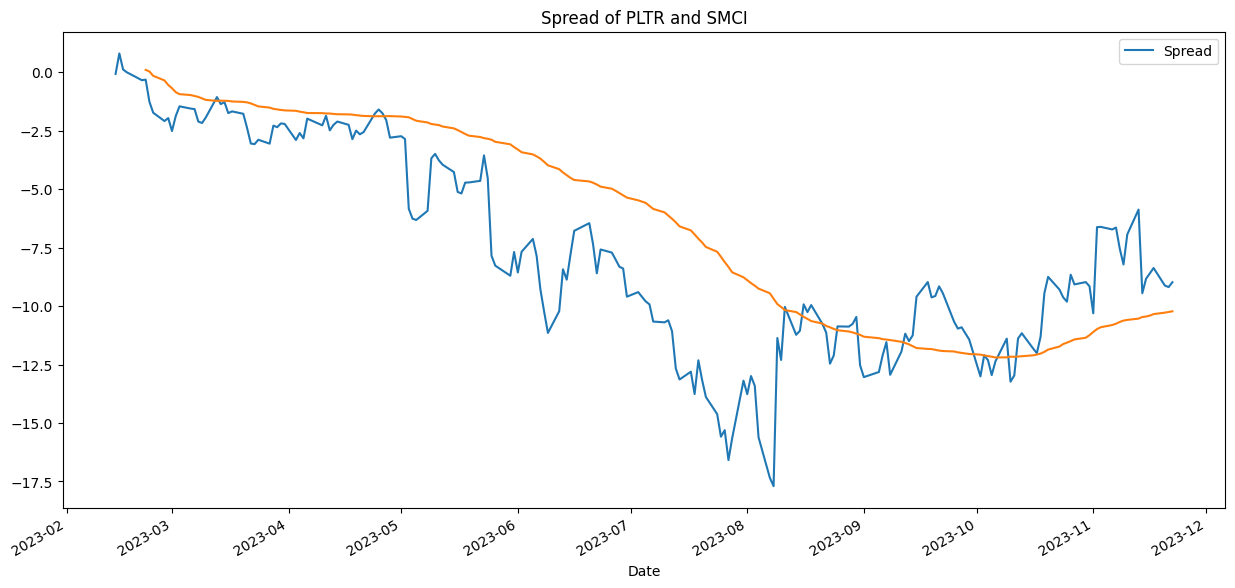

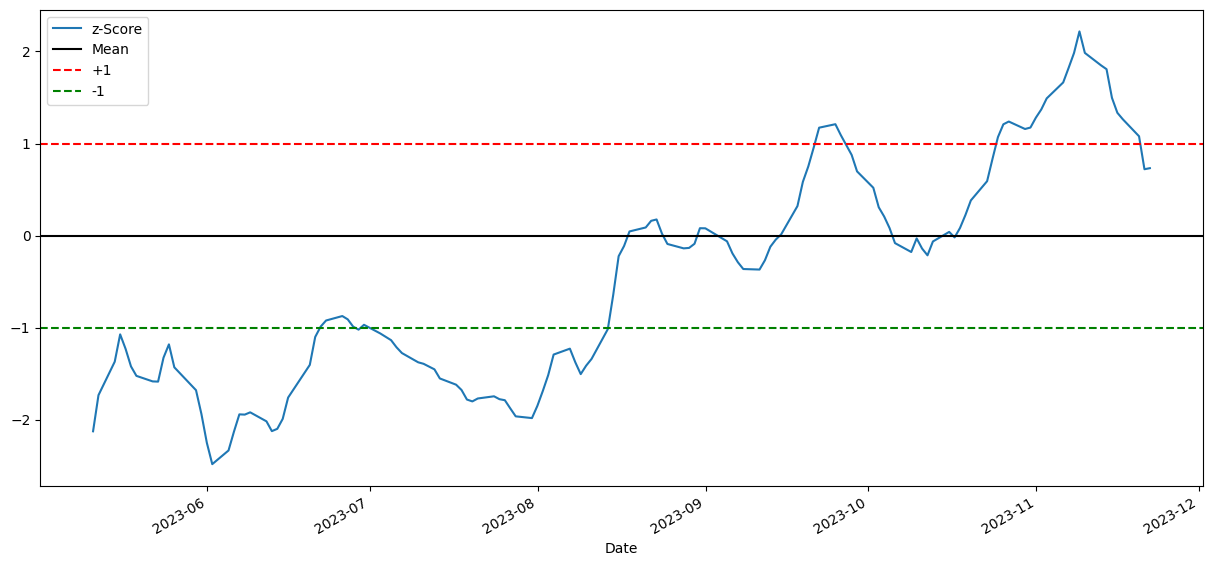

-9.129567197576542


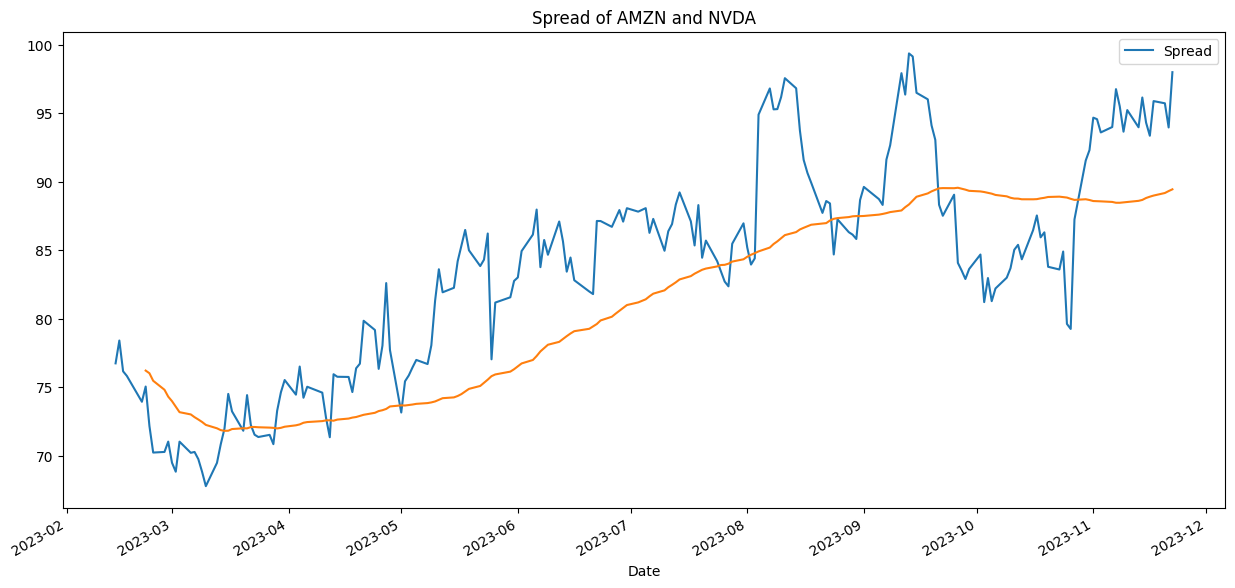

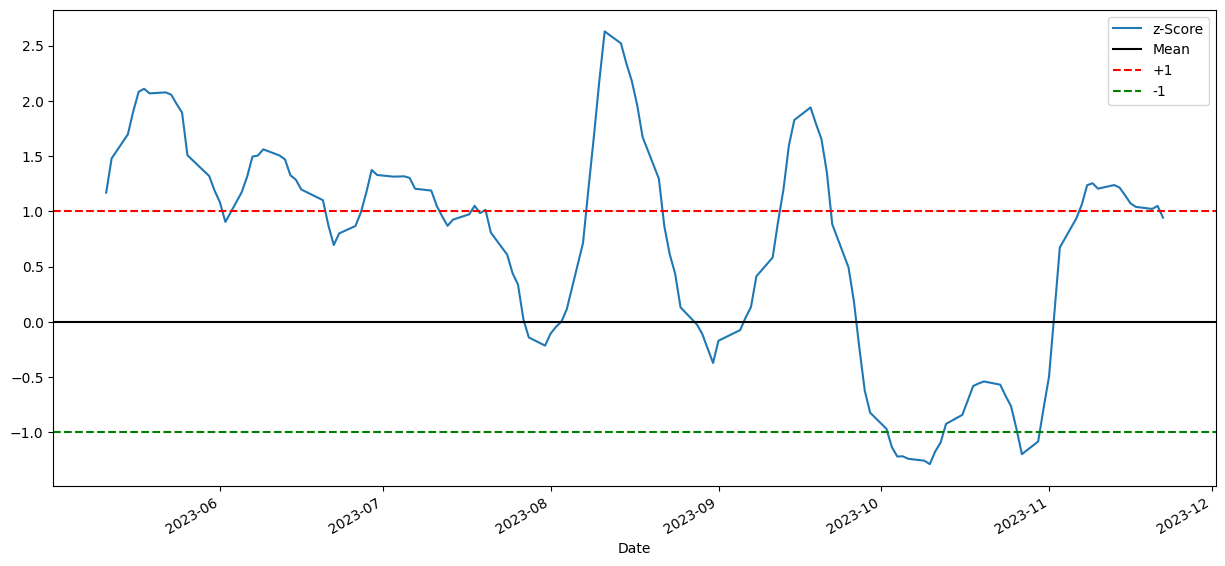

1077.0580462782987


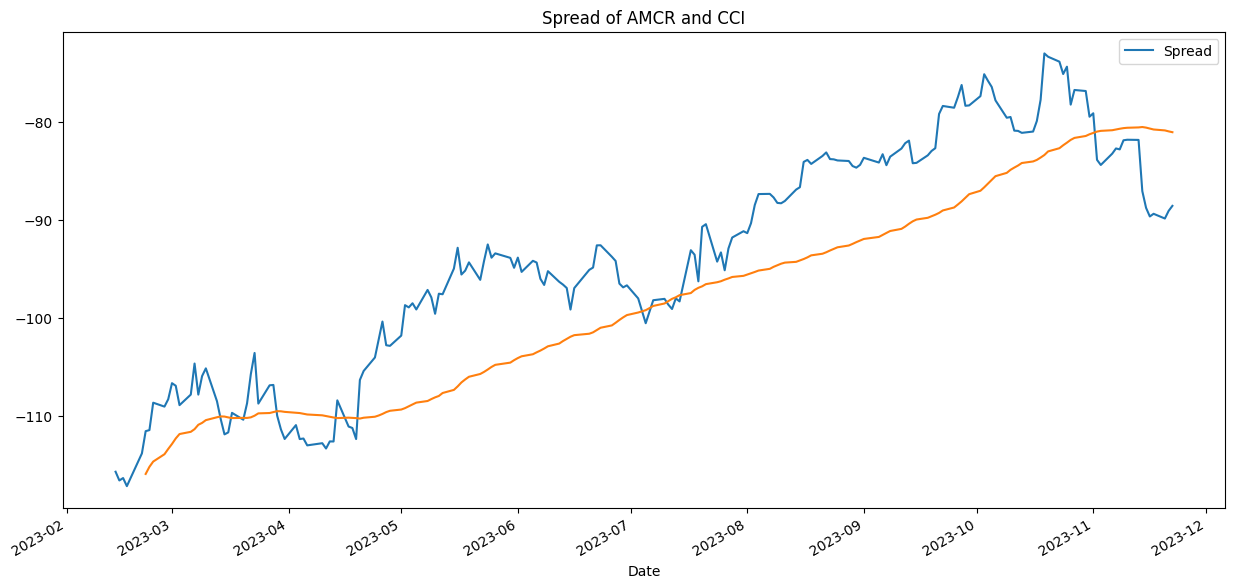

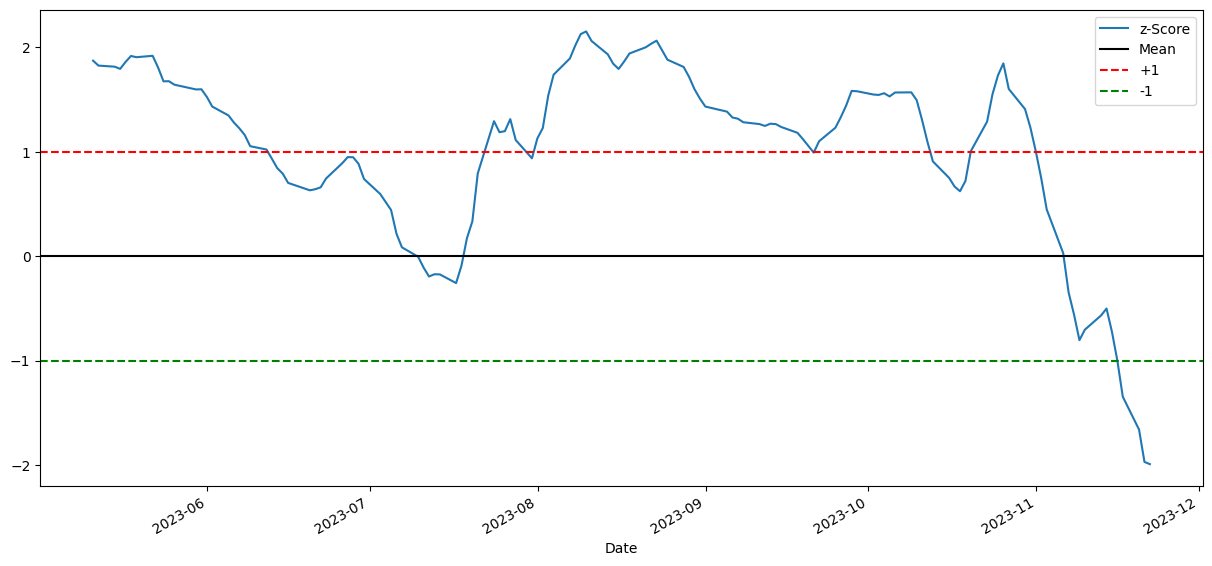

35.11139830103181


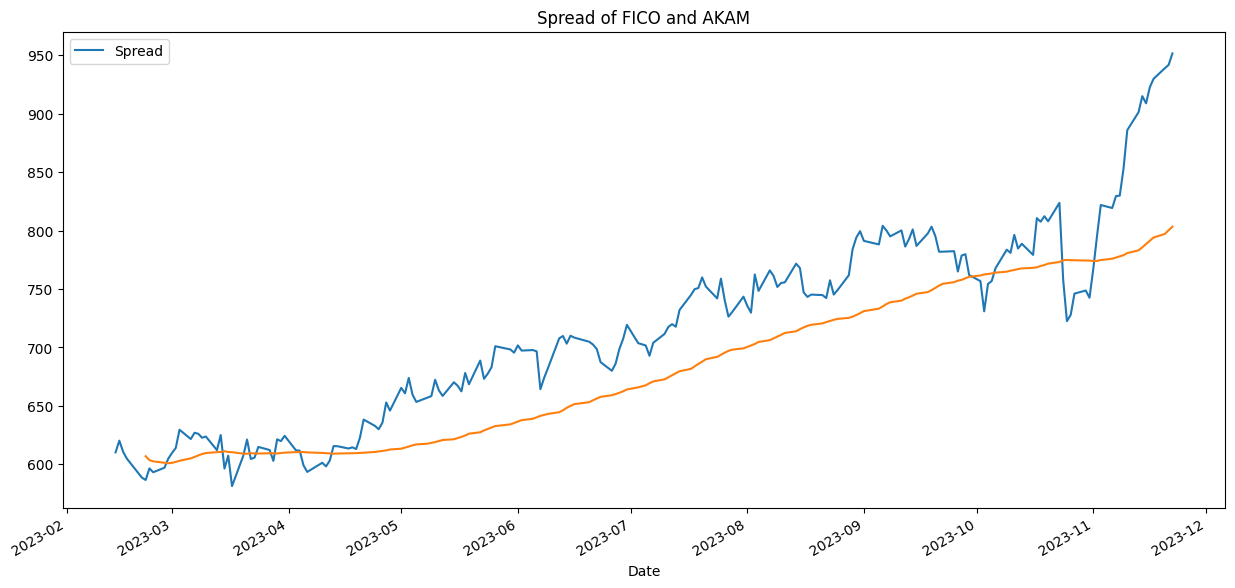

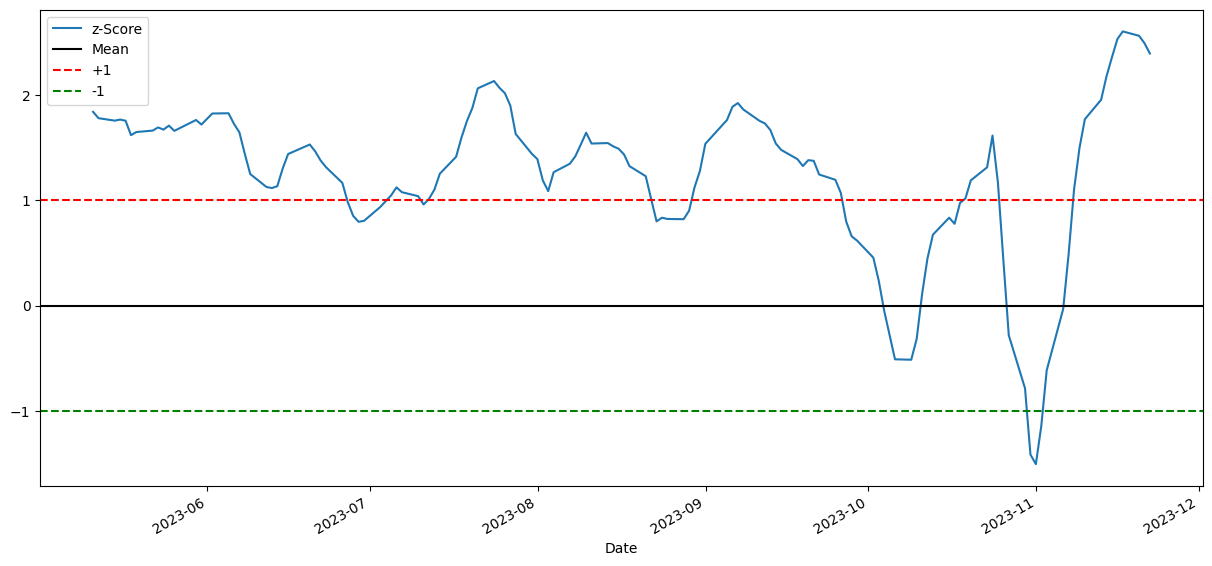

5470.475514425185


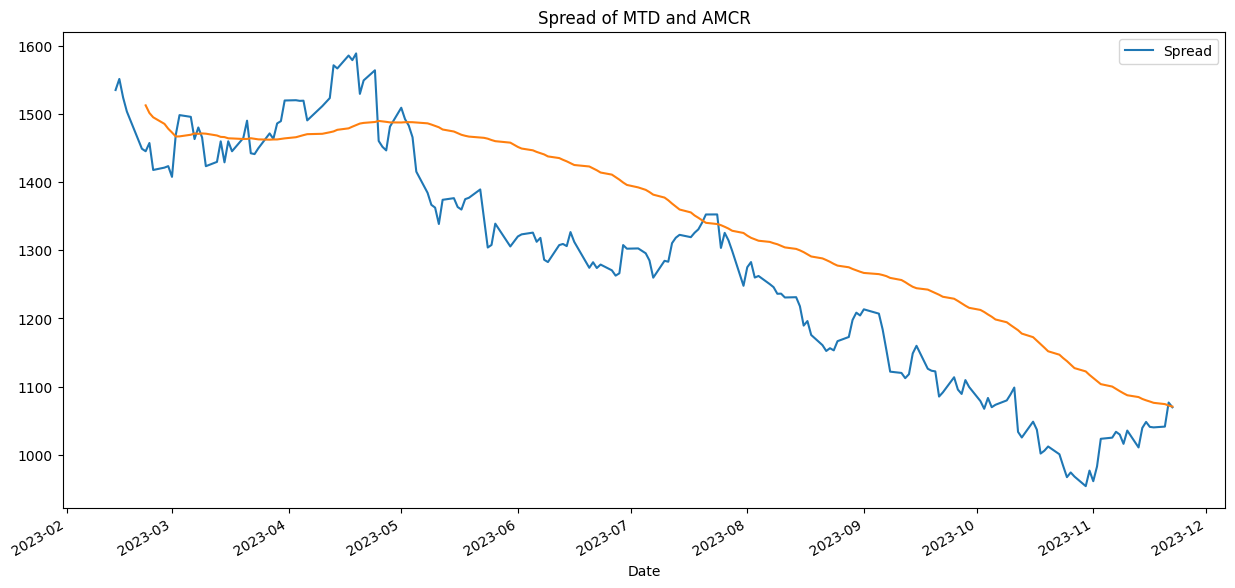

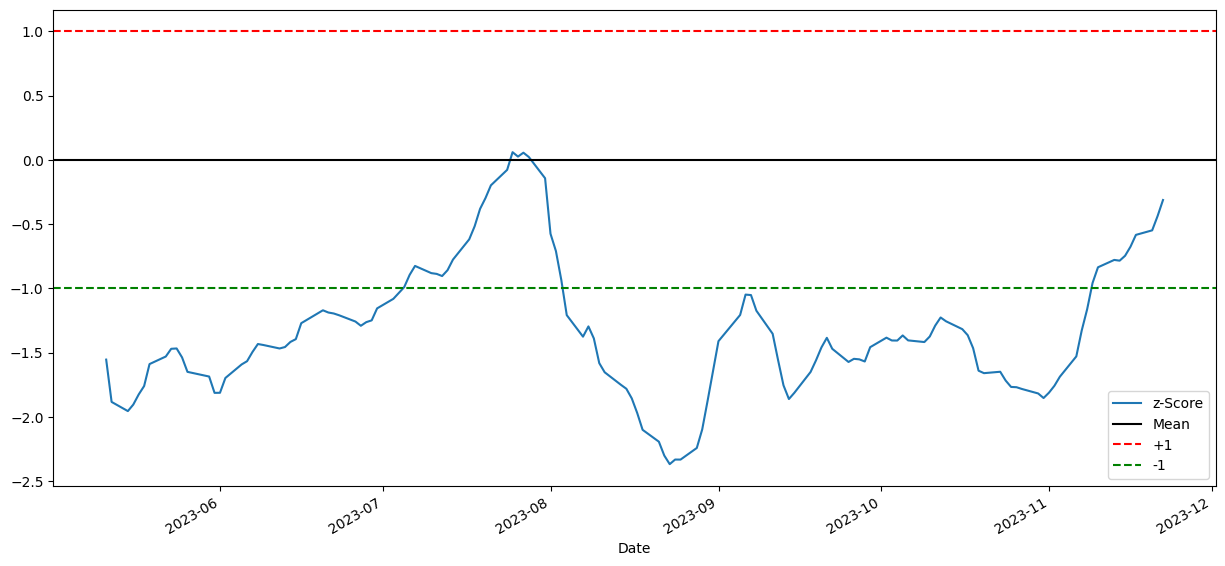

-3100.0029921734103


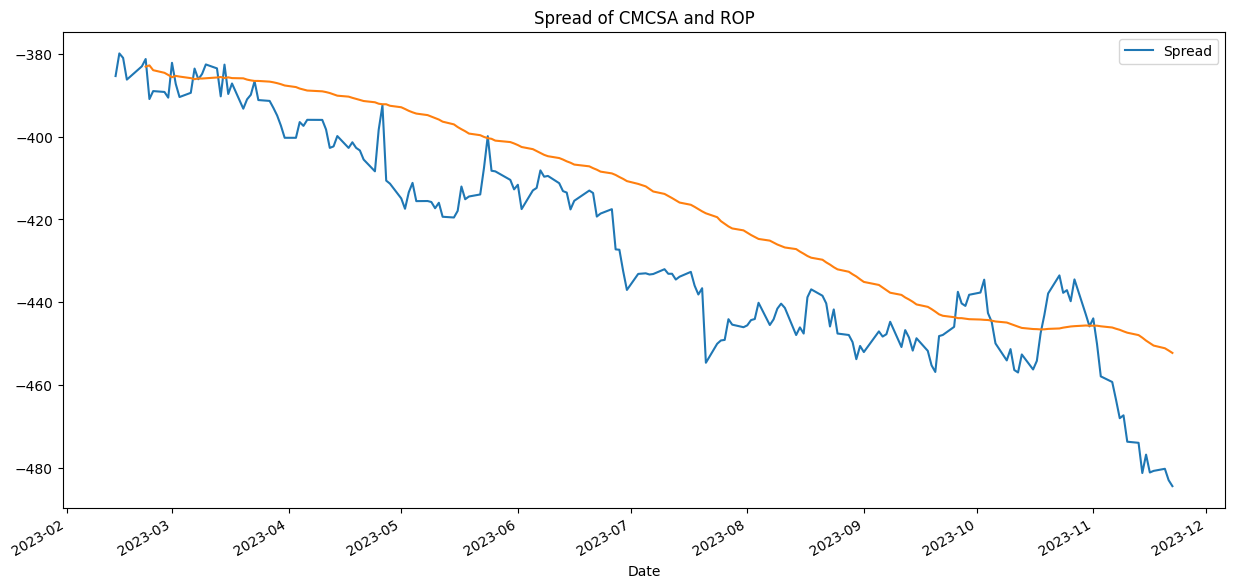

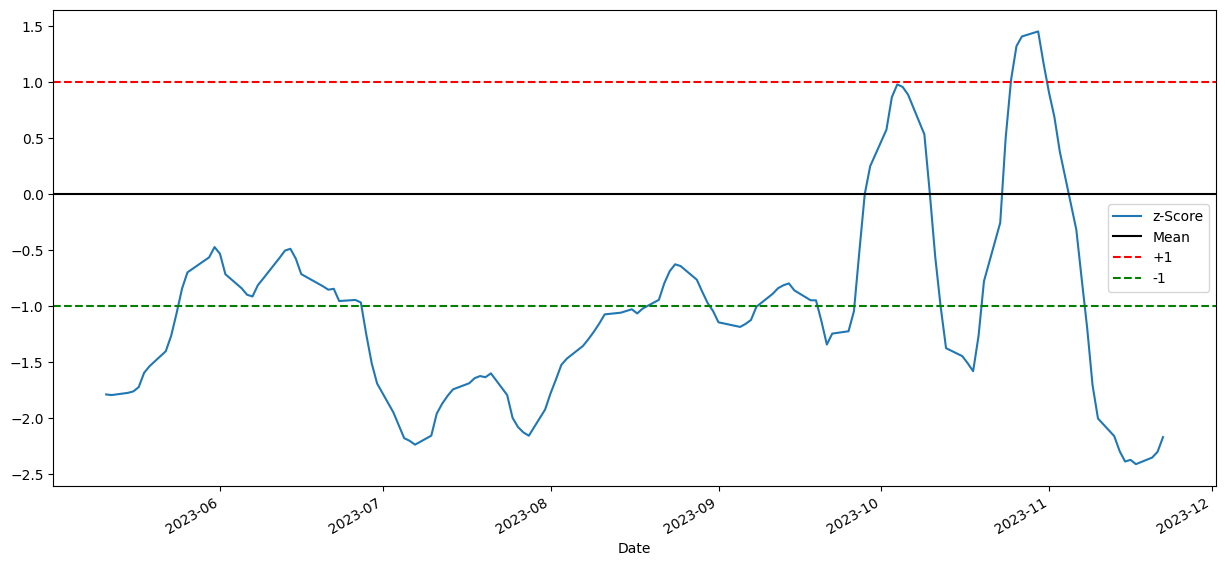

27.539775267276667


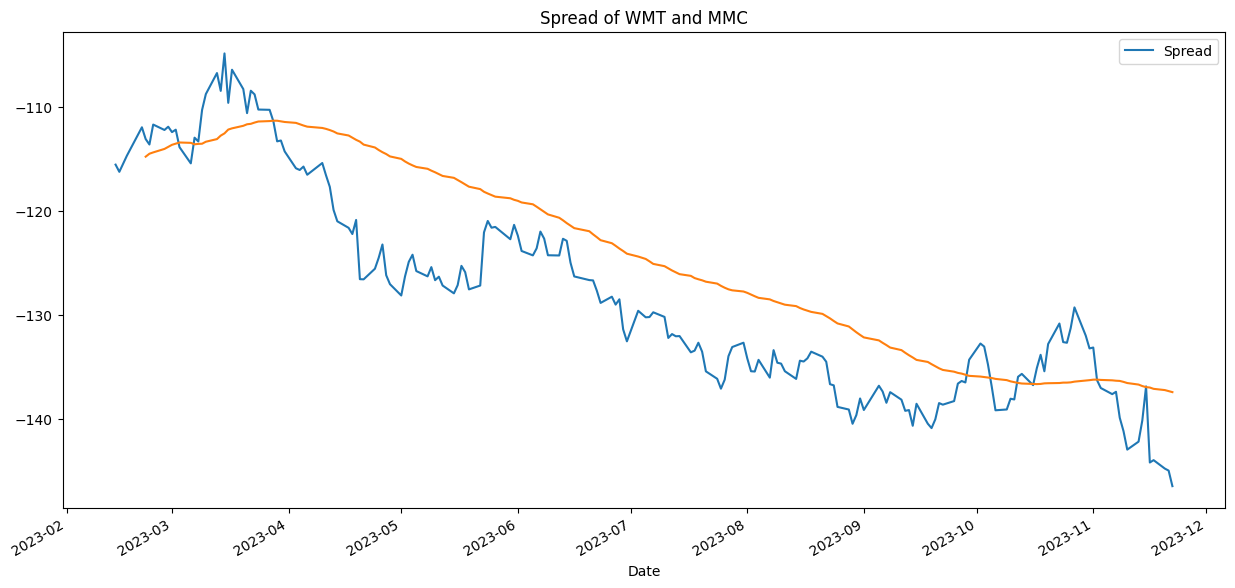

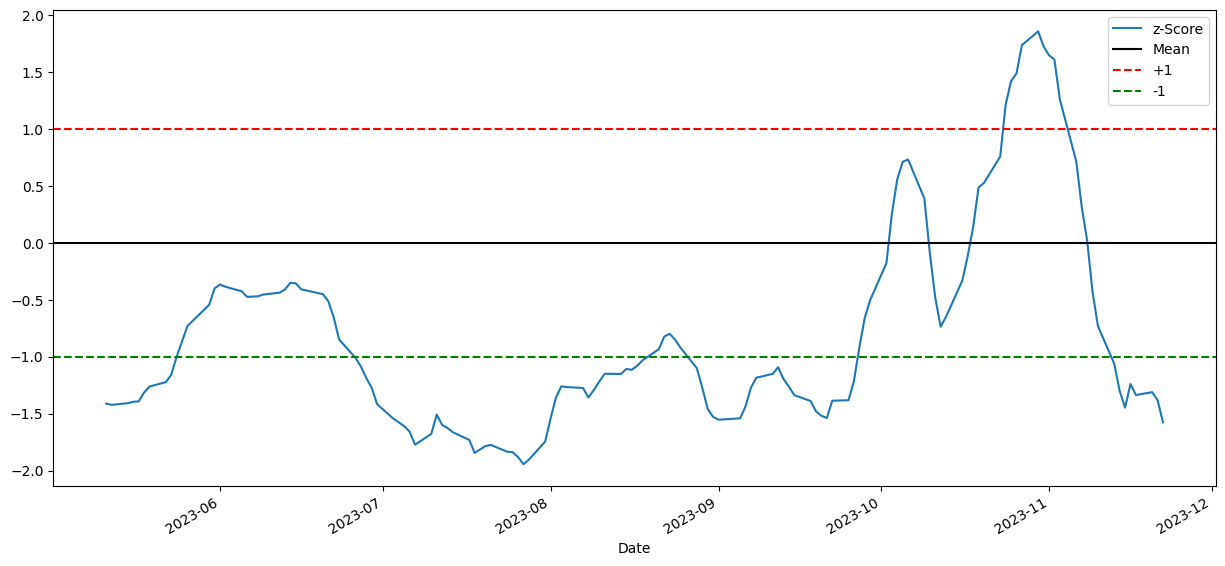

64.81910511156772


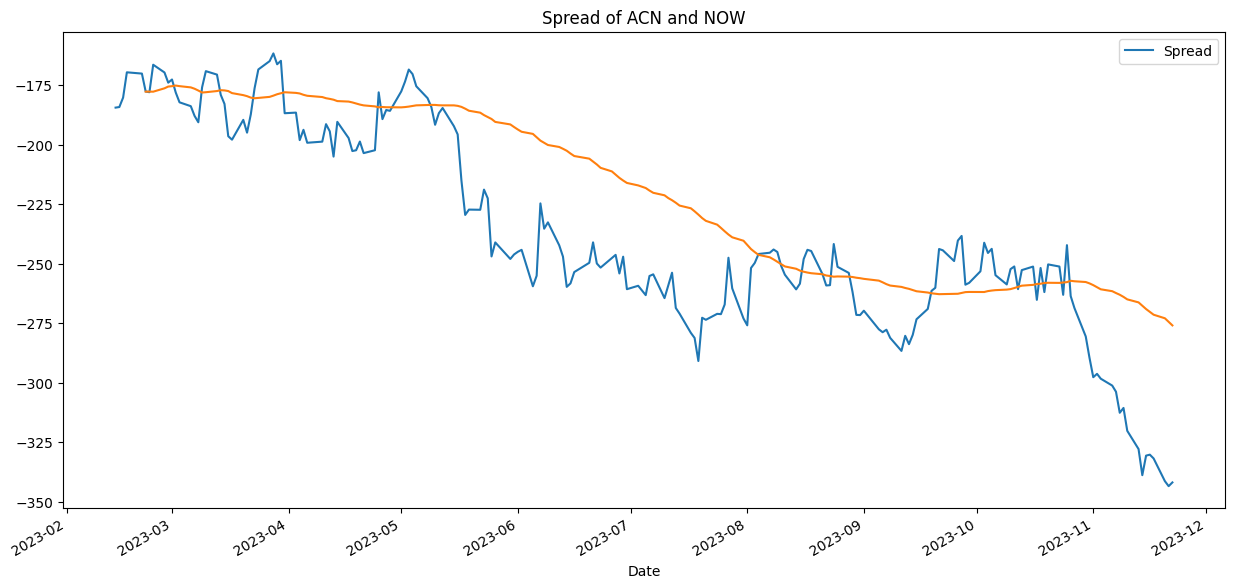

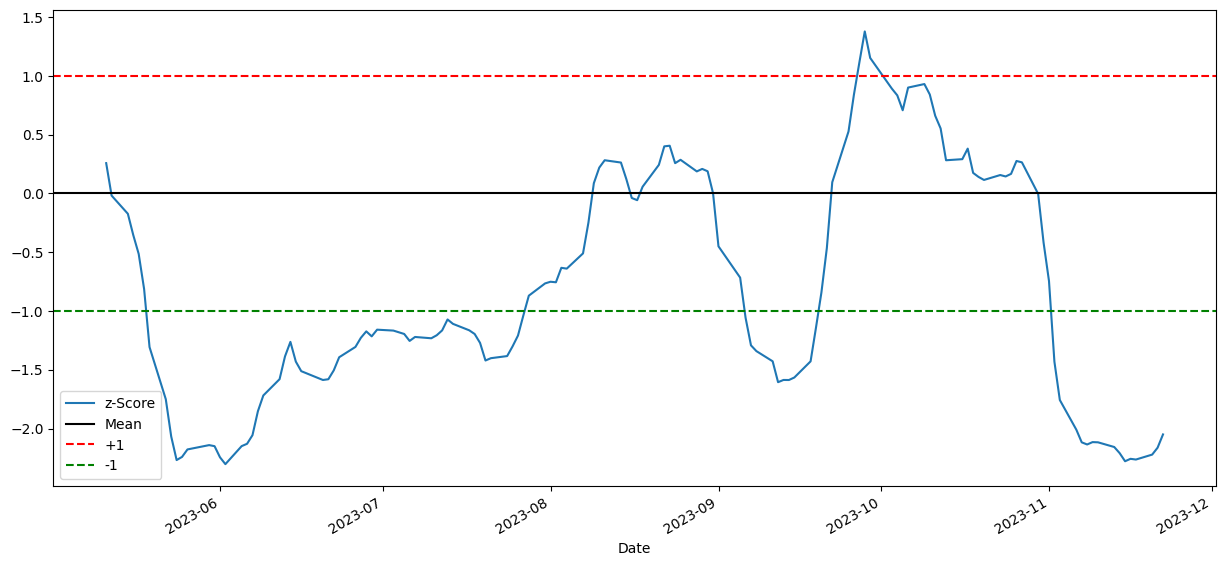

518.5131022022522


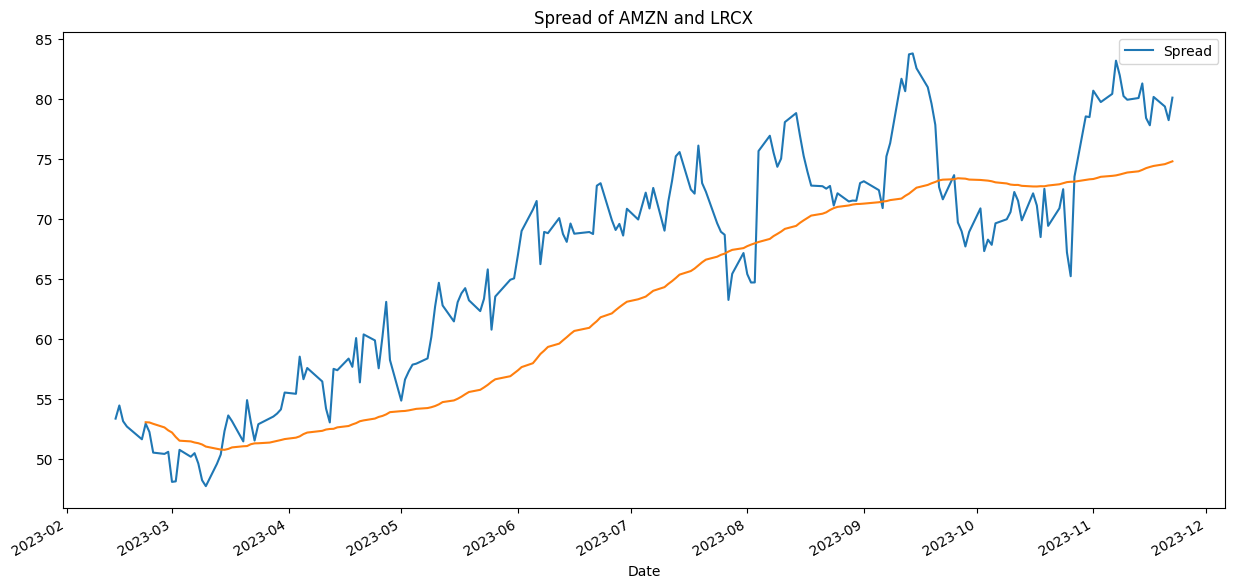

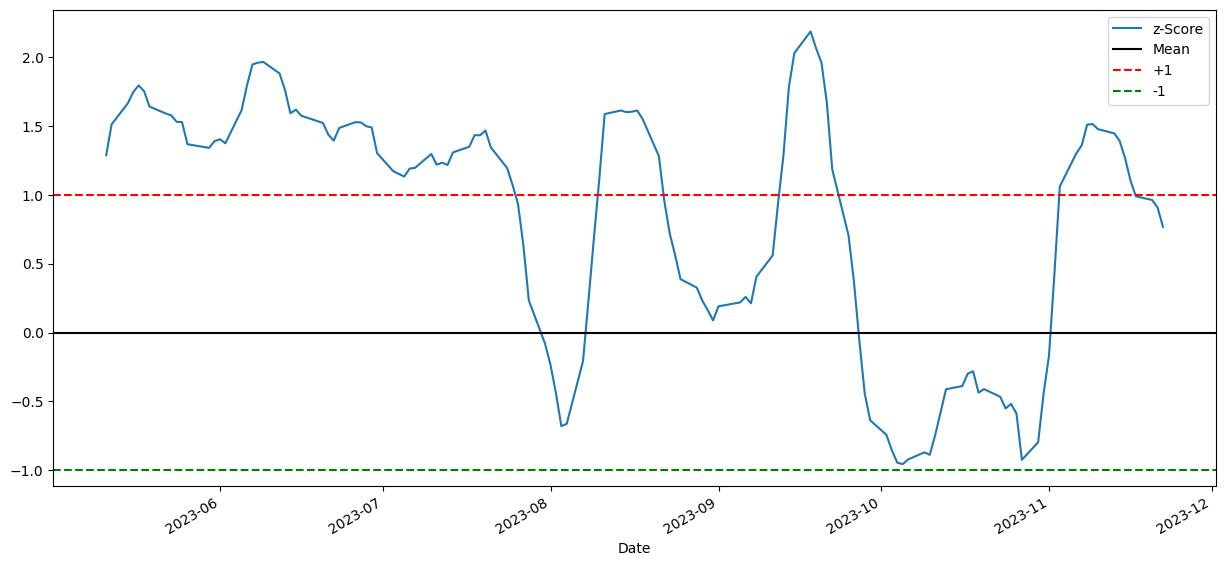

905.0276947882356


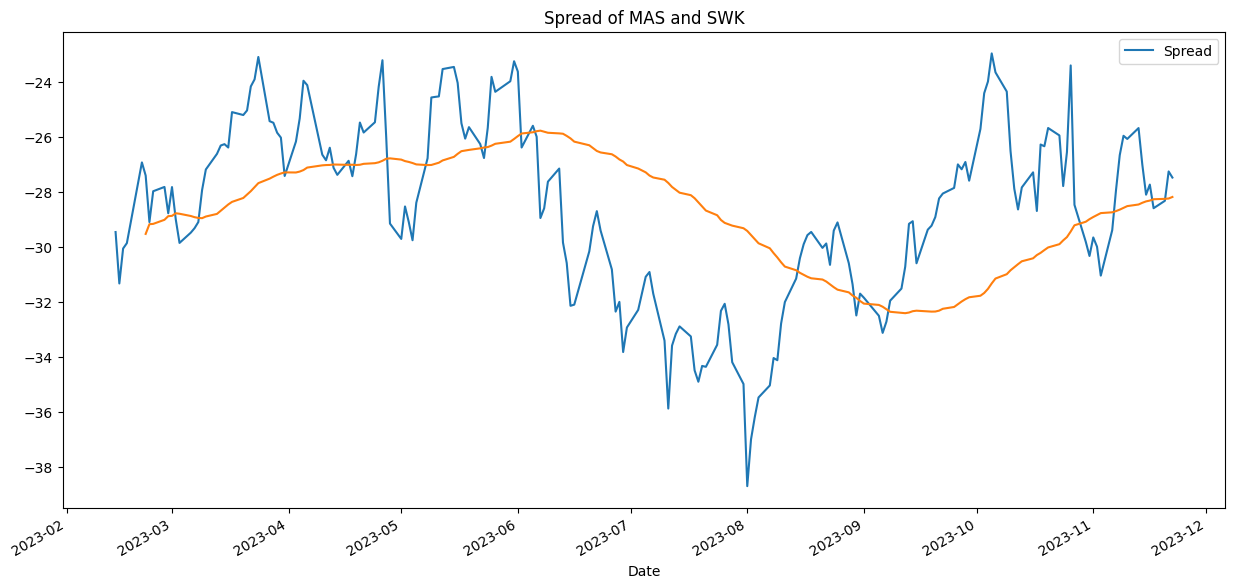

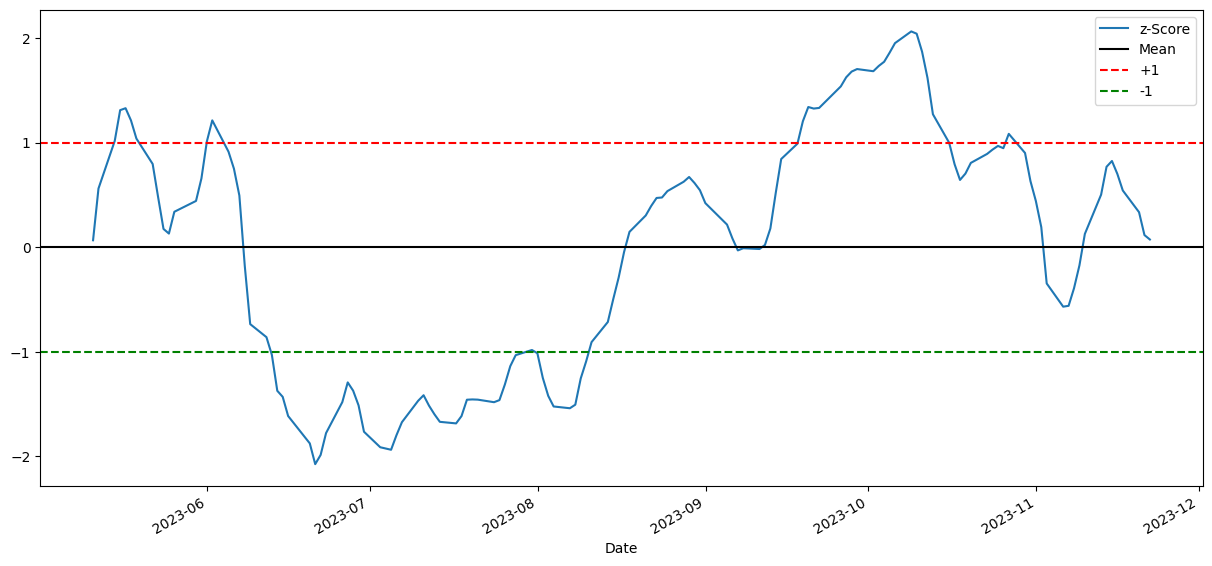

128.57026133251736


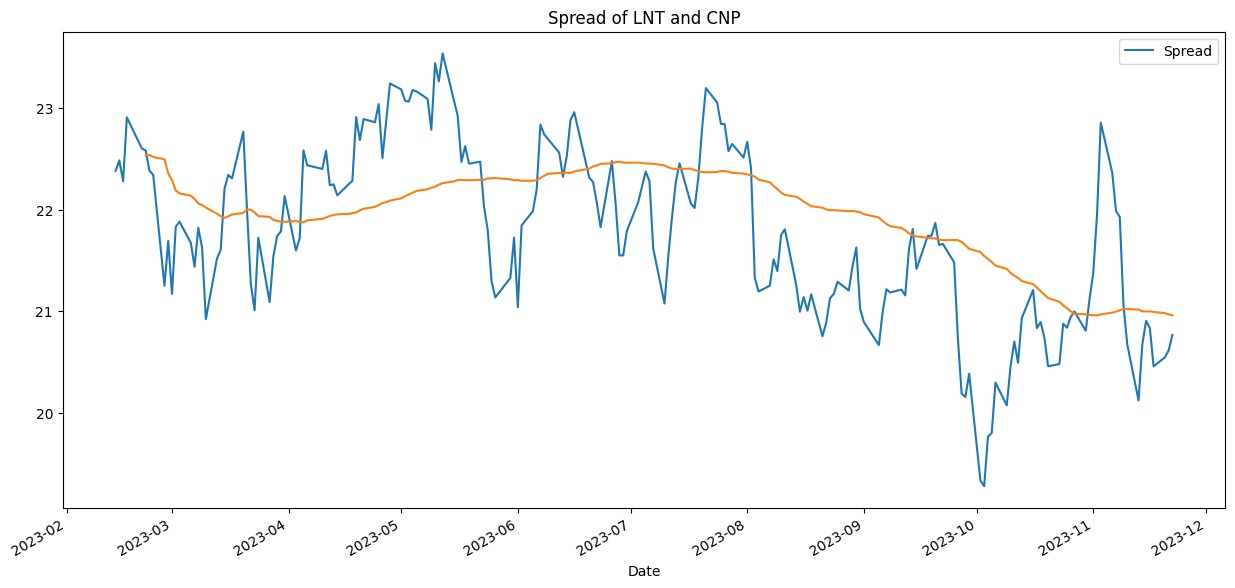

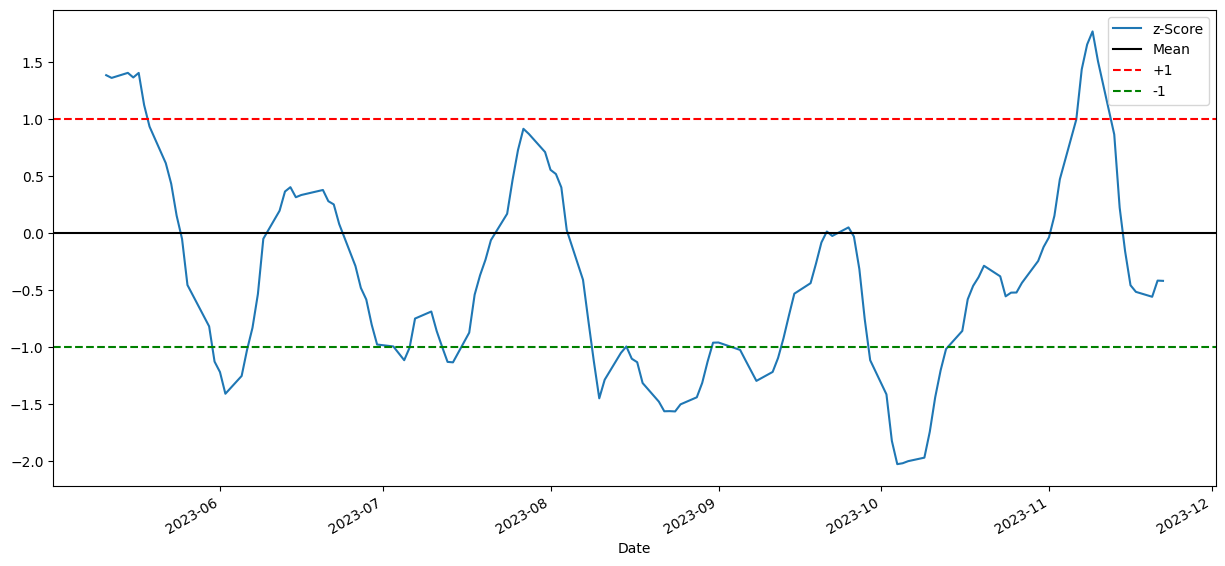

10.603575145068135


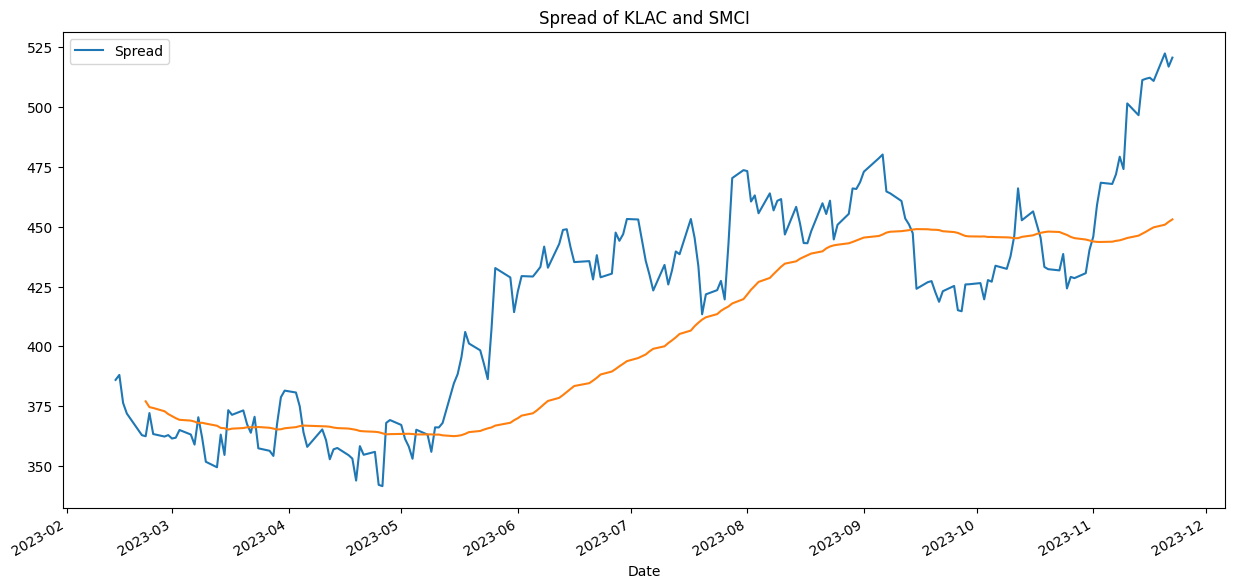

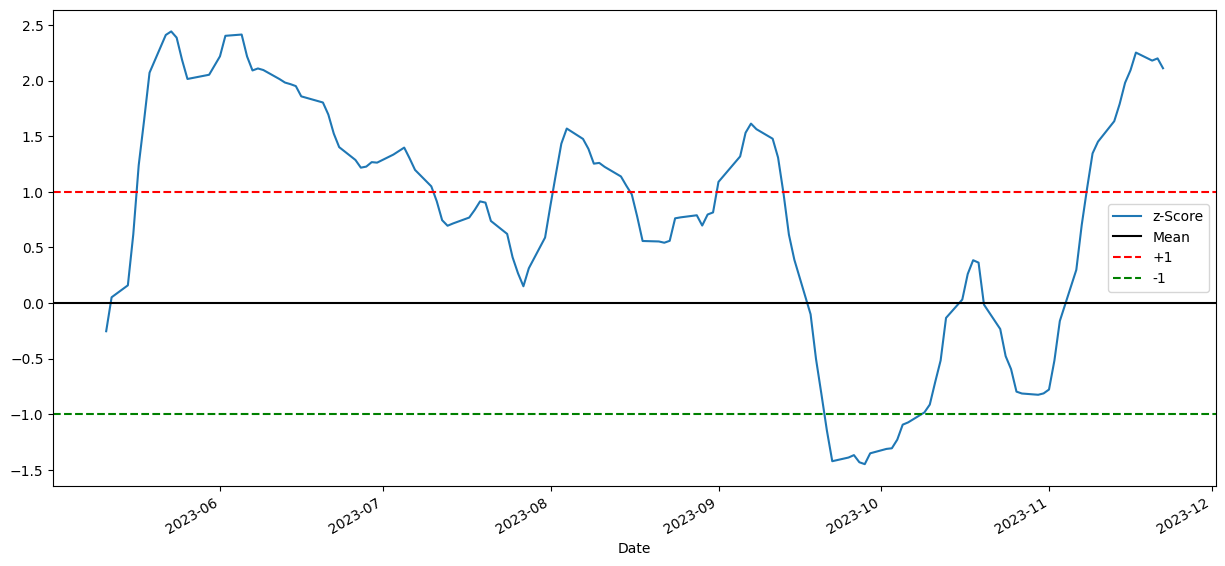

6612.734699170513


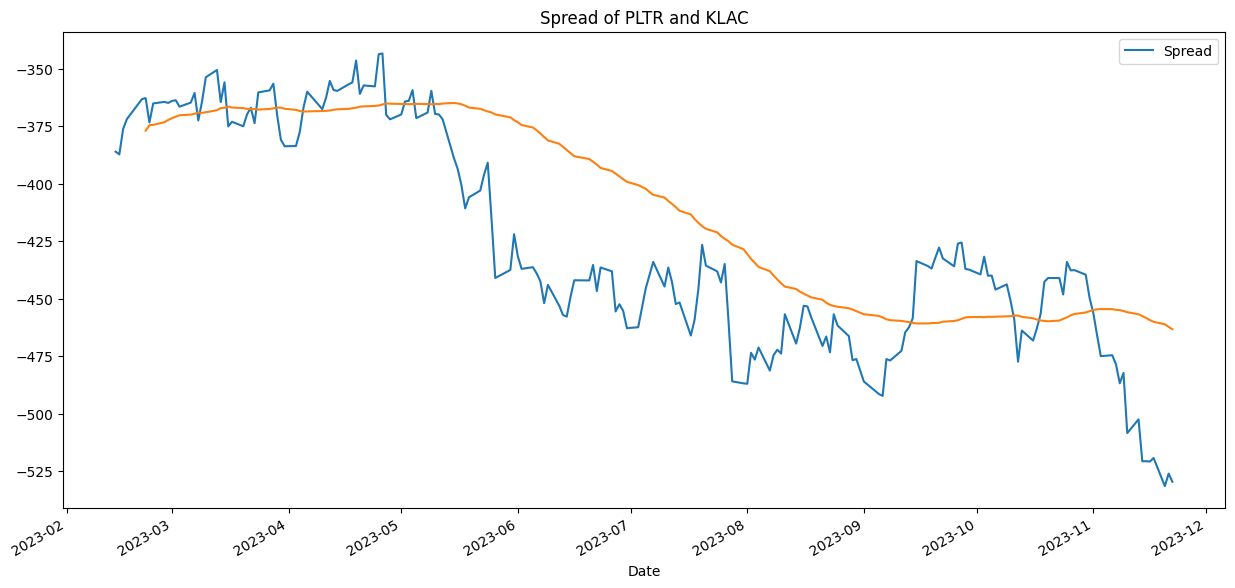

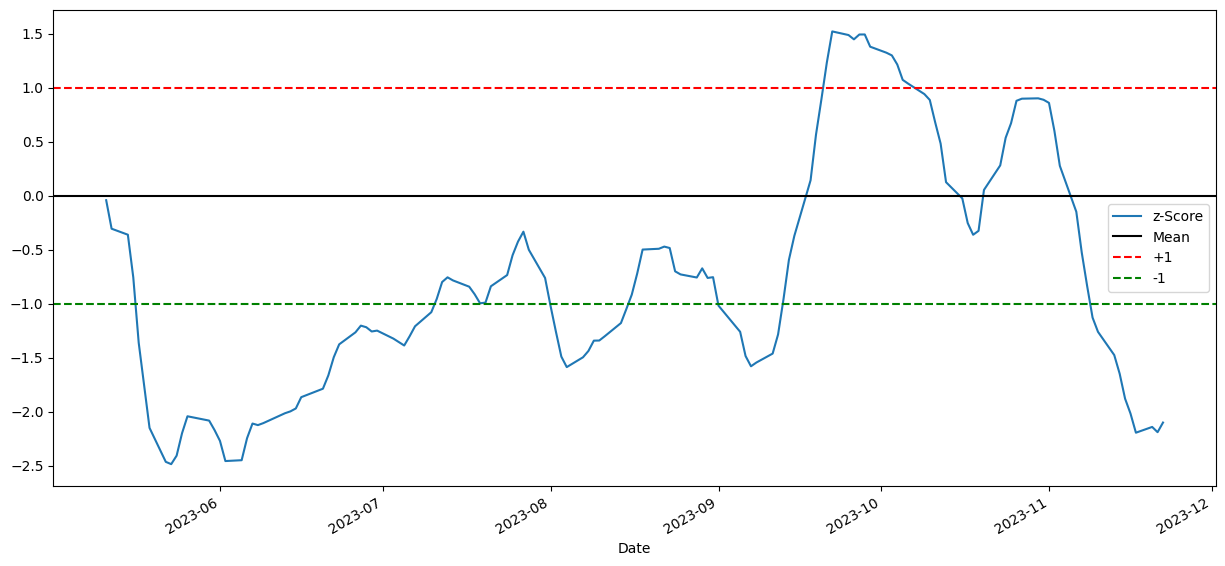

38.002445805478004


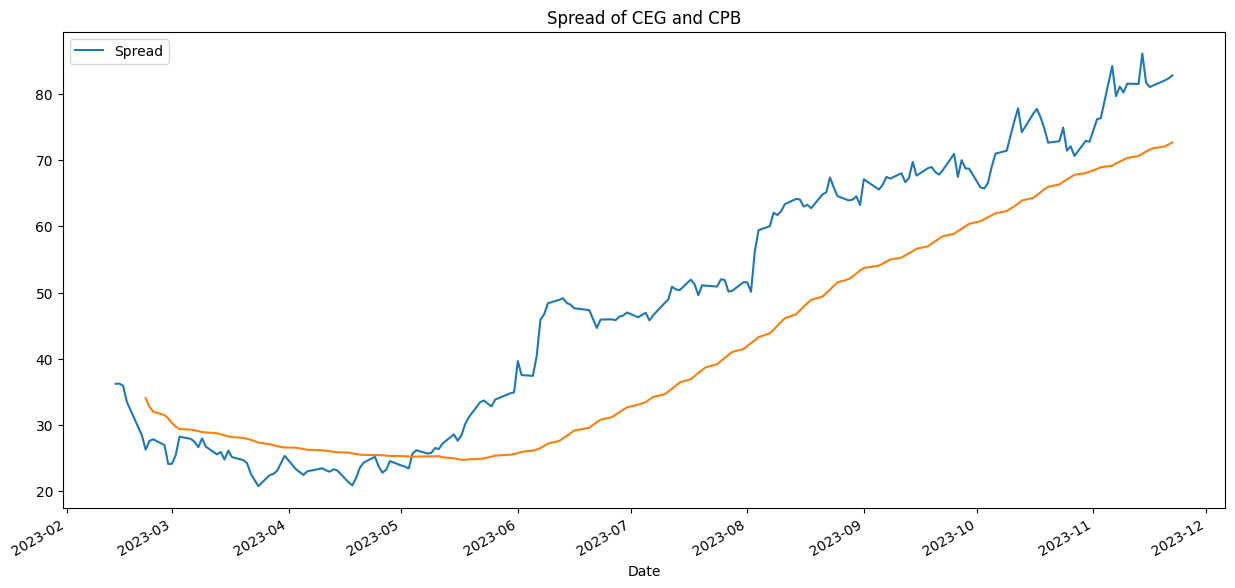

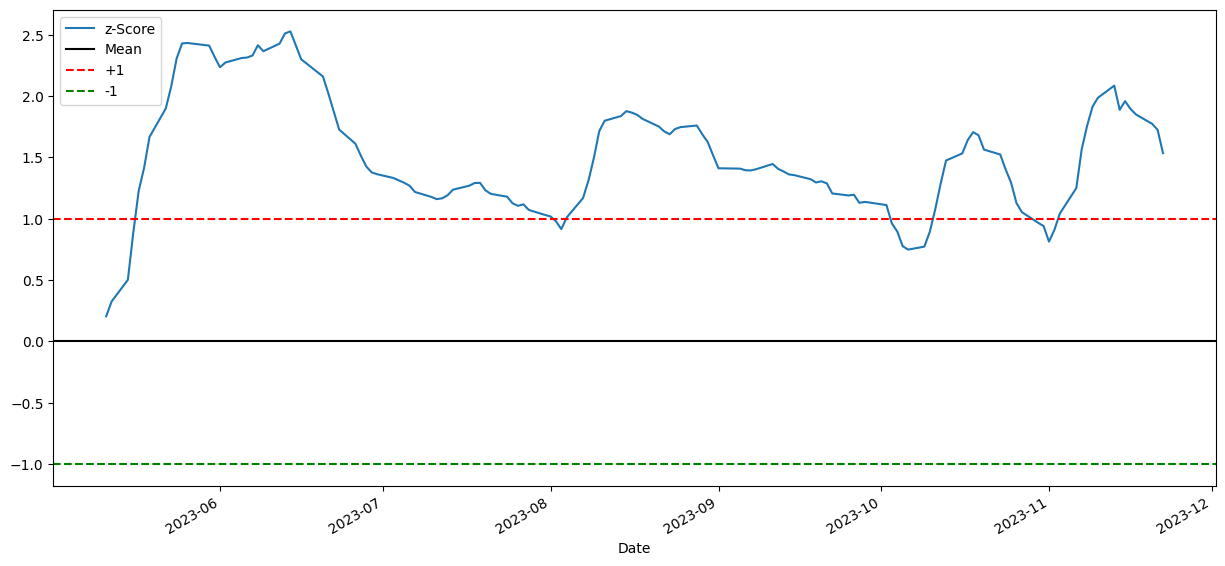

-9.947598300641403e-14


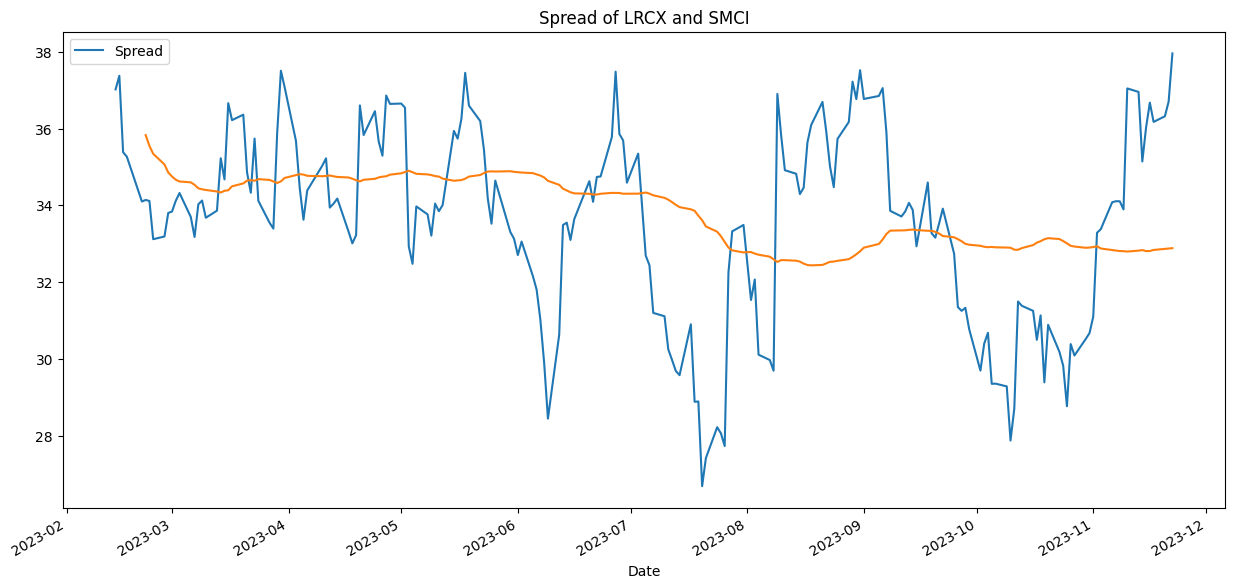

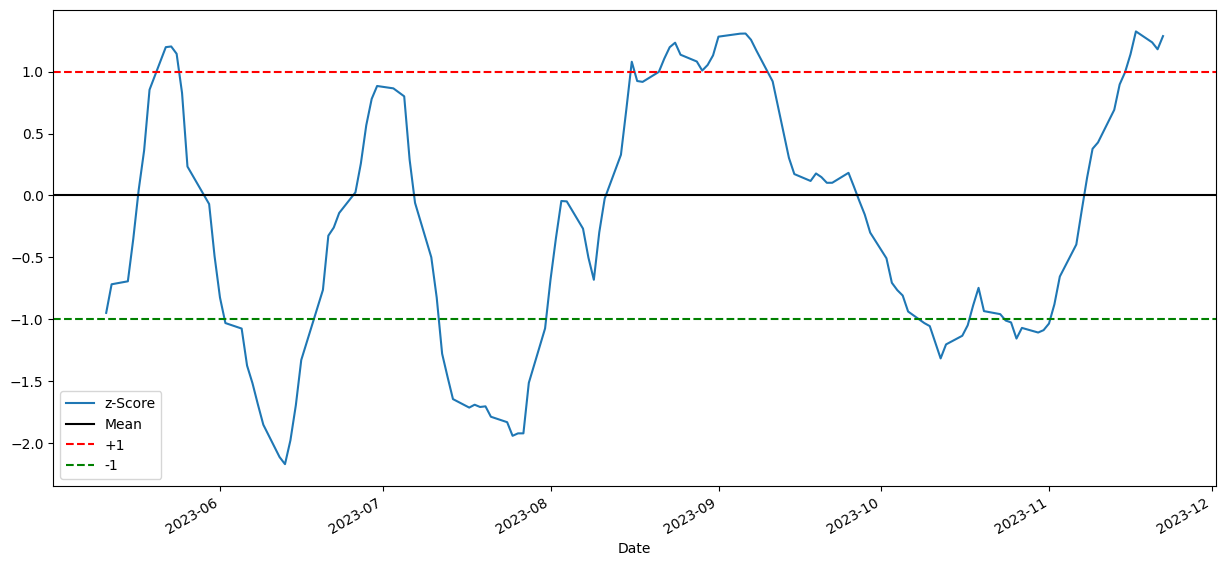

220.39914867233236


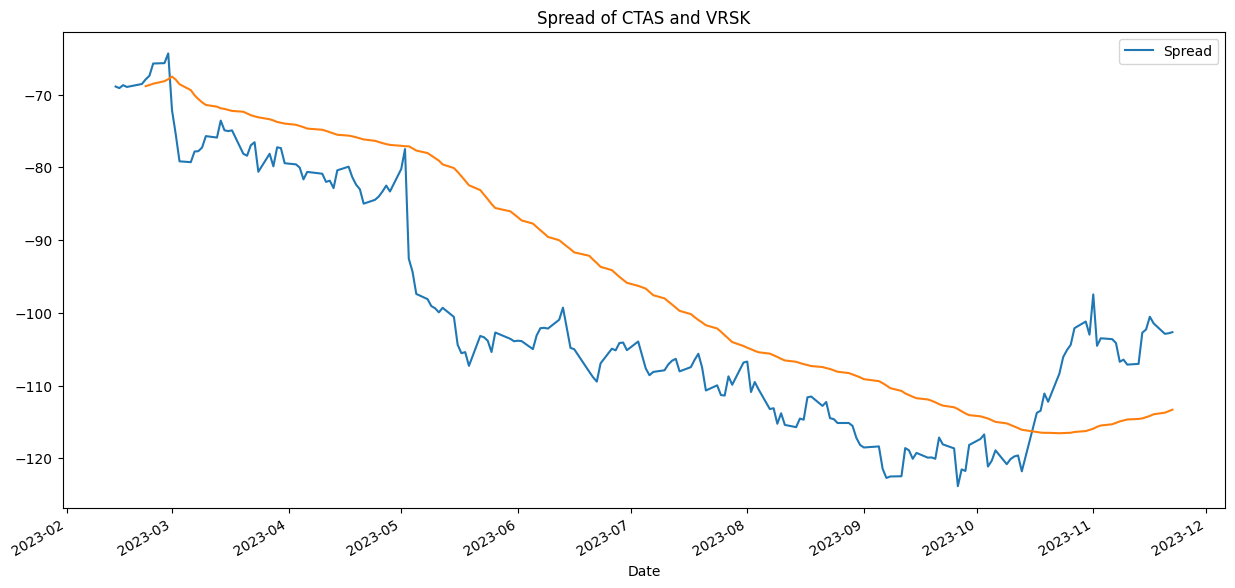

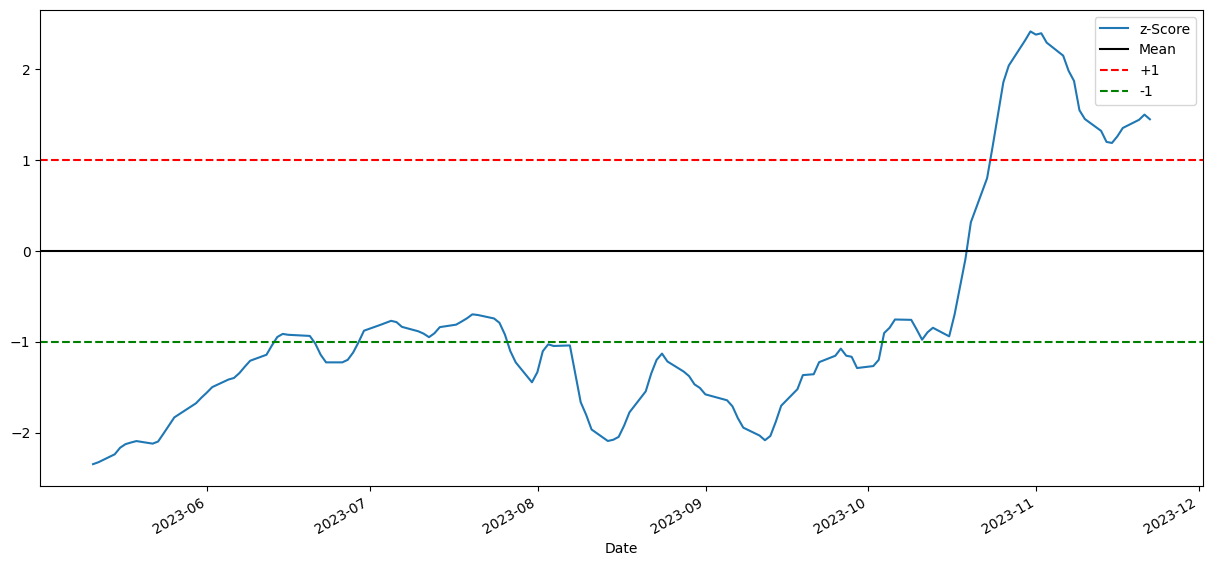

109.51475249502803


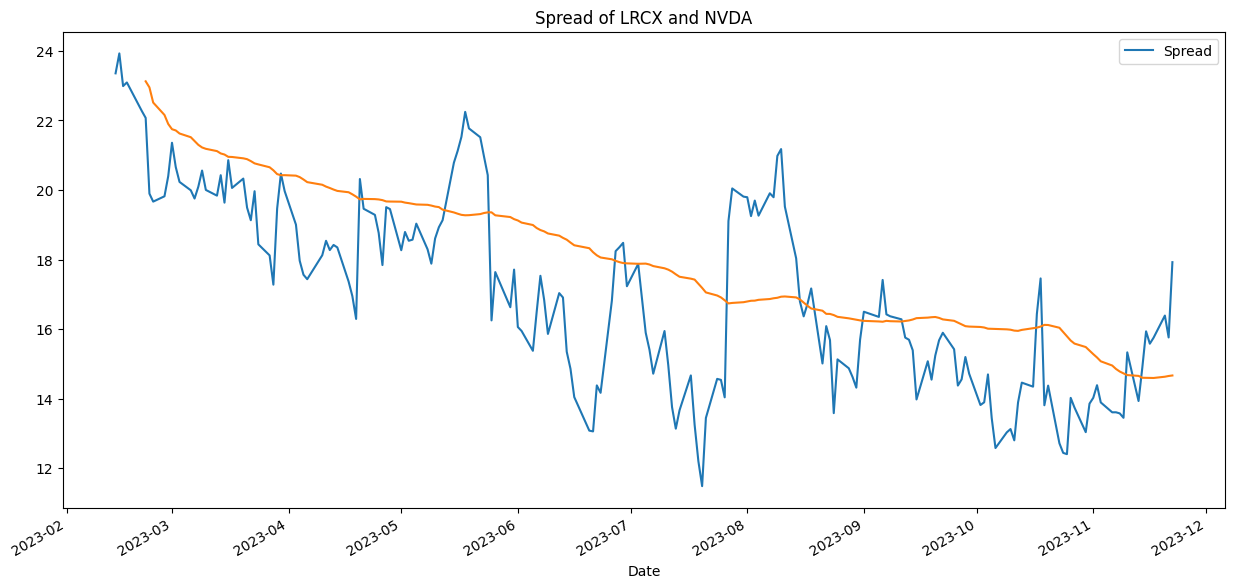

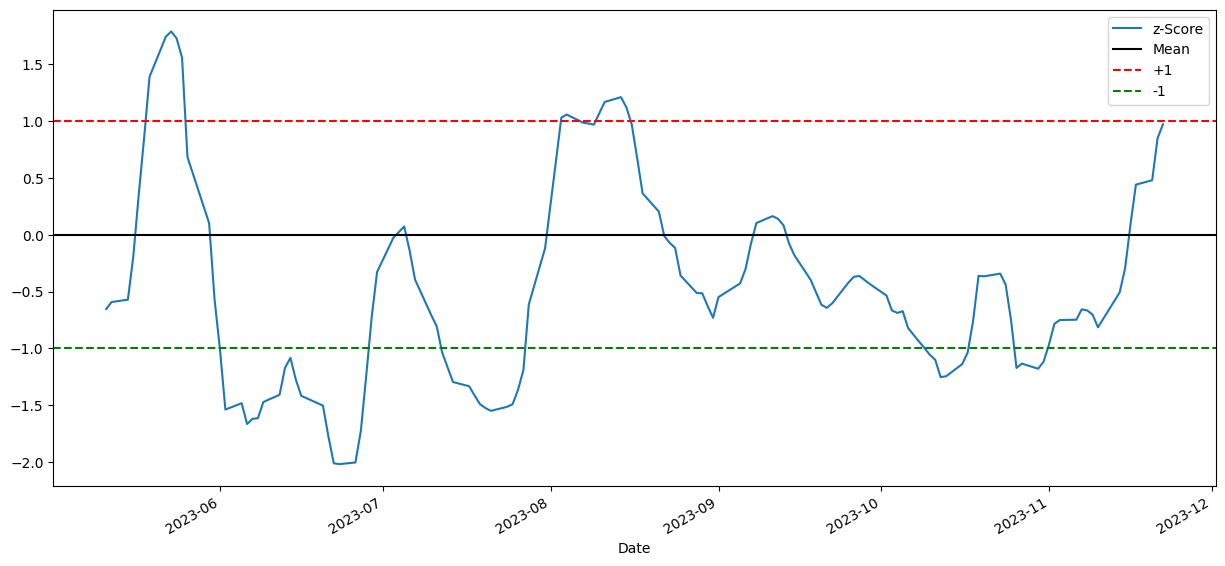

138.6768900470882


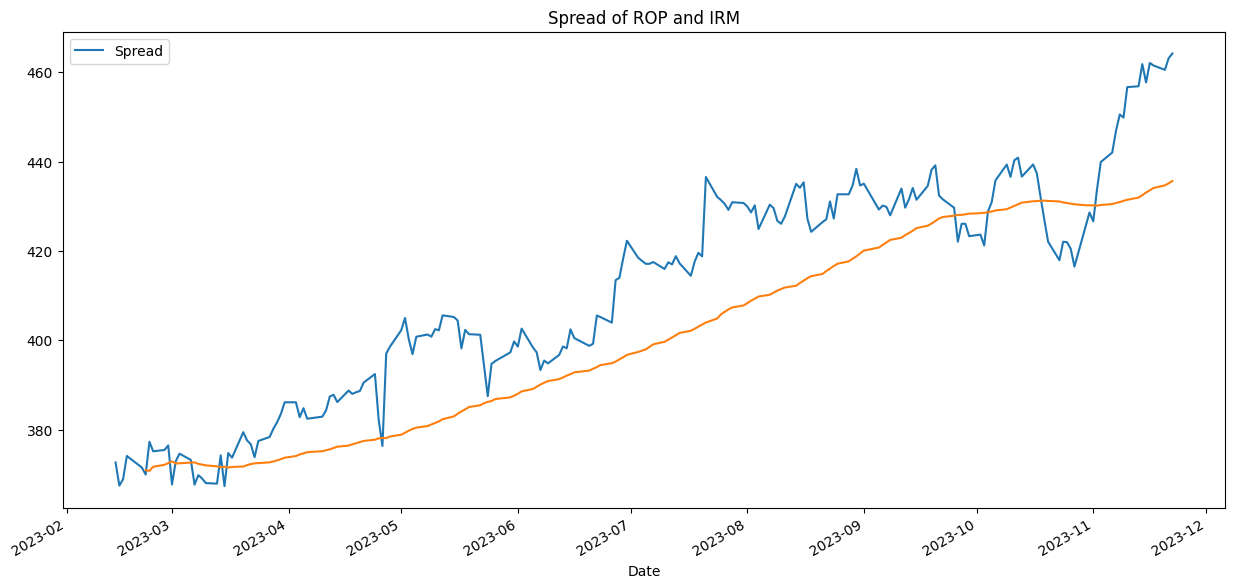

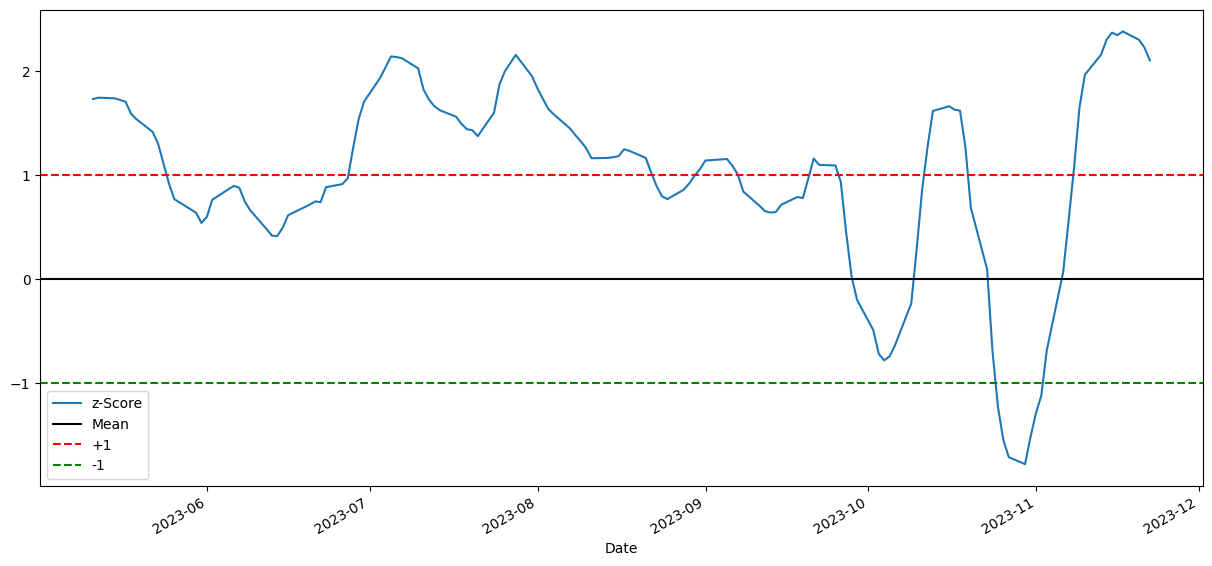

-56.24448348580427


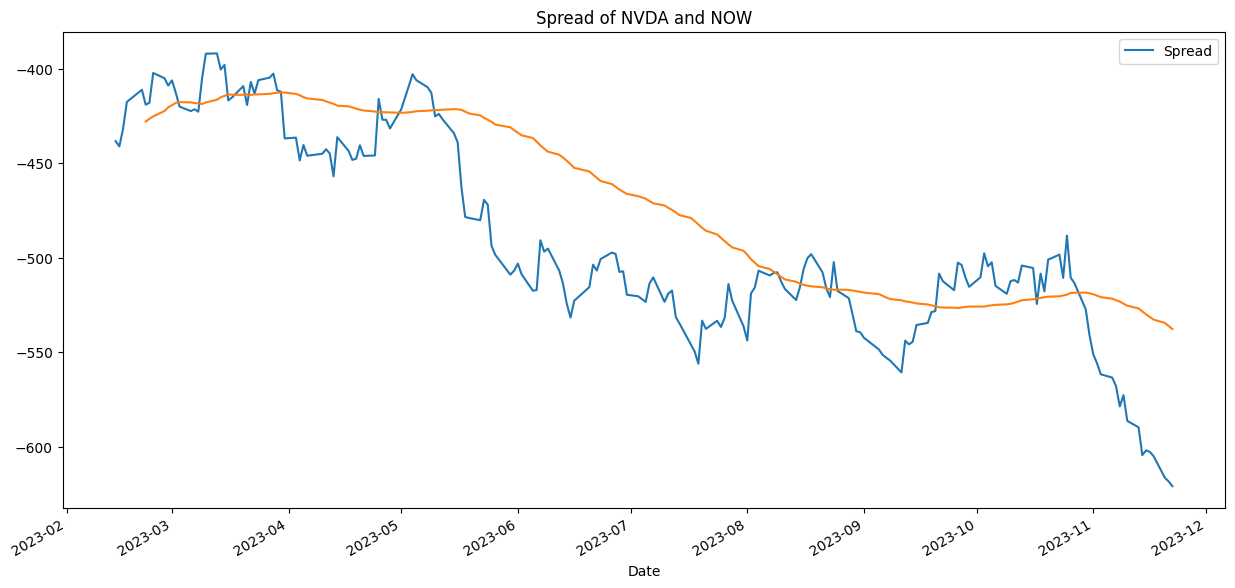

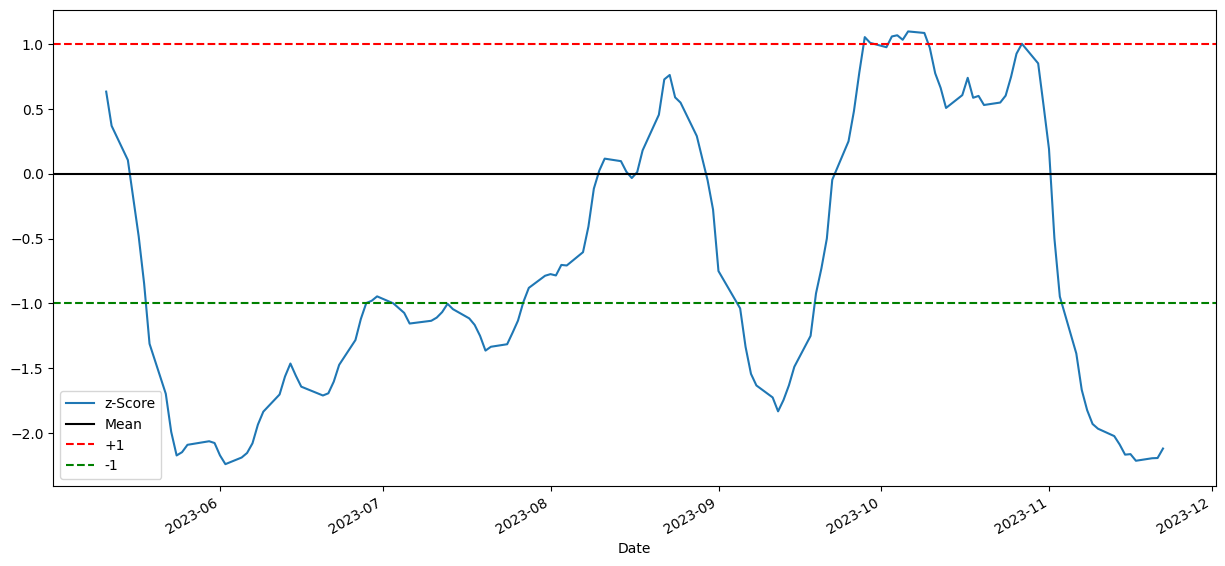

184.46217496146625


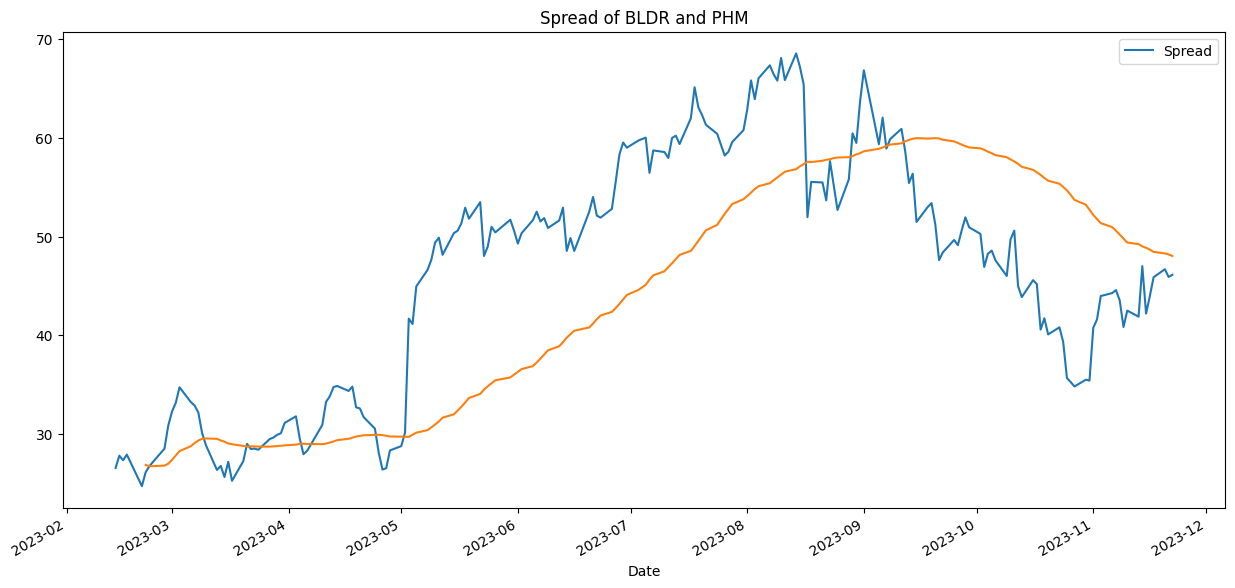

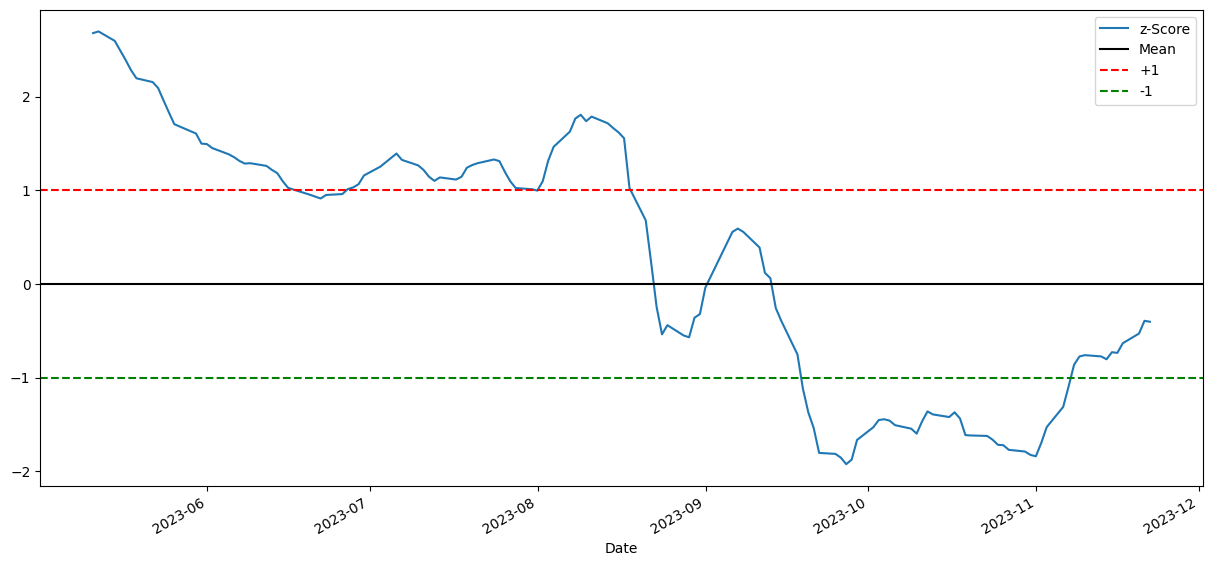

77.59416473751753


In [ ]:
def trade_pairs_rolling(filename, trading_horizon_days=180, plot='off'):
        """
        Executes the rolling mean trading strategy for top 5 pairs in the pairs file within a defined trading period.
        """
        start_formation, end_formation = extract_date(filename)
        start_date = end_formation + timedelta(days=1)
        trading_horizon = timedelta(days=trading_horizon_days)
        money_list = []
        end_date = start_date + trading_horizon
        end_date = pd.to_datetime(end_date, utc=True)
        pairs = pd.read_csv(filename)
        pairs.iloc[:5]
        for _, row in pairs.iterrows():
            asset1_name, asset2_name = row["Asset 1"], row["Asset 2"]
            asset1 = df[asset1_name].loc[start_formation:end_date]
            asset2 = df[asset2_name].loc[start_formation:end_date]
            spread = asset1 - asset2
            ratio = asset1/asset2
            rolling_mean_5 = spread.shift(1).rolling(window=5, min_periods=5).mean() #avoid lookahead bias
            rolling_mean = spread.shift(1).rolling(window=60, min_periods=5).mean()
            rolling_std = spread.shift(1).rolling(window=60,center=False).std()
            zscore= (rolling_mean_5 - rolling_mean)/rolling_std

            if plot == 'on':
                spread.plot(figsize=(15,7))
                rolling_mean.plot()
                plt.legend(['Spread'])
                plt.title(f'Spread of {asset1_name} and {asset2_name}')
                plt.show()
                plt.figure(figsize=(15,7))
                zscore.plot()
                plt.axhline(0, color='black')
                plt.axhline(1.0, color='red', linestyle='--')
                plt.axhline(-1.0, color='green', linestyle='--')
                plt.legend(['z-Score', 'Mean', '+1', '-1'])
                plt.show()
            ##trade
            money = 0
            countS1 = 0
            countS2 = 0
            for i in spread.index:
                # Sell short if the z-score is > 1
                if zscore[i] > 1:
                        money += asset1[i] - asset2[i]*ratio[i]
                        countS1 -= 1
                        countS2 += ratio[i]
                # Buy long if the z-score is < 1
                elif zscore[i] < -1:
                        money -= asset1[i] - asset2[i]*ratio[i]
                        countS1 += 1
                        countS2 -= ratio[i]
                # Clear positions if the z-score between -.5 and .5
                elif abs(zscore[i]) < 0.5:
                        money += countS1*asset1[i] + asset2[i] * countS2
                        countS1 = 0
                        countS2 = 0
                #print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
            if plot == 'on': print(money)
            money_list.append(money)
        return money_list

money_data = trade_pairs_rolling('pairs_2023-02-14_2023-10-23.csv', trading_horizon_days=30, plot='on')


With clustering, avg results is 7.894355351366778
Without, avg results is 11.227033161856534
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is -2.0516357424113876
Without, avg results is -0.6625039768288861
__

With clustering, avg results is 26.048669126276756
Without, avg results is 18.89995095723675
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is -2.46814690061538
Without, avg results is -3.3339843860479315
__

With clustering, avg results is 62.842924682700676
Without, avg results is 51.384152666105805
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 0.2016837584211264
Without, avg results is 5.077493697845301
__


With clustering, avg results is -17.97980365497483
Without, avg results is -21.618631493854373
__

With clustering, avg results is -4.2174645057637346
Without, avg results is -5.4916126533515035
__

With clustering, avg results is 15.0765499364

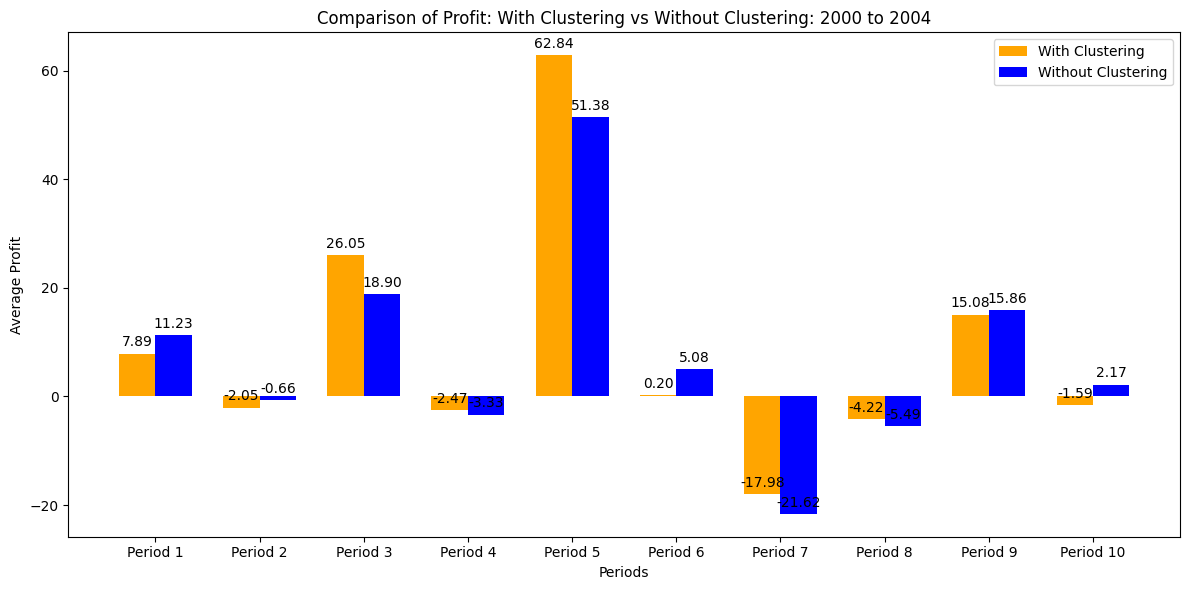

################# recent:
With clustering, avg results is 218.49138936877816
Without, avg results is 188.58030217256743
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 8.760693711948004
Without, avg results is -48.72841570000954
__


With clustering, avg results is 138.2277656797166
Without, avg results is 230.911213863906
__


With clustering, avg results is -14.489382722748156
Without, avg results is 284.6167095217344
__

With clustering, avg results is 181.03993110801946
Without, avg results is 220.88474462066148
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 251.41249102686317
Without, avg results is 352.04600554682963
__
Reject the null hypothesis: The mean is greater than 0.

With clustering, avg results is 375.07746955616136
Without, avg results is -389.47731885797174
__


With clustering, avg results is 622.6862852942033
Without, avg results is 693.2011652019809
__


With clustering, avg re

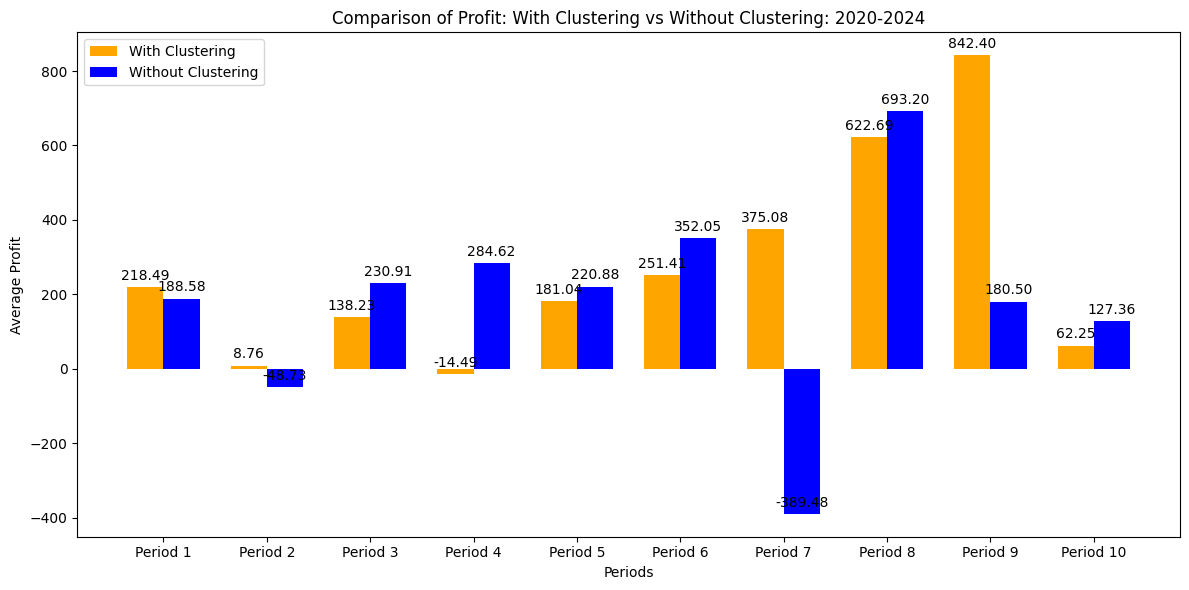

In [ ]:
filenames = [
    'pairs_2000-05-09_2001-01-15.csv',
    'pairs_2000-09-12_2001-05-21.csv',
    'pairs_2001-05-22_2002-01-28.csv',
    'pairs_2001-09-25_2002-06-03.csv',
    'pairs_2002-01-29_2002-10-07.csv',
    'pairs_2002-06-04_2003-02-10.csv',
    'pairs_2002-10-08_2003-06-16.csv',
    'pairs_2003-02-11_2003-10-20.csv',
    'pairs_2003-06-17_2004-02-23.csv',
    'pairs_2003-10-21_2004-06-28.csv',
]
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store average returns for plotting
avg_returns_with_cluster = []
avg_returns_without_cluster = []

# Iterate through filenames and compute returns
for f in filenames:
    f2 = 'nocluster' + f
    money_list = trade_pairs_distance(f, trading_horizon_days=30) #change to trade_pairs_rolling to get the results for that strategy
    money_list2 = trade_pairs_distance(f2, trading_horizon_days=30)

    # Compute averages
    avg_with_cluster = np.mean(money_list)
    avg_without_cluster = np.mean(money_list2)
    avg_returns_with_cluster.append(avg_with_cluster)
    avg_returns_without_cluster.append(avg_without_cluster)

    # Print results
    print(f"With clustering, avg results is {avg_with_cluster}")
    print(f"Without, avg results is {avg_without_cluster}")
    _, _, result_0 = test_mean_greater_than_zero(money_list)
    _, _, result = test_mean_greater_than(money_list, money_list2)
    print("__")
    if avg_with_cluster > 0:
        print(result_0)
    print(result)

# Plot the comparison of returns
x_labels = [f"Period {i+1}" for i in range(len(filenames))]
x = np.arange(len(x_labels))  # Label locations
width = 0.35  # Width of the bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, avg_returns_with_cluster, width, label='With Clustering', color='orange')
bars2 = ax.bar(x + width/2, avg_returns_without_cluster, width, label='Without Clustering', color='blue')

# Adding labels, title, and legend
ax.set_xlabel("Periods")
ax.set_ylabel("Average Profit")
ax.set_title("Comparison of Profit: With Clustering vs Without Clustering: 2000 to 2004")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

# Adding values above the bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()


print("################# recent:")    
later_filenames = [
    'pairs_2020-09-15_2021-05-24.csv',
    'pairs_2021-01-19_2021-09-27.csv',
    'pairs_2021-05-25_2022-01-31.csv',
    'pairs_2021-09-28_2022-06-06.csv',
    'pairs_2022-02-01_2022-10-10.csv',
    'pairs_2022-06-07_2023-02-13.csv',
    'pairs_2022-10-11_2023-06-19.csv',
    'pairs_2023-02-14_2023-10-23.csv',
    'pairs_2023-06-20_2024-02-26.csv',
    'pairs_2024-02-27_2024-11-04.csv'
]
avg_returns_with_cluster = []
avg_returns_without_cluster = []

# Iterate through filenames and compute returns
for f in later_filenames:
    f2 = 'nocluster' + f
    money_list = trade_pairs_rolling(f, trading_horizon_days=30)
    money_list2 = trade_pairs_rolling(f2, trading_horizon_days=30)

    # Compute averages
    avg_with_cluster = np.mean(money_list)
    avg_without_cluster = np.mean(money_list2)
    avg_returns_with_cluster.append(avg_with_cluster)
    avg_returns_without_cluster.append(avg_without_cluster)

    # Print results
    print(f"With clustering, avg results is {avg_with_cluster}")
    print(f"Without, avg results is {avg_without_cluster}")
    _, _, result_0 = test_mean_greater_than_zero(money_list)
    _, _, result = test_mean_greater_than(money_list, money_list2)
    print("__")
    if avg_with_cluster > 0:
        print(result_0)
    print(result)

# Plot the comparison of returns
x_labels = [f"Period {i+1}" for i in range(len(filenames))]
x = np.arange(len(x_labels))  # Label locations
width = 0.35  # Width of the bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, avg_returns_with_cluster, width, label='With Clustering', color='orange')
bars2 = ax.bar(x + width/2, avg_returns_without_cluster, width, label='Without Clustering', color='blue')

# Adding labels, title, and legend
ax.set_xlabel("Periods")
ax.set_ylabel("Average Profit")
ax.set_title("Comparison of Profit: With Clustering vs Without Clustering: 2020-2024")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

# Adding values above the bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
from os import statvfs_result
from hmmlearn import hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the HMM modeling function
def model(df, stock_a, stock_b, start_date, num_days=252, states=2):
    """
    Apply Gaussian HMM to model spread between two stocks.

    Parameters:
        df (pd.DataFrame): DataFrame with stock price data.
        stock_a (str): Ticker for the first stock.
        stock_b (str): Ticker for the second stock.
        start_date (str or pd.Timestamp): Start date of analysis.
        num_days (int): Number of days to include in the analysis.

    Returns:
        None: Displays model parameters and plots the spread and hidden states.
    """

    # Ensure the DataFrame index is datetime
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index, utc=True)

    # Filter data for the specified period
    start_date = pd.to_datetime(start_date, utc=True)
    end_date = start_date + pd.Timedelta(days=num_days - 1)
    filtered_data = df.loc[start_date:end_date]
    filtered_data = filtered_data[[stock_a, stock_b]].dropna()

    # Calculate the spread
    spread = filtered_data[stock_a] - filtered_data[stock_b]
    spread_data = spread.values.reshape(-1, 1)

    # Initialize and fit the Gaussian HMM model
    hmm_model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=100)
    hmm_model.fit(spread_data)

    # Extract hidden states
    hidden_states = hmm_model.predict(spread_data)

    # Display estimated parameters
    print("Transition Probabilities:\n", hmm_model.transmat_)
    print("Means (Regime Means):\n", hmm_model.means_.flatten())
    print("Covariances (Spread Variances):\n", hmm_model.covars_.flatten())

    # Plot the spread and estimated regimes
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data.index, spread, label="Spread")
    plt.step(filtered_data.index, hidden_states, where='mid', linestyle="--", label="Hidden States")
    plt.title(f"Estimated Regime Switching States for {stock_a} & {stock_b}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.show()


Transition Probabilities:
 [[9.96114616e-01 3.88538362e-03]
 [4.10140312e-10 1.00000000e+00]]
Means (Regime Means):
 [-0.24374299  0.10183855]
Covariances (Spread Variances):
 [0.00466358 0.02243193]


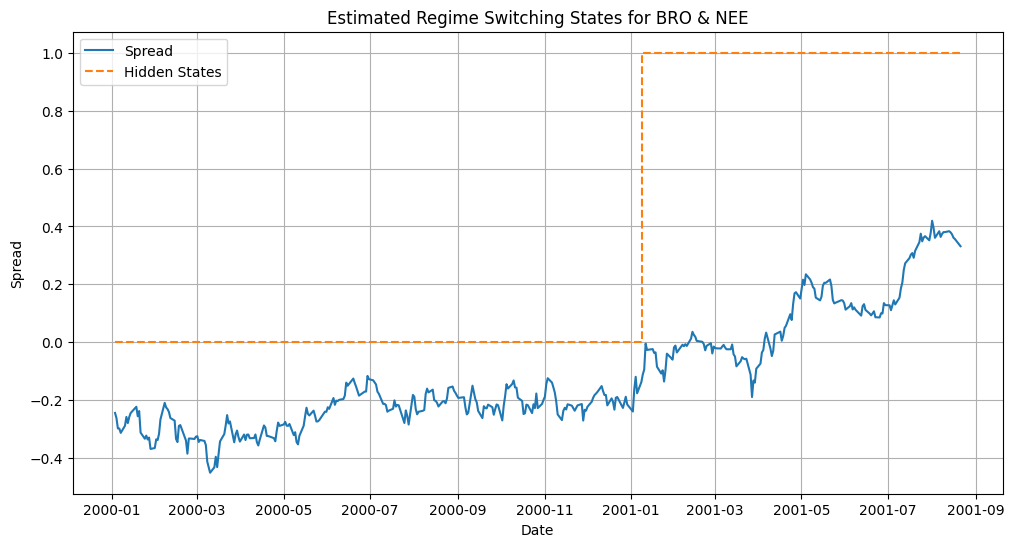

In [ ]:
start = pd.to_datetime("2000-01-01", utc=True)
model(log_prices, 'BRO', 'NEE', start_date=start, num_days=600, states=2) #ssd


In [ ]:
#In order to generate proﬁts in a pair-trade, the priceratio between the two stocks needs to have a constantmean and a constant volatility over time.
# => regimes have diff mean and volatility

In [ ]:
#https://www.tandfonline.com/doi/full/10.1080/00036846.2014.975417 pairs trading methods
#yang https://www.sciencedirect.com/science/article/pii/S1059056015001860
#correlation matrix
#k means cluster: securites closely related to each other
#SSD as well, try both
#acknowledge that strategy is on some subset of stocks ie
#robustness: pair becomes delisted...?
#regime shift has upper threshold helps
#stat arb very nice >:D
#backtesting brother what
#
#####################################
#good paper i j found: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4128453


In [ ]:
# for each pair in top 20 cointegrated pairs every 1 year window w/ a 1 month step,
# 1. Extract spreads for the selected pair.
# 2. Estimate the Vasicek model and regime-switching parameters.
# 3. Generate trading signals based on dynamic thresholds.
# 4. Evaluate trading performance over the window.
# 5. Move the window forward and repeat.